In [1]:
import os
import math
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import pycocotools
from torch.utils.tensorboard import SummaryWriter

In [2]:
# if torch.cuda.is_available():  
#     device = "cuda:0" 
# else:  
#     device = "cpu" 
    
# torch.cuda.current_device()

In [3]:
# Code from Maastricht to access GPU of choice

import torch
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'


In [4]:
torch.cuda.set_device(0)
device = torch.device(f'cuda:{0}' if torch.cuda.is_available() else 'cpu')


In [5]:
torch.cuda.current_device(), torch.cuda.get_device_name()

(0, 'GeForce GTX 1080 Ti')

## Import data

In [6]:
# traindatadir = '\\\\tsclient\\E\\Preprocessed\\TrainCalcClusterSynthetic'
# traindatadir = 'B:\\Astrid\\Preprocessed\\TrainCalcClusterSynthetic'
# traindatadir = 'B:\\Astrid\\Preprocessed\\TrainCalcClusterReal'
traindatadir = 'B:\\Astrid\\Preprocessed\\TrainCalcClusterAll'
# testdatadir = '\\\\tsclient\\E\\Preprocessed\\TestCalcClusterReal'
testdatadir = 'B:\\Astrid\\Preprocessed\\TestCalcClusterReal'
# savedir = '\\\\tsclient\\E\\Models'
savedir = 'B:\\Astrid\\Preprocessed\\Models'

In [7]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode


# Class for a customized dataset
# In this case preprocessed CEM images combined in a 3-channel RGB .jpg format
# and the corresponding mask of present lesions in a 1-channel .png format
class CustomImageDataset(Dataset):
    def __init__(self, root, annotations_file, img_dir, mask_dir, transform=None, target_transform=None):
        # Read the .csv file with all the information
        self.img_labels = pd.read_csv(os.path.join(root, annotations_file))
        # Define the directories of the images and masks
        self.img_dir = os.path.join(root, img_dir)
        self.mask_dir = os.path.join(root, mask_dir)
        # Define whethet transformations are included
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # Return the number of cases in the dataset
        # In this set, CC and MLO of the same breast are considered different cases
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Read the image and the mask for a case from the directories
        img_path = self.img_labels.iloc[idx, 0]
        mask_path = self.img_labels.iloc[idx,6]
        img_path = img_path.replace('E:', '\\\\tsclient\E')
        mask_path = mask_path.replace('E:', '\\\\tsclient\E')
        image = read_image(img_path).float()
        mask = read_image(mask_path)

        # Resize so all images and masks have the same size
#         image = T.Resize([800,800])(image)
#         mask = T.Resize([800,800])(mask)    
#         resize_scale_x = 800/image.size()[1]
#         resize_scale_y = 800/image.size()[2]

        # Resize if necessary
        # First the smallest dimension is reduced to 400 if it is larger
        # Then the largest dimension is reduced to 650 if it is still larger
        resize_scale = 1.0
        min_size_idx = np.argmin([image.size()[1], image.size()[2]])
        
        if min_size_idx == 0 and image.size()[1] > 400 :
            resize_scale *= 400/image.size()[1]
            image = T.Resize([400, int(400*image.size()[2]/image.size()[1])])(image)
            mask = T.Resize([400, int(400*image.size()[2]/image.size()[1])], interpolation=InterpolationMode.NEAREST)(mask)
        if min_size_idx == 0 and image.size()[2] > 650 :
            resize_scale *= 650/image.size()[2]
            image = T.Resize([int(650*image.size()[1]/image.size()[2]), 650])(image)
            mask = T.Resize([int(650*image.size()[1]/image.size()[2]), 650], interpolation=InterpolationMode.NEAREST)(mask)
        
        if min_size_idx == 1 and image.size()[2] > 400 :
            resize_scale *= 400/image.size()[2]
            image = T.Resize([int(400*image.size()[1]/image.size()[2]), 400])(image)
            mask = T.Resize([int(400*image.size()[1]/image.size()[2]), 400], interpolation=InterpolationMode.NEAREST)(mask)
        if min_size_idx == 1 and image.size()[1] > 650 :
            resize_scale *= 650/image.size()[1]
            image = T.Resize([650, int(650*image.size()[2]/image.size()[1])])(image)
            mask = T.Resize([650, int(650*image.size()[2]/image.size()[1])], interpolation=InterpolationMode.NEAREST)(mask)
            
        # Normalize image with mean and standard deviation per channel
        mean = torch.mean(image, dim=(1,2))
        stdev = torch.std(image, dim=(1,2))
        image = T.Normalize(mean, stdev)(image)
        
        # Rescale to [0,1] range per channel
        for dim in range(3) :
            image[dim] -= torch.min(image[dim])
            image[dim] /= torch.max(image[dim])  
        
        # Create separate channel in mask for each lesion
        mask_out = np.zeros((torch.max(mask).item(), mask.shape[-2], mask.shape[-1]))
        for lesion_idx in range(torch.max(mask).item()) :
#             mask_out[lesion_idx][mask[0]==lesion_idx+1] = 1  
            mask_out[lesion_idx][mask[0]>0] = 1 # alternative for wrong masks with only one lesion
        
        # Read the location of the lesion bounding box from the .csv file
        xmin = self.img_labels.iloc[idx, 1]
        xmax = self.img_labels.iloc[idx, 2]
        ymin = self.img_labels.iloc[idx, 3]
        ymax = self.img_labels.iloc[idx, 4]
        boxes = [[ymin*resize_scale, xmin*resize_scale, ymax*resize_scale, xmax*resize_scale]]
        # Read the label of the lesion from the .csv file
        labels = self.img_labels.iloc[idx, 5]  
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        labels = torch.tensor([labels])
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        mask_out = torch.from_numpy(mask_out)
        mask_out = mask_out.to(torch.uint8)
        
        iscrowd = torch.zeros((2,), dtype=torch.int64)
        
        # Apply transformations if defined
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)  
            
        target = {}
        target["image_id"] = image_id
        target["masks"] = mask_out
        target["boxes"] = boxes
        target["area"] = area
        target["labels"] = labels
        target["iscrowd"] = iscrowd
            
        return image, target


In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import utils
from torch.utils.data import random_split

# Read training dataset and split in training and validation data
trainval_data = CustomImageDataset(traindatadir, 'annotations_train_calccluster_all_onlymal.csv', 'colored_to_jpg', 'mask_to_png')
train_data, val_data = random_split(trainval_data, [int(np.floor(len(trainval_data)*0.8)), int(np.ceil(len(trainval_data)*0.2))], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)
val_dataloader = DataLoader(val_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)

# Read test dataset
test_data = CustomImageDataset(testdatadir, 'annotations_test_calccluster_real_onlymal.csv', 'colored_to_jpg', 'mask_to_png')
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)


FileNotFoundError: [Errno 2] No such file or directory: 'B:\\Astrid\\Preprocessed\\TrainCalcClusterAll\\annotations_train_calccluster_real_onlymal.csv'

In [10]:
len(train_data), len(val_data)



(373, 94)

In [11]:
# For Training
train_images, train_targets = next(iter(train_dataloader))
train_image_list = list(image for image in train_images)
train_target_list = [{k: v for k, v in t.items()} for t in train_targets]

# For Validation
val_images, val_targets = next(iter(val_dataloader))
val_image_list = list(image for image in val_images)
val_target_list = [{k: v for k, v in t.items()} for t in val_targets]

# For Testing
test_images, test_targets = next(iter(test_dataloader))
test_image_list = list(image for image in test_images)
test_target_list = [{k: v for k, v in t.items()} for t in test_targets]

In [12]:
# for t in train_targets :
#     for k,v in t.items() :
#         print(k,v)
#         v.to(device)


In [13]:
val_target_list

[{'image_id': tensor([19]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': tensor([[114.4959, 268.9273, 135.1009, 299.7286]]),
  'area': tensor([634.6611]),
  'labels': tensor([1]),
  'iscrowd': tensor([0, 0])},
 {'image_id': tensor([454]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 

In [14]:
test_target_list

[{'image_id': tensor([8]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': tensor([[126.0314, 354.4632, 138.3391, 378.0941]]),
  'area': tensor([290.8426]),
  'labels': tensor([1]),
  'iscrowd': tensor([0, 0])},
 {'image_id': tensor([70]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0]

In [15]:
train_targets[0]['image_id'], train_targets[1]['image_id'], train_targets[2]['image_id'], train_targets[3]['image_id']

(tensor([8]), tensor([449]), tensor([420]), tensor([375]))

tensor([449]) tensor([[193.8281, 270.3392, 204.4731, 277.4359]])
[220, 327, 143, 254]


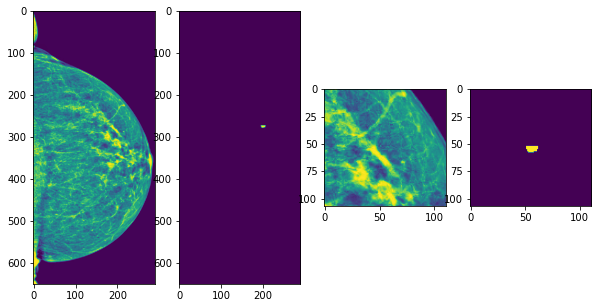

In [16]:
pat_idx = 1
print(train_targets[pat_idx]['image_id'], train_targets[pat_idx]['boxes'])

fig, ax = plt.subplots(1,4, figsize=(10,15))

ax[0].imshow(train_images[pat_idx][0])
ax[1].imshow(train_targets[pat_idx]['masks'][0])

enlarged_box = [int(train_targets[pat_idx]['boxes'][0][1])-50,
                int(train_targets[pat_idx]['boxes'][0][3])+50,
                int(train_targets[pat_idx]['boxes'][0][0])-50,                
                int(train_targets[pat_idx]['boxes'][0][2])+50]
print(enlarged_box)
ax[2].imshow(train_images[pat_idx][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])
ax[3].imshow(train_targets[pat_idx]['masks'][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])

## Define model

In [17]:
import torchvision
from torchvision.models.detection import FasterRCNN, MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# backbone = torchvision.models.resnet50(pretrained=True, progress=True)
# backbone.out_channels = 1000

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                     output_size=14,
                                                     sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
# model = FasterRCNN(backbone,
#                    num_classes=3,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

# put the pieces together inside a MaskRCNN model
model = MaskRCNN(backbone,
                 num_classes=2,
                 rpn_anchor_generator=anchor_generator,
                 box_roi_pool=roi_pooler,
                 mask_roi_pool=mask_roi_pooler,
                 min_size=400,
                 max_size=650)

# import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# num_classes = 2

# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
#                                                 output_size=7,
#                                                 sampling_ratio=2)

# mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
#                                                      output_size=14,
#                                                      sampling_ratio=2)

# anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#                                    aspect_ratios=((0.5, 1.0, 2.0),))

# # load an instance segmentation model pre-trained on COCO
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
#                                                            box_roi_pool=roi_pooler,
#                                                            mask_roi_pool=mask_roi_pooler,
#                                                            min_size=400,
#                                                            max_size=650)

# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


# # now get the number of input features for the mask classifier
# in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
# hidden_layer = 256
# # and replace the mask predictor with a new one
# model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
#                                                    hidden_layer,
#                                                    num_classes)


In [18]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(400,), max_size=650, mode='bilinear')
  )
  (backbone): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
   

In [19]:
def train_one_epoch_kulum(model, optimizer, train_data_loader, val_data_loader, writer, device, epoch, print_freq, scaler=None):
    
    # Initialise training
    model.train()
    
    # Set up logger to save metrics and losses
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    # Define scheduler for learning rate in optimizer
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(train_data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    # Read the images and targets from the training data loader
    for images, targets in metric_logger.log_every(train_data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Compute the losses of the model on these training images and targets
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # Reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
           
        # Write to .tfevents
#         grid = torchvision.utils.make_grid(images)
#         writer.add_image('images', grid, 0)
#         writer.add_graph(model, images)
        
        writer.add_scalar('Loss/train', metric_logger.loss.value, epoch)
        writer.add_scalar('Loss classifier/train', metric_logger.loss_classifier.value, epoch)
        writer.add_scalar('Loss box reg/train', metric_logger.loss_box_reg.value, epoch)
        writer.add_scalar('Loss rpn box reg/train', metric_logger.loss_rpn_box_reg.value, epoch)
        
    # Set up logger to save metrics and losses of validation
    metric_logger_val = utils.MetricLogger(delimiter="  ")
    metric_logger_val.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
        
    # Read the images and targets from the validation data loader
    for images_val, targets_val in metric_logger_val.log_every(val_data_loader, print_freq, header):
        images_val = list(image.to(device) for image in images_val)
        targets_val = [{k: v.to(device) for k, v in t.items()} for t in targets_val]
        # Compute the losses of the model on these training images and targets
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict_val = model(images_val, targets_val)
            losses_val = sum(loss for loss in loss_dict_val.values())

        # Reduce losses over all GPUs for logging purposes
        loss_dict_reduced_val = utils.reduce_dict(loss_dict_val)
        losses_reduced_val = sum(loss for loss in loss_dict_reduced_val.values())

        loss_value_val = losses_reduced_val.item()
        
        metric_logger_val.update(loss=losses_reduced_val, **loss_dict_reduced_val)
        metric_logger_val.update(lr=optimizer.param_groups[0]["lr"])
        
        writer.add_scalar('Loss/val', metric_logger_val.loss.value, epoch)
        writer.add_scalar('Loss classifier/val', metric_logger_val.loss_classifier.value, epoch)
        writer.add_scalar('Loss box reg/val', metric_logger_val.loss_box_reg.value, epoch)
        writer.add_scalar('Loss rpn box reg/val', metric_logger_val.loss_rpn_box_reg.value, epoch)

    return metric_logger, metric_logger_val

def early_stopping_kulum(prev_loss, curr_loss, num_epochs) :
    
    if curr_loss > prev_loss :
        return num_epochs + 1
    else :
        return 0


In [20]:
from engine import train_one_epoch, evaluate

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# model_writer = SummaryWriter('\\\\tsclient\\E\\runs\smallexpsynthetic')
model_writer = SummaryWriter('B:\\Astrid\\Preprocessed\\runs\\6_malexpall')

# let's train it for 10 epochs
num_epochs = 200
logs = []
logs_val = []
min_val_loss = 0.0
stop_epoch = 0

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
#     sample_image, sample_target = sample(next(iter(train_dataloader)))
    
#     sample_image, sample_target = first(train_dataloader)
#     output = self.model(sample_image.to(self.device))
    
    epoch_loss, epoch_loss_val = train_one_epoch_kulum(model, optimizer, train_dataloader, val_dataloader, model_writer, device, epoch, print_freq=10)
#     epoch_loss = train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)
    logs.append(epoch_loss)
    logs_val.append(epoch_loss_val)
    
    # update the learning rate
#     lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, val_dataloader, device=device)
    
#     torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': loss,
#                 'loss_classifier': loss_classifier,
#                 'loss_box_reg': loss_box_reg,
#                 'loss_mask': loss_mask,
#                 'loss_objectness': loss_objectness,
#                 'loss_rpn_box': loss_rpn_box
#                 }, savedir)

#     if epoch > 50 :
#         stop_epoch = early_stopping_kulum(min_val_loss, epoch_loss_val.loss.value, stop_epoch)
#         if stop_epoch > 5 :
#             print(f'Early stopping at epoch {epoch} with loss {epoch_loss_val.loss.value}.')

#             break

#         else :
#             min_val_loss = min(min_val_loss, epoch_loss_val.loss.value)
    
    if epoch % 10 == 0 :
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                    }, os.path.join(savedir, 'model_malall_'+str(epoch)+'.pth'))
        
model_writer.close()

C:\Users\P70074720\.conda\envs\pytorch36\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [ 0/94]  eta: 0:14:38  lr: 0.000059  loss: 6.4531 (6.4531)  loss_classifier: 0.5951 (0.5951)  loss_box_reg: 0.0003 (0.0003)  loss_mask: 5.1581 (5.1581)  loss_objectness: 0.6908 (0.6908)  loss_rpn_box_reg: 0.0088 (0.0088)  time: 9.3422  data: 1.0033  max mem: 3315
Epoch: [0]  [10/94]  eta: 0:03:00  lr: 0.000596  loss: 5.5889 (5.5408)  loss_classifier: 0.4453 (0.4171)  loss_box_reg: 0.0005 (0.0018)  loss_mask: 4.3105 (4.4388)  loss_objectness: 0.6863 (0.6726)  loss_rpn_box_reg: 0.0106 (0.0105)  time: 2.1457  data: 1.0491  max mem: 3964
Epoch: [0]  [20/94]  eta: 0:02:14  lr: 0.001133  loss: 2.0735 (3.6917)  loss_classifier: 0.1316 (0.2599)  loss_box_reg: 0.0005 (0.0038)  loss_mask: 1.3351 (2.8294)  loss_objectness: 0.5994 (0.5887)  loss_rpn_box_reg: 0.0106 (0.0099)  time: 1.4417  data: 1.0608  max mem: 3964
Epoch: [0]  [30/94]  eta: 0:01:45  lr: 0.001670  loss: 1.2544 (2.8367)  loss_classifier: 0.0602 (0.1877)  loss_box_reg: 0.0004 (0.0033)  loss_mask: 0.7961 (2.1448)  loss_ob

Epoch: [1]  [60/94]  eta: 0:00:48  lr: 0.005000  loss: 0.6898 (0.6555)  loss_classifier: 0.0155 (0.0199)  loss_box_reg: 0.0013 (0.0045)  loss_mask: 0.6299 (0.6017)  loss_objectness: 0.0220 (0.0242)  loss_rpn_box_reg: 0.0051 (0.0051)  time: 1.3469  data: 0.9579  max mem: 5532
Epoch: [1]  [70/94]  eta: 0:00:34  lr: 0.005000  loss: 0.7085 (0.6629)  loss_classifier: 0.0156 (0.0197)  loss_box_reg: 0.0017 (0.0043)  loss_mask: 0.6603 (0.6092)  loss_objectness: 0.0223 (0.0243)  loss_rpn_box_reg: 0.0055 (0.0054)  time: 1.3780  data: 0.9925  max mem: 5532
Epoch: [1]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.6753 (0.6627)  loss_classifier: 0.0156 (0.0197)  loss_box_reg: 0.0000 (0.0043)  loss_mask: 0.6237 (0.6091)  loss_objectness: 0.0233 (0.0243)  loss_rpn_box_reg: 0.0053 (0.0053)  time: 1.3867  data: 1.0093  max mem: 5532
Epoch: [1]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.6465 (0.6632)  loss_classifier: 0.0179 (0.0199)  loss_box_reg: 0.0015 (0.0044)  loss_mask: 0.5917 (0.6095)  loss_ob

Epoch: [2]  [10/24]  eta: 0:00:16  lr: 0.005000  loss: 0.5565 (0.6103)  loss_classifier: 0.0131 (0.0140)  loss_box_reg: 0.0000 (0.0011)  loss_mask: 0.5172 (0.5703)  loss_objectness: 0.0185 (0.0198)  loss_rpn_box_reg: 0.0043 (0.0051)  time: 1.1521  data: 0.9673  max mem: 5535
Epoch: [2]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.5439 (0.5993)  loss_classifier: 0.0131 (0.0170)  loss_box_reg: 0.0000 (0.0033)  loss_mask: 0.5030 (0.5520)  loss_objectness: 0.0199 (0.0216)  loss_rpn_box_reg: 0.0049 (0.0055)  time: 1.1070  data: 0.9240  max mem: 5535
Epoch: [2]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.5480 (0.6133)  loss_classifier: 0.0132 (0.0179)  loss_box_reg: 0.0000 (0.0036)  loss_mask: 0.5063 (0.5647)  loss_objectness: 0.0206 (0.0220)  loss_rpn_box_reg: 0.0045 (0.0051)  time: 1.1080  data: 0.9245  max mem: 5535
Epoch: [2] Total time: 0:00:26 (1.1085 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:23  model_time: 0.1250 (0.1250)  evaluator_time: 0.0156 (0.0156)  

Epoch: [4]  [ 0/94]  eta: 0:01:55  lr: 0.005000  loss: 0.6484 (0.6484)  loss_classifier: 0.0503 (0.0503)  loss_box_reg: 0.0270 (0.0270)  loss_mask: 0.5447 (0.5447)  loss_objectness: 0.0238 (0.0238)  loss_rpn_box_reg: 0.0026 (0.0026)  time: 1.2282  data: 0.8220  max mem: 5535
Epoch: [4]  [10/94]  eta: 0:01:52  lr: 0.005000  loss: 0.5928 (0.6045)  loss_classifier: 0.0204 (0.0257)  loss_box_reg: 0.0041 (0.0087)  loss_mask: 0.5383 (0.5434)  loss_objectness: 0.0215 (0.0216)  loss_rpn_box_reg: 0.0054 (0.0051)  time: 1.3442  data: 0.9535  max mem: 5535
Epoch: [4]  [20/94]  eta: 0:01:42  lr: 0.005000  loss: 0.5928 (0.6164)  loss_classifier: 0.0184 (0.0243)  loss_box_reg: 0.0035 (0.0088)  loss_mask: 0.5470 (0.5575)  loss_objectness: 0.0212 (0.0211)  loss_rpn_box_reg: 0.0045 (0.0047)  time: 1.3943  data: 1.0093  max mem: 5535
Epoch: [4]  [30/94]  eta: 0:01:28  lr: 0.005000  loss: 0.6115 (0.6054)  loss_classifier: 0.0180 (0.0241)  loss_box_reg: 0.0035 (0.0087)  loss_mask: 0.5460 (0.5467)  loss_ob

Epoch: [5]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.5397 (0.5746)  loss_classifier: 0.0156 (0.0198)  loss_box_reg: 0.0019 (0.0050)  loss_mask: 0.4934 (0.5240)  loss_objectness: 0.0216 (0.0209)  loss_rpn_box_reg: 0.0047 (0.0050)  time: 1.3486  data: 0.9708  max mem: 5535
Epoch: [5]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.5883 (0.5791)  loss_classifier: 0.0164 (0.0199)  loss_box_reg: 0.0031 (0.0051)  loss_mask: 0.5327 (0.5283)  loss_objectness: 0.0210 (0.0209)  loss_rpn_box_reg: 0.0047 (0.0050)  time: 1.3376  data: 0.9524  max mem: 5535
Epoch: [5]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.5707 (0.5752)  loss_classifier: 0.0161 (0.0198)  loss_box_reg: 0.0022 (0.0049)  loss_mask: 0.5278 (0.5249)  loss_objectness: 0.0204 (0.0208)  loss_rpn_box_reg: 0.0045 (0.0049)  time: 1.3476  data: 0.9615  max mem: 5535
Epoch: [5]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.5228 (0.5726)  loss_classifier: 0.0147 (0.0195)  loss_box_reg: 0.0000 (0.0047)  loss_mask: 0.4869 (0.5226)  loss_ob

Epoch: [6]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 0.5427 (0.5968)  loss_classifier: 0.0136 (0.0162)  loss_box_reg: 0.0001 (0.0023)  loss_mask: 0.4949 (0.5509)  loss_objectness: 0.0216 (0.0224)  loss_rpn_box_reg: 0.0048 (0.0050)  time: 1.1315  data: 0.9369  max mem: 5535
Epoch: [6]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.6147 (0.6746)  loss_classifier: 0.0145 (0.0181)  loss_box_reg: 0.0001 (0.0041)  loss_mask: 0.5768 (0.6254)  loss_objectness: 0.0201 (0.0219)  loss_rpn_box_reg: 0.0049 (0.0052)  time: 1.1634  data: 0.9680  max mem: 5535
Epoch: [6]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.5729 (0.6533)  loss_classifier: 0.0140 (0.0175)  loss_box_reg: 0.0001 (0.0036)  loss_mask: 0.5346 (0.6057)  loss_objectness: 0.0198 (0.0214)  loss_rpn_box_reg: 0.0051 (0.0052)  time: 1.1569  data: 0.9678  max mem: 5535
Epoch: [6] Total time: 0:00:27 (1.1407 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:30  model_time: 0.1719 (0.1719)  evaluator_time: 0.0157 (0.0157)  

Epoch: [8]  [ 0/94]  eta: 0:02:31  lr: 0.005000  loss: 0.5265 (0.5265)  loss_classifier: 0.0121 (0.0121)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.4926 (0.4926)  loss_objectness: 0.0165 (0.0165)  loss_rpn_box_reg: 0.0054 (0.0054)  time: 1.6100  data: 1.2194  max mem: 5535
Epoch: [8]  [10/94]  eta: 0:02:05  lr: 0.005000  loss: 0.5032 (0.4931)  loss_classifier: 0.0146 (0.0168)  loss_box_reg: 0.0000 (0.0021)  loss_mask: 0.4600 (0.4462)  loss_objectness: 0.0220 (0.0218)  loss_rpn_box_reg: 0.0059 (0.0062)  time: 1.4888  data: 1.0991  max mem: 5535
Epoch: [8]  [20/94]  eta: 0:01:48  lr: 0.005000  loss: 0.5057 (0.5220)  loss_classifier: 0.0158 (0.0192)  loss_box_reg: 0.0013 (0.0044)  loss_mask: 0.4600 (0.4707)  loss_objectness: 0.0220 (0.0219)  loss_rpn_box_reg: 0.0056 (0.0057)  time: 1.4602  data: 1.0654  max mem: 5535
Epoch: [8]  [30/94]  eta: 0:01:31  lr: 0.005000  loss: 0.5486 (0.5234)  loss_classifier: 0.0161 (0.0190)  loss_box_reg: 0.0014 (0.0040)  loss_mask: 0.4641 (0.4728)  loss_ob

Epoch: [9]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.5276 (0.5328)  loss_classifier: 0.0164 (0.0205)  loss_box_reg: 0.0023 (0.0054)  loss_mask: 0.4829 (0.4808)  loss_objectness: 0.0215 (0.0211)  loss_rpn_box_reg: 0.0042 (0.0050)  time: 1.3275  data: 0.9470  max mem: 5535
Epoch: [9]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.5505 (0.5310)  loss_classifier: 0.0160 (0.0202)  loss_box_reg: 0.0023 (0.0051)  loss_mask: 0.4953 (0.4799)  loss_objectness: 0.0200 (0.0210)  loss_rpn_box_reg: 0.0036 (0.0048)  time: 1.3358  data: 0.9483  max mem: 5535
Epoch: [9]  [80/94]  eta: 0:00:18  lr: 0.005000  loss: 0.5123 (0.5344)  loss_classifier: 0.0153 (0.0204)  loss_box_reg: 0.0015 (0.0054)  loss_mask: 0.4776 (0.4831)  loss_objectness: 0.0195 (0.0207)  loss_rpn_box_reg: 0.0043 (0.0049)  time: 1.3475  data: 0.9572  max mem: 5535
Epoch: [9]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.5019 (0.5332)  loss_classifier: 0.0146 (0.0198)  loss_box_reg: 0.0000 (0.0049)  loss_mask: 0.4573 (0.4831)  loss_ob

Epoch: [10]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 0.6215 (0.6225)  loss_classifier: 0.0145 (0.0187)  loss_box_reg: 0.0000 (0.0031)  loss_mask: 0.5682 (0.5736)  loss_objectness: 0.0191 (0.0220)  loss_rpn_box_reg: 0.0057 (0.0052)  time: 1.0953  data: 0.9130  max mem: 5535
Epoch: [10]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.6137 (0.6134)  loss_classifier: 0.0143 (0.0190)  loss_box_reg: 0.0001 (0.0042)  loss_mask: 0.5506 (0.5642)  loss_objectness: 0.0188 (0.0209)  loss_rpn_box_reg: 0.0045 (0.0051)  time: 1.1158  data: 0.9341  max mem: 5535
Epoch: [10]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.5980 (0.6130)  loss_classifier: 0.0145 (0.0190)  loss_box_reg: 0.0001 (0.0042)  loss_mask: 0.5352 (0.5636)  loss_objectness: 0.0188 (0.0213)  loss_rpn_box_reg: 0.0041 (0.0050)  time: 1.0725  data: 0.8934  max mem: 5535
Epoch: [10] Total time: 0:00:26 (1.0969 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:24  model_time: 0.1719 (0.1719)  evaluator_time: 0.0000 (0.000

Epoch: [12]  [ 0/94]  eta: 0:01:48  lr: 0.005000  loss: 0.4201 (0.4201)  loss_classifier: 0.0129 (0.0129)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.3860 (0.3860)  loss_objectness: 0.0154 (0.0154)  loss_rpn_box_reg: 0.0059 (0.0059)  time: 1.1528  data: 0.8378  max mem: 5535
Epoch: [12]  [10/94]  eta: 0:01:57  lr: 0.005000  loss: 0.5380 (0.5254)  loss_classifier: 0.0144 (0.0236)  loss_box_reg: 0.0015 (0.0075)  loss_mask: 0.4878 (0.4672)  loss_objectness: 0.0225 (0.0224)  loss_rpn_box_reg: 0.0047 (0.0048)  time: 1.4027  data: 1.0146  max mem: 5535
Epoch: [12]  [20/94]  eta: 0:01:41  lr: 0.005000  loss: 0.5380 (0.5352)  loss_classifier: 0.0172 (0.0216)  loss_box_reg: 0.0021 (0.0061)  loss_mask: 0.4878 (0.4815)  loss_objectness: 0.0221 (0.0216)  loss_rpn_box_reg: 0.0041 (0.0044)  time: 1.3850  data: 0.9967  max mem: 5535
Epoch: [12]  [30/94]  eta: 0:01:28  lr: 0.005000  loss: 0.4983 (0.5160)  loss_classifier: 0.0158 (0.0198)  loss_box_reg: 0.0018 (0.0050)  loss_mask: 0.4557 (0.4661)  los

Epoch: [13]  [60/94]  eta: 0:00:47  lr: 0.005000  loss: 0.4984 (0.5054)  loss_classifier: 0.0163 (0.0177)  loss_box_reg: 0.0027 (0.0035)  loss_mask: 0.4481 (0.4600)  loss_objectness: 0.0197 (0.0197)  loss_rpn_box_reg: 0.0032 (0.0045)  time: 1.3758  data: 0.9898  max mem: 5535
Epoch: [13]  [70/94]  eta: 0:00:33  lr: 0.005000  loss: 0.4962 (0.5037)  loss_classifier: 0.0166 (0.0186)  loss_box_reg: 0.0029 (0.0043)  loss_mask: 0.4462 (0.4566)  loss_objectness: 0.0189 (0.0196)  loss_rpn_box_reg: 0.0030 (0.0046)  time: 1.3727  data: 0.9932  max mem: 5535
Epoch: [13]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.4883 (0.5046)  loss_classifier: 0.0165 (0.0185)  loss_box_reg: 0.0023 (0.0043)  loss_mask: 0.4457 (0.4573)  loss_objectness: 0.0184 (0.0197)  loss_rpn_box_reg: 0.0036 (0.0047)  time: 1.3710  data: 0.9909  max mem: 5535
Epoch: [13]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.5019 (0.5046)  loss_classifier: 0.0147 (0.0186)  loss_box_reg: 0.0023 (0.0045)  loss_mask: 0.4601 (0.4573)  los

Epoch: [14]  [10/24]  eta: 0:00:16  lr: 0.005000  loss: 0.5868 (0.6257)  loss_classifier: 0.0152 (0.0166)  loss_box_reg: 0.0019 (0.0030)  loss_mask: 0.5512 (0.5792)  loss_objectness: 0.0202 (0.0210)  loss_rpn_box_reg: 0.0055 (0.0058)  time: 1.1810  data: 0.9946  max mem: 5542
Epoch: [14]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.5690 (0.6389)  loss_classifier: 0.0161 (0.0168)  loss_box_reg: 0.0021 (0.0030)  loss_mask: 0.5303 (0.5929)  loss_objectness: 0.0196 (0.0211)  loss_rpn_box_reg: 0.0051 (0.0051)  time: 1.2073  data: 1.0176  max mem: 5542
Epoch: [14]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.5868 (0.6413)  loss_classifier: 0.0161 (0.0179)  loss_box_reg: 0.0021 (0.0036)  loss_mask: 0.5512 (0.5935)  loss_objectness: 0.0184 (0.0210)  loss_rpn_box_reg: 0.0051 (0.0052)  time: 1.1630  data: 0.9779  max mem: 5542
Epoch: [14] Total time: 0:00:28 (1.1684 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:25  model_time: 0.1562 (0.1562)  evaluator_time: 0.0000 (0.000

Epoch: [16]  [ 0/94]  eta: 0:01:56  lr: 0.005000  loss: 0.4666 (0.4666)  loss_classifier: 0.0330 (0.0330)  loss_box_reg: 0.0192 (0.0192)  loss_mask: 0.3861 (0.3861)  loss_objectness: 0.0247 (0.0247)  loss_rpn_box_reg: 0.0037 (0.0037)  time: 1.2396  data: 0.8610  max mem: 5542
Epoch: [16]  [10/94]  eta: 0:01:49  lr: 0.005000  loss: 0.4666 (0.4521)  loss_classifier: 0.0159 (0.0189)  loss_box_reg: 0.0023 (0.0056)  loss_mask: 0.4088 (0.4055)  loss_objectness: 0.0179 (0.0182)  loss_rpn_box_reg: 0.0036 (0.0040)  time: 1.3038  data: 0.9247  max mem: 5542
Epoch: [16]  [20/94]  eta: 0:01:38  lr: 0.005000  loss: 0.4484 (0.4630)  loss_classifier: 0.0179 (0.0212)  loss_box_reg: 0.0035 (0.0073)  loss_mask: 0.4088 (0.4108)  loss_objectness: 0.0186 (0.0196)  loss_rpn_box_reg: 0.0032 (0.0040)  time: 1.3307  data: 0.9532  max mem: 5542
Epoch: [16]  [30/94]  eta: 0:01:27  lr: 0.005000  loss: 0.4493 (0.4665)  loss_classifier: 0.0178 (0.0212)  loss_box_reg: 0.0023 (0.0069)  loss_mask: 0.4101 (0.4147)  los

Epoch: [17]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.4605 (0.4717)  loss_classifier: 0.0161 (0.0188)  loss_box_reg: 0.0028 (0.0057)  loss_mask: 0.4101 (0.4241)  loss_objectness: 0.0181 (0.0188)  loss_rpn_box_reg: 0.0033 (0.0043)  time: 1.3654  data: 0.9819  max mem: 5542
Epoch: [17]  [70/94]  eta: 0:00:33  lr: 0.005000  loss: 0.4425 (0.4694)  loss_classifier: 0.0133 (0.0183)  loss_box_reg: 0.0001 (0.0053)  loss_mask: 0.4058 (0.4227)  loss_objectness: 0.0181 (0.0188)  loss_rpn_box_reg: 0.0039 (0.0043)  time: 1.3699  data: 0.9824  max mem: 5542
Epoch: [17]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.4425 (0.4716)  loss_classifier: 0.0139 (0.0183)  loss_box_reg: 0.0001 (0.0051)  loss_mask: 0.4102 (0.4253)  loss_objectness: 0.0168 (0.0187)  loss_rpn_box_reg: 0.0036 (0.0043)  time: 1.3799  data: 0.9904  max mem: 5542
Epoch: [17]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.4755 (0.4700)  loss_classifier: 0.0142 (0.0180)  loss_box_reg: 0.0001 (0.0048)  loss_mask: 0.4248 (0.4243)  los

Epoch: [18]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 0.5799 (0.6015)  loss_classifier: 0.0163 (0.0203)  loss_box_reg: 0.0003 (0.0051)  loss_mask: 0.5304 (0.5489)  loss_objectness: 0.0218 (0.0217)  loss_rpn_box_reg: 0.0049 (0.0055)  time: 1.1278  data: 0.9343  max mem: 5542
Epoch: [18]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.5776 (0.6031)  loss_classifier: 0.0141 (0.0178)  loss_box_reg: 0.0003 (0.0033)  loss_mask: 0.5170 (0.5556)  loss_objectness: 0.0218 (0.0213)  loss_rpn_box_reg: 0.0045 (0.0051)  time: 1.1518  data: 0.9590  max mem: 5542
Epoch: [18]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.5776 (0.6397)  loss_classifier: 0.0138 (0.0173)  loss_box_reg: 0.0003 (0.0032)  loss_mask: 0.5170 (0.5934)  loss_objectness: 0.0183 (0.0207)  loss_rpn_box_reg: 0.0045 (0.0051)  time: 1.1351  data: 0.9455  max mem: 5542
Epoch: [18] Total time: 0:00:27 (1.1442 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:33  model_time: 0.3178 (0.3178)  evaluator_time: 0.0805 (0.080

Epoch: [20]  [ 0/94]  eta: 0:02:15  lr: 0.005000  loss: 0.4751 (0.4751)  loss_classifier: 0.0178 (0.0178)  loss_box_reg: 0.0056 (0.0056)  loss_mask: 0.4354 (0.4354)  loss_objectness: 0.0124 (0.0124)  loss_rpn_box_reg: 0.0037 (0.0037)  time: 1.4386  data: 1.0308  max mem: 5542
Epoch: [20]  [10/94]  eta: 0:01:56  lr: 0.005000  loss: 0.4346 (0.4575)  loss_classifier: 0.0159 (0.0166)  loss_box_reg: 0.0044 (0.0046)  loss_mask: 0.3878 (0.4145)  loss_objectness: 0.0167 (0.0172)  loss_rpn_box_reg: 0.0040 (0.0045)  time: 1.3913  data: 1.0180  max mem: 5542
Epoch: [20]  [20/94]  eta: 0:01:44  lr: 0.005000  loss: 0.4261 (0.4498)  loss_classifier: 0.0151 (0.0168)  loss_box_reg: 0.0024 (0.0042)  loss_mask: 0.3739 (0.4052)  loss_objectness: 0.0175 (0.0190)  loss_rpn_box_reg: 0.0040 (0.0046)  time: 1.4154  data: 1.0352  max mem: 5542
Epoch: [20]  [30/94]  eta: 0:01:31  lr: 0.005000  loss: 0.4306 (0.4448)  loss_classifier: 0.0146 (0.0181)  loss_box_reg: 0.0024 (0.0058)  loss_mask: 0.3815 (0.3979)  los

Epoch: [21]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.4482 (0.4614)  loss_classifier: 0.0133 (0.0170)  loss_box_reg: 0.0014 (0.0052)  loss_mask: 0.4018 (0.4174)  loss_objectness: 0.0173 (0.0176)  loss_rpn_box_reg: 0.0033 (0.0042)  time: 1.3929  data: 1.0022  max mem: 5542
Epoch: [21]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.4135 (0.4552)  loss_classifier: 0.0130 (0.0171)  loss_box_reg: 0.0016 (0.0053)  loss_mask: 0.3607 (0.4109)  loss_objectness: 0.0175 (0.0177)  loss_rpn_box_reg: 0.0032 (0.0041)  time: 1.4045  data: 1.0118  max mem: 5542
Epoch: [21]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.4211 (0.4551)  loss_classifier: 0.0143 (0.0171)  loss_box_reg: 0.0018 (0.0053)  loss_mask: 0.3599 (0.4110)  loss_objectness: 0.0177 (0.0177)  loss_rpn_box_reg: 0.0037 (0.0041)  time: 1.3414  data: 0.9591  max mem: 5542
Epoch: [21]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.4237 (0.4534)  loss_classifier: 0.0146 (0.0170)  loss_box_reg: 0.0023 (0.0053)  loss_mask: 0.3799 (0.4093)  los

Epoch: [22]  [10/24]  eta: 0:00:16  lr: 0.005000  loss: 0.5372 (0.6052)  loss_classifier: 0.0155 (0.0161)  loss_box_reg: 0.0023 (0.0024)  loss_mask: 0.5018 (0.5599)  loss_objectness: 0.0210 (0.0218)  loss_rpn_box_reg: 0.0046 (0.0051)  time: 1.2049  data: 1.0075  max mem: 5542
Epoch: [22]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.6419 (0.6373)  loss_classifier: 0.0155 (0.0186)  loss_box_reg: 0.0023 (0.0039)  loss_mask: 0.5961 (0.5891)  loss_objectness: 0.0200 (0.0206)  loss_rpn_box_reg: 0.0046 (0.0051)  time: 1.1423  data: 0.9465  max mem: 5542
Epoch: [22]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.6419 (0.6466)  loss_classifier: 0.0156 (0.0184)  loss_box_reg: 0.0023 (0.0036)  loss_mask: 0.5961 (0.5987)  loss_objectness: 0.0200 (0.0209)  loss_rpn_box_reg: 0.0043 (0.0050)  time: 1.1176  data: 0.9273  max mem: 5542
Epoch: [22] Total time: 0:00:27 (1.1333 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:29  model_time: 0.4816 (0.4816)  evaluator_time: 0.2650 (0.265

Epoch: [24]  [ 0/94]  eta: 0:02:15  lr: 0.005000  loss: 0.3645 (0.3645)  loss_classifier: 0.0103 (0.0103)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.3358 (0.3358)  loss_objectness: 0.0148 (0.0148)  loss_rpn_box_reg: 0.0036 (0.0036)  time: 1.4425  data: 1.0466  max mem: 5542
Epoch: [24]  [10/94]  eta: 0:02:00  lr: 0.005000  loss: 0.4721 (0.4711)  loss_classifier: 0.0134 (0.0149)  loss_box_reg: 0.0001 (0.0039)  loss_mask: 0.4260 (0.4311)  loss_objectness: 0.0177 (0.0176)  loss_rpn_box_reg: 0.0036 (0.0037)  time: 1.4335  data: 1.0383  max mem: 5542
Epoch: [24]  [20/94]  eta: 0:01:45  lr: 0.005000  loss: 0.4622 (0.4513)  loss_classifier: 0.0144 (0.0167)  loss_box_reg: 0.0026 (0.0063)  loss_mask: 0.4056 (0.4079)  loss_objectness: 0.0165 (0.0170)  loss_rpn_box_reg: 0.0033 (0.0035)  time: 1.4226  data: 1.0343  max mem: 5542
Epoch: [24]  [30/94]  eta: 0:01:30  lr: 0.005000  loss: 0.4090 (0.4482)  loss_classifier: 0.0149 (0.0164)  loss_box_reg: 0.0027 (0.0058)  loss_mask: 0.3713 (0.4053)  los

Epoch: [25]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.4111 (0.4267)  loss_classifier: 0.0126 (0.0157)  loss_box_reg: 0.0012 (0.0051)  loss_mask: 0.3662 (0.3855)  loss_objectness: 0.0150 (0.0166)  loss_rpn_box_reg: 0.0038 (0.0038)  time: 1.3952  data: 1.0058  max mem: 5542
Epoch: [25]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.3819 (0.4276)  loss_classifier: 0.0119 (0.0155)  loss_box_reg: 0.0001 (0.0048)  loss_mask: 0.3463 (0.3866)  loss_objectness: 0.0173 (0.0168)  loss_rpn_box_reg: 0.0047 (0.0039)  time: 1.3368  data: 0.9564  max mem: 5542
Epoch: [25]  [80/94]  eta: 0:00:18  lr: 0.005000  loss: 0.3806 (0.4282)  loss_classifier: 0.0137 (0.0155)  loss_box_reg: 0.0024 (0.0049)  loss_mask: 0.3427 (0.3872)  loss_objectness: 0.0174 (0.0167)  loss_rpn_box_reg: 0.0035 (0.0039)  time: 1.3146  data: 0.9343  max mem: 5542
Epoch: [25]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.4321 (0.4303)  loss_classifier: 0.0137 (0.0156)  loss_box_reg: 0.0036 (0.0051)  loss_mask: 0.3963 (0.3891)  los

Epoch: [26]  [10/24]  eta: 0:00:17  lr: 0.005000  loss: 0.5537 (0.5978)  loss_classifier: 0.0167 (0.0217)  loss_box_reg: 0.0024 (0.0057)  loss_mask: 0.5218 (0.5445)  loss_objectness: 0.0213 (0.0209)  loss_rpn_box_reg: 0.0047 (0.0050)  time: 1.2789  data: 1.0725  max mem: 5542
Epoch: [26]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.5683 (0.5991)  loss_classifier: 0.0157 (0.0186)  loss_box_reg: 0.0002 (0.0035)  loss_mask: 0.5293 (0.5506)  loss_objectness: 0.0197 (0.0211)  loss_rpn_box_reg: 0.0047 (0.0053)  time: 1.2268  data: 1.0290  max mem: 5542
Epoch: [26]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.6024 (0.6185)  loss_classifier: 0.0160 (0.0188)  loss_box_reg: 0.0016 (0.0036)  loss_mask: 0.5660 (0.5698)  loss_objectness: 0.0199 (0.0212)  loss_rpn_box_reg: 0.0045 (0.0051)  time: 1.1643  data: 0.9753  max mem: 5542
Epoch: [26] Total time: 0:00:28 (1.1864 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:32  model_time: 0.2080 (0.2080)  evaluator_time: 0.0180 (0.018

Epoch: [28]  [ 0/94]  eta: 0:02:16  lr: 0.005000  loss: 0.4659 (0.4659)  loss_classifier: 0.0119 (0.0119)  loss_box_reg: 0.0015 (0.0015)  loss_mask: 0.4297 (0.4297)  loss_objectness: 0.0193 (0.0193)  loss_rpn_box_reg: 0.0036 (0.0036)  time: 1.4498  data: 1.0590  max mem: 5542
Epoch: [28]  [10/94]  eta: 0:01:53  lr: 0.005000  loss: 0.4374 (0.4194)  loss_classifier: 0.0133 (0.0138)  loss_box_reg: 0.0022 (0.0046)  loss_mask: 0.4078 (0.3821)  loss_objectness: 0.0153 (0.0150)  loss_rpn_box_reg: 0.0035 (0.0039)  time: 1.3453  data: 0.9757  max mem: 5542
Epoch: [28]  [20/94]  eta: 0:01:41  lr: 0.005000  loss: 0.3816 (0.3950)  loss_classifier: 0.0127 (0.0139)  loss_box_reg: 0.0019 (0.0044)  loss_mask: 0.3462 (0.3571)  loss_objectness: 0.0152 (0.0153)  loss_rpn_box_reg: 0.0038 (0.0042)  time: 1.3631  data: 0.9856  max mem: 5542
Epoch: [28]  [30/94]  eta: 0:01:26  lr: 0.005000  loss: 0.3727 (0.3929)  loss_classifier: 0.0130 (0.0149)  loss_box_reg: 0.0026 (0.0052)  loss_mask: 0.3224 (0.3529)  los

Epoch: [29]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.3787 (0.3978)  loss_classifier: 0.0148 (0.0151)  loss_box_reg: 0.0040 (0.0066)  loss_mask: 0.3350 (0.3567)  loss_objectness: 0.0149 (0.0159)  loss_rpn_box_reg: 0.0033 (0.0035)  time: 1.3519  data: 0.9688  max mem: 5542
Epoch: [29]  [70/94]  eta: 0:00:33  lr: 0.005000  loss: 0.3860 (0.3972)  loss_classifier: 0.0145 (0.0150)  loss_box_reg: 0.0022 (0.0063)  loss_mask: 0.3547 (0.3563)  loss_objectness: 0.0164 (0.0161)  loss_rpn_box_reg: 0.0033 (0.0036)  time: 1.3836  data: 1.0009  max mem: 5542
Epoch: [29]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.4092 (0.3984)  loss_classifier: 0.0136 (0.0152)  loss_box_reg: 0.0017 (0.0065)  loss_mask: 0.3627 (0.3570)  loss_objectness: 0.0166 (0.0161)  loss_rpn_box_reg: 0.0034 (0.0036)  time: 1.3715  data: 0.9890  max mem: 5542
Epoch: [29]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.4153 (0.3990)  loss_classifier: 0.0121 (0.0148)  loss_box_reg: 0.0017 (0.0059)  loss_mask: 0.3768 (0.3589)  los

Epoch: [30]  [10/24]  eta: 0:00:16  lr: 0.005000  loss: 0.6341 (0.6856)  loss_classifier: 0.0179 (0.0175)  loss_box_reg: 0.0022 (0.0033)  loss_mask: 0.5929 (0.6412)  loss_objectness: 0.0182 (0.0188)  loss_rpn_box_reg: 0.0047 (0.0048)  time: 1.1543  data: 0.9722  max mem: 5542
Epoch: [30]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.5949 (0.6478)  loss_classifier: 0.0156 (0.0201)  loss_box_reg: 0.0021 (0.0043)  loss_mask: 0.5476 (0.5972)  loss_objectness: 0.0201 (0.0209)  loss_rpn_box_reg: 0.0052 (0.0052)  time: 1.1099  data: 0.9237  max mem: 5542
Epoch: [30]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.5949 (0.6406)  loss_classifier: 0.0155 (0.0197)  loss_box_reg: 0.0014 (0.0038)  loss_mask: 0.5476 (0.5908)  loss_objectness: 0.0212 (0.0213)  loss_rpn_box_reg: 0.0052 (0.0050)  time: 1.0818  data: 0.8966  max mem: 5542
Epoch: [30] Total time: 0:00:26 (1.0995 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:35  model_time: 0.2437 (0.2437)  evaluator_time: 0.0757 (0.075

Epoch: [32]  [ 0/94]  eta: 0:02:19  lr: 0.005000  loss: 0.4509 (0.4509)  loss_classifier: 0.0116 (0.0116)  loss_box_reg: 0.0021 (0.0021)  loss_mask: 0.4218 (0.4218)  loss_objectness: 0.0134 (0.0134)  loss_rpn_box_reg: 0.0020 (0.0020)  time: 1.4843  data: 1.0771  max mem: 5542
Epoch: [32]  [10/94]  eta: 0:01:57  lr: 0.005000  loss: 0.3819 (0.3948)  loss_classifier: 0.0134 (0.0147)  loss_box_reg: 0.0021 (0.0055)  loss_mask: 0.3381 (0.3554)  loss_objectness: 0.0143 (0.0154)  loss_rpn_box_reg: 0.0036 (0.0037)  time: 1.4028  data: 1.0048  max mem: 5542
Epoch: [32]  [20/94]  eta: 0:01:45  lr: 0.005000  loss: 0.3721 (0.4000)  loss_classifier: 0.0134 (0.0140)  loss_box_reg: 0.0029 (0.0046)  loss_mask: 0.3403 (0.3621)  loss_objectness: 0.0143 (0.0153)  loss_rpn_box_reg: 0.0040 (0.0040)  time: 1.4204  data: 1.0272  max mem: 5542
Epoch: [32]  [30/94]  eta: 0:01:30  lr: 0.005000  loss: 0.4089 (0.4093)  loss_classifier: 0.0129 (0.0143)  loss_box_reg: 0.0033 (0.0050)  loss_mask: 0.3724 (0.3698)  los

Epoch: [33]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.3535 (0.3924)  loss_classifier: 0.0137 (0.0148)  loss_box_reg: 0.0027 (0.0066)  loss_mask: 0.3247 (0.3526)  loss_objectness: 0.0147 (0.0150)  loss_rpn_box_reg: 0.0033 (0.0034)  time: 1.4323  data: 1.0408  max mem: 5542
Epoch: [33]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.3720 (0.3922)  loss_classifier: 0.0140 (0.0148)  loss_box_reg: 0.0028 (0.0068)  loss_mask: 0.3355 (0.3523)  loss_objectness: 0.0147 (0.0149)  loss_rpn_box_reg: 0.0033 (0.0034)  time: 1.3634  data: 0.9738  max mem: 5542
Epoch: [33]  [80/94]  eta: 0:00:18  lr: 0.005000  loss: 0.3961 (0.3952)  loss_classifier: 0.0121 (0.0145)  loss_box_reg: 0.0030 (0.0064)  loss_mask: 0.3588 (0.3562)  loss_objectness: 0.0140 (0.0148)  loss_rpn_box_reg: 0.0034 (0.0034)  time: 1.3044  data: 0.9157  max mem: 5542
Epoch: [33]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.3873 (0.3968)  loss_classifier: 0.0115 (0.0144)  loss_box_reg: 0.0019 (0.0063)  loss_mask: 0.3586 (0.3579)  los

Epoch: [34]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 0.6706 (0.6808)  loss_classifier: 0.0180 (0.0200)  loss_box_reg: 0.0015 (0.0034)  loss_mask: 0.6317 (0.6301)  loss_objectness: 0.0198 (0.0220)  loss_rpn_box_reg: 0.0059 (0.0054)  time: 1.1197  data: 0.9496  max mem: 5542
Epoch: [34]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.6285 (0.6695)  loss_classifier: 0.0179 (0.0207)  loss_box_reg: 0.0021 (0.0043)  loss_mask: 0.5759 (0.6175)  loss_objectness: 0.0198 (0.0218)  loss_rpn_box_reg: 0.0050 (0.0053)  time: 1.1520  data: 0.9712  max mem: 5542
Epoch: [34]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.6037 (0.6705)  loss_classifier: 0.0179 (0.0207)  loss_box_reg: 0.0021 (0.0043)  loss_mask: 0.5632 (0.6189)  loss_objectness: 0.0198 (0.0215)  loss_rpn_box_reg: 0.0049 (0.0051)  time: 1.1432  data: 0.9628  max mem: 5542
Epoch: [34] Total time: 0:00:26 (1.1242 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:41  model_time: 0.2916 (0.2916)  evaluator_time: 0.0937 (0.093

Epoch: [36]  [ 0/94]  eta: 0:01:55  lr: 0.005000  loss: 0.4323 (0.4323)  loss_classifier: 0.0178 (0.0178)  loss_box_reg: 0.0087 (0.0087)  loss_mask: 0.3903 (0.3903)  loss_objectness: 0.0140 (0.0140)  loss_rpn_box_reg: 0.0016 (0.0016)  time: 1.2246  data: 0.8341  max mem: 5542
Epoch: [36]  [10/94]  eta: 0:01:54  lr: 0.005000  loss: 0.3903 (0.3903)  loss_classifier: 0.0136 (0.0147)  loss_box_reg: 0.0081 (0.0085)  loss_mask: 0.3533 (0.3514)  loss_objectness: 0.0123 (0.0131)  loss_rpn_box_reg: 0.0020 (0.0026)  time: 1.3675  data: 0.9732  max mem: 5542
Epoch: [36]  [20/94]  eta: 0:01:43  lr: 0.005000  loss: 0.3923 (0.4157)  loss_classifier: 0.0133 (0.0141)  loss_box_reg: 0.0026 (0.0077)  loss_mask: 0.3596 (0.3779)  loss_objectness: 0.0130 (0.0132)  loss_rpn_box_reg: 0.0023 (0.0029)  time: 1.4004  data: 1.0131  max mem: 5542
Epoch: [36]  [30/94]  eta: 0:01:28  lr: 0.005000  loss: 0.3937 (0.4036)  loss_classifier: 0.0125 (0.0141)  loss_box_reg: 0.0022 (0.0078)  loss_mask: 0.3596 (0.3651)  los

Epoch: [37]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.3661 (0.3786)  loss_classifier: 0.0104 (0.0125)  loss_box_reg: 0.0014 (0.0052)  loss_mask: 0.3392 (0.3439)  loss_objectness: 0.0125 (0.0137)  loss_rpn_box_reg: 0.0033 (0.0033)  time: 1.4147  data: 1.0248  max mem: 5542
Epoch: [37]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.3504 (0.3738)  loss_classifier: 0.0110 (0.0126)  loss_box_reg: 0.0019 (0.0055)  loss_mask: 0.3143 (0.3389)  loss_objectness: 0.0123 (0.0137)  loss_rpn_box_reg: 0.0031 (0.0033)  time: 1.3879  data: 1.0005  max mem: 5542
Epoch: [37]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.3313 (0.3705)  loss_classifier: 0.0115 (0.0127)  loss_box_reg: 0.0073 (0.0058)  loss_mask: 0.3100 (0.3355)  loss_objectness: 0.0122 (0.0134)  loss_rpn_box_reg: 0.0021 (0.0031)  time: 1.3765  data: 0.9911  max mem: 5542
Epoch: [37]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.3507 (0.3737)  loss_classifier: 0.0122 (0.0128)  loss_box_reg: 0.0066 (0.0060)  loss_mask: 0.3196 (0.3383)  los

Epoch: [38]  [10/24]  eta: 0:00:16  lr: 0.005000  loss: 0.6538 (0.6938)  loss_classifier: 0.0165 (0.0189)  loss_box_reg: 0.0015 (0.0026)  loss_mask: 0.6047 (0.6449)  loss_objectness: 0.0186 (0.0215)  loss_rpn_box_reg: 0.0056 (0.0060)  time: 1.1538  data: 0.9576  max mem: 5542
Epoch: [38]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.6440 (0.6647)  loss_classifier: 0.0167 (0.0209)  loss_box_reg: 0.0016 (0.0046)  loss_mask: 0.5998 (0.6112)  loss_objectness: 0.0217 (0.0225)  loss_rpn_box_reg: 0.0051 (0.0055)  time: 1.1493  data: 0.9599  max mem: 5542
Epoch: [38]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.5915 (0.6540)  loss_classifier: 0.0165 (0.0207)  loss_box_reg: 0.0030 (0.0048)  loss_mask: 0.5462 (0.6008)  loss_objectness: 0.0217 (0.0223)  loss_rpn_box_reg: 0.0050 (0.0053)  time: 1.0994  data: 0.9124  max mem: 5542
Epoch: [38] Total time: 0:00:26 (1.1189 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:35  model_time: 0.3125 (0.3125)  evaluator_time: 0.0625 (0.062

Epoch: [40]  [ 0/94]  eta: 0:02:02  lr: 0.005000  loss: 0.4505 (0.4505)  loss_classifier: 0.0110 (0.0110)  loss_box_reg: 0.0034 (0.0034)  loss_mask: 0.4224 (0.4224)  loss_objectness: 0.0111 (0.0111)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 1.3040  data: 0.9289  max mem: 5542
Epoch: [40]  [10/94]  eta: 0:01:50  lr: 0.005000  loss: 0.3691 (0.3722)  loss_classifier: 0.0116 (0.0128)  loss_box_reg: 0.0044 (0.0048)  loss_mask: 0.3439 (0.3395)  loss_objectness: 0.0120 (0.0122)  loss_rpn_box_reg: 0.0025 (0.0029)  time: 1.3110  data: 0.9175  max mem: 5542
Epoch: [40]  [20/94]  eta: 0:01:41  lr: 0.005000  loss: 0.3469 (0.3614)  loss_classifier: 0.0116 (0.0133)  loss_box_reg: 0.0047 (0.0073)  loss_mask: 0.3250 (0.3251)  loss_objectness: 0.0125 (0.0124)  loss_rpn_box_reg: 0.0029 (0.0031)  time: 1.3805  data: 0.9825  max mem: 5542
Epoch: [40]  [30/94]  eta: 0:01:27  lr: 0.005000  loss: 0.3680 (0.3719)  loss_classifier: 0.0115 (0.0133)  loss_box_reg: 0.0056 (0.0081)  loss_mask: 0.3430 (0.3348)  los

Epoch: [41]  [60/94]  eta: 0:00:45  lr: 0.005000  loss: 0.3621 (0.3732)  loss_classifier: 0.0124 (0.0129)  loss_box_reg: 0.0060 (0.0085)  loss_mask: 0.3264 (0.3367)  loss_objectness: 0.0112 (0.0122)  loss_rpn_box_reg: 0.0027 (0.0029)  time: 1.3486  data: 0.9601  max mem: 5542
Epoch: [41]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.3538 (0.3697)  loss_classifier: 0.0118 (0.0128)  loss_box_reg: 0.0023 (0.0080)  loss_mask: 0.3160 (0.3339)  loss_objectness: 0.0113 (0.0121)  loss_rpn_box_reg: 0.0025 (0.0029)  time: 1.3377  data: 0.9534  max mem: 5542
Epoch: [41]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.3573 (0.3706)  loss_classifier: 0.0101 (0.0125)  loss_box_reg: 0.0019 (0.0075)  loss_mask: 0.3160 (0.3357)  loss_objectness: 0.0110 (0.0120)  loss_rpn_box_reg: 0.0023 (0.0029)  time: 1.3843  data: 0.9996  max mem: 5542
Epoch: [41]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.3387 (0.3684)  loss_classifier: 0.0108 (0.0124)  loss_box_reg: 0.0023 (0.0075)  loss_mask: 0.3124 (0.3335)  los

Epoch: [42]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 0.9312 (0.9323)  loss_classifier: 0.0190 (0.0244)  loss_box_reg: 0.0016 (0.0060)  loss_mask: 0.8757 (0.8757)  loss_objectness: 0.0185 (0.0209)  loss_rpn_box_reg: 0.0055 (0.0053)  time: 1.1270  data: 0.9378  max mem: 5542
Epoch: [42]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.8347 (0.9147)  loss_classifier: 0.0190 (0.0238)  loss_box_reg: 0.0020 (0.0058)  loss_mask: 0.7803 (0.8579)  loss_objectness: 0.0206 (0.0219)  loss_rpn_box_reg: 0.0051 (0.0053)  time: 1.1169  data: 0.9267  max mem: 5542
Epoch: [42]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.8903 (0.9502)  loss_classifier: 0.0194 (0.0233)  loss_box_reg: 0.0020 (0.0053)  loss_mask: 0.8318 (0.8928)  loss_objectness: 0.0215 (0.0235)  loss_rpn_box_reg: 0.0051 (0.0053)  time: 1.1371  data: 0.9480  max mem: 5542
Epoch: [42] Total time: 0:00:26 (1.1129 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:36  model_time: 0.2826 (0.2826)  evaluator_time: 0.0603 (0.060

Epoch: [44]  [ 0/94]  eta: 0:01:59  lr: 0.005000  loss: 0.4139 (0.4139)  loss_classifier: 0.0088 (0.0088)  loss_box_reg: 0.0077 (0.0077)  loss_mask: 0.3880 (0.3880)  loss_objectness: 0.0080 (0.0080)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 1.2673  data: 0.9215  max mem: 5542
Epoch: [44]  [10/94]  eta: 0:01:51  lr: 0.005000  loss: 0.4001 (0.3879)  loss_classifier: 0.0103 (0.0118)  loss_box_reg: 0.0048 (0.0084)  loss_mask: 0.3779 (0.3555)  loss_objectness: 0.0090 (0.0103)  loss_rpn_box_reg: 0.0019 (0.0019)  time: 1.3279  data: 0.9416  max mem: 5542
Epoch: [44]  [20/94]  eta: 0:01:38  lr: 0.005000  loss: 0.3715 (0.3703)  loss_classifier: 0.0099 (0.0106)  loss_box_reg: 0.0048 (0.0067)  loss_mask: 0.3367 (0.3400)  loss_objectness: 0.0111 (0.0106)  loss_rpn_box_reg: 0.0019 (0.0025)  time: 1.3335  data: 0.9454  max mem: 5542
Epoch: [44]  [30/94]  eta: 0:01:26  lr: 0.005000  loss: 0.3383 (0.3650)  loss_classifier: 0.0098 (0.0110)  loss_box_reg: 0.0048 (0.0065)  loss_mask: 0.3112 (0.3342)  los

Epoch: [45]  [60/94]  eta: 0:00:47  lr: 0.005000  loss: 0.3592 (0.3520)  loss_classifier: 0.0103 (0.0120)  loss_box_reg: 0.0042 (0.0076)  loss_mask: 0.3216 (0.3180)  loss_objectness: 0.0117 (0.0115)  loss_rpn_box_reg: 0.0024 (0.0029)  time: 1.4015  data: 1.0127  max mem: 5542
Epoch: [45]  [70/94]  eta: 0:00:33  lr: 0.005000  loss: 0.3768 (0.3548)  loss_classifier: 0.0107 (0.0121)  loss_box_reg: 0.0041 (0.0077)  loss_mask: 0.3493 (0.3206)  loss_objectness: 0.0104 (0.0115)  loss_rpn_box_reg: 0.0025 (0.0029)  time: 1.3973  data: 1.0108  max mem: 5542
Epoch: [45]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.3790 (0.3584)  loss_classifier: 0.0112 (0.0122)  loss_box_reg: 0.0042 (0.0077)  loss_mask: 0.3513 (0.3243)  loss_objectness: 0.0110 (0.0115)  loss_rpn_box_reg: 0.0022 (0.0028)  time: 1.3345  data: 0.9575  max mem: 5542
Epoch: [45]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.3803 (0.3618)  loss_classifier: 0.0112 (0.0121)  loss_box_reg: 0.0053 (0.0076)  loss_mask: 0.3537 (0.3279)  los

Epoch: [46]  [10/24]  eta: 0:00:14  lr: 0.005000  loss: 0.7277 (0.7331)  loss_classifier: 0.0218 (0.0225)  loss_box_reg: 0.0026 (0.0044)  loss_mask: 0.6840 (0.6779)  loss_objectness: 0.0237 (0.0230)  loss_rpn_box_reg: 0.0055 (0.0054)  time: 1.0549  data: 0.8773  max mem: 5542
Epoch: [46]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.6860 (0.6880)  loss_classifier: 0.0190 (0.0202)  loss_box_reg: 0.0023 (0.0036)  loss_mask: 0.6280 (0.6375)  loss_objectness: 0.0198 (0.0216)  loss_rpn_box_reg: 0.0053 (0.0052)  time: 1.0371  data: 0.8605  max mem: 5542
Epoch: [46]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.6860 (0.7220)  loss_classifier: 0.0192 (0.0231)  loss_box_reg: 0.0018 (0.0045)  loss_mask: 0.6280 (0.6654)  loss_objectness: 0.0216 (0.0236)  loss_rpn_box_reg: 0.0054 (0.0054)  time: 1.0046  data: 0.8291  max mem: 5542
Epoch: [46] Total time: 0:00:24 (1.0164 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:25  model_time: 0.1875 (0.1875)  evaluator_time: 0.0156 (0.015

Epoch: [48]  [ 0/94]  eta: 0:02:09  lr: 0.005000  loss: 0.4726 (0.4726)  loss_classifier: 0.0109 (0.0109)  loss_box_reg: 0.0051 (0.0051)  loss_mask: 0.4454 (0.4454)  loss_objectness: 0.0091 (0.0091)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 1.3764  data: 0.9864  max mem: 5542
Epoch: [48]  [10/94]  eta: 0:02:03  lr: 0.005000  loss: 0.3306 (0.3417)  loss_classifier: 0.0098 (0.0098)  loss_box_reg: 0.0051 (0.0059)  loss_mask: 0.3030 (0.3148)  loss_objectness: 0.0091 (0.0093)  loss_rpn_box_reg: 0.0017 (0.0019)  time: 1.4652  data: 1.0692  max mem: 5542
Epoch: [48]  [20/94]  eta: 0:01:42  lr: 0.005000  loss: 0.3306 (0.3601)  loss_classifier: 0.0097 (0.0098)  loss_box_reg: 0.0051 (0.0057)  loss_mask: 0.3054 (0.3333)  loss_objectness: 0.0086 (0.0090)  loss_rpn_box_reg: 0.0018 (0.0023)  time: 1.3881  data: 1.0036  max mem: 5542
Epoch: [48]  [30/94]  eta: 0:01:30  lr: 0.005000  loss: 0.3452 (0.3605)  loss_classifier: 0.0097 (0.0105)  loss_box_reg: 0.0051 (0.0065)  loss_mask: 0.3278 (0.3314)  los

Epoch: [49]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.3832 (0.3618)  loss_classifier: 0.0097 (0.0110)  loss_box_reg: 0.0071 (0.0082)  loss_mask: 0.3585 (0.3302)  loss_objectness: 0.0100 (0.0100)  loss_rpn_box_reg: 0.0020 (0.0025)  time: 1.4134  data: 1.0356  max mem: 5542
Epoch: [49]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.3336 (0.3594)  loss_classifier: 0.0095 (0.0110)  loss_box_reg: 0.0049 (0.0081)  loss_mask: 0.3095 (0.3278)  loss_objectness: 0.0095 (0.0101)  loss_rpn_box_reg: 0.0021 (0.0025)  time: 1.4223  data: 1.0346  max mem: 5542
Epoch: [49]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.3323 (0.3612)  loss_classifier: 0.0098 (0.0109)  loss_box_reg: 0.0049 (0.0079)  loss_mask: 0.3027 (0.3298)  loss_objectness: 0.0102 (0.0101)  loss_rpn_box_reg: 0.0021 (0.0025)  time: 1.3741  data: 0.9821  max mem: 5542
Epoch: [49]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.3833 (0.3612)  loss_classifier: 0.0096 (0.0109)  loss_box_reg: 0.0040 (0.0076)  loss_mask: 0.3585 (0.3301)  los

Epoch: [50]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 0.8131 (0.8088)  loss_classifier: 0.0192 (0.0214)  loss_box_reg: 0.0027 (0.0035)  loss_mask: 0.7587 (0.7525)  loss_objectness: 0.0248 (0.0256)  loss_rpn_box_reg: 0.0053 (0.0058)  time: 1.1153  data: 0.9363  max mem: 5542
Epoch: [50]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.8131 (0.8345)  loss_classifier: 0.0192 (0.0252)  loss_box_reg: 0.0023 (0.0053)  loss_mask: 0.7587 (0.7724)  loss_objectness: 0.0250 (0.0260)  loss_rpn_box_reg: 0.0053 (0.0057)  time: 1.1290  data: 0.9492  max mem: 5542
Epoch: [50]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.8006 (0.8129)  loss_classifier: 0.0203 (0.0246)  loss_box_reg: 0.0020 (0.0050)  loss_mask: 0.7313 (0.7525)  loss_objectness: 0.0248 (0.0252)  loss_rpn_box_reg: 0.0052 (0.0056)  time: 1.1272  data: 0.9482  max mem: 5542
Epoch: [50] Total time: 0:00:26 (1.1223 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:30  model_time: 0.3593 (0.3593)  evaluator_time: 0.0868 (0.086

Epoch: [52]  [ 0/94]  eta: 0:02:10  lr: 0.005000  loss: 0.2150 (0.2150)  loss_classifier: 0.0137 (0.0137)  loss_box_reg: 0.0176 (0.0176)  loss_mask: 0.1621 (0.1621)  loss_objectness: 0.0188 (0.0188)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 1.3900  data: 0.9836  max mem: 5542
Epoch: [52]  [10/94]  eta: 0:01:50  lr: 0.005000  loss: 0.3143 (0.3337)  loss_classifier: 0.0113 (0.0106)  loss_box_reg: 0.0071 (0.0087)  loss_mask: 0.2898 (0.3030)  loss_objectness: 0.0090 (0.0091)  loss_rpn_box_reg: 0.0020 (0.0023)  time: 1.3211  data: 0.9263  max mem: 5542
Epoch: [52]  [20/94]  eta: 0:01:39  lr: 0.005000  loss: 0.3188 (0.3279)  loss_classifier: 0.0103 (0.0105)  loss_box_reg: 0.0071 (0.0094)  loss_mask: 0.2898 (0.2959)  loss_objectness: 0.0090 (0.0097)  loss_rpn_box_reg: 0.0020 (0.0023)  time: 1.3426  data: 0.9471  max mem: 5542
Epoch: [52]  [30/94]  eta: 0:01:28  lr: 0.005000  loss: 0.3260 (0.3337)  loss_classifier: 0.0090 (0.0103)  loss_box_reg: 0.0067 (0.0089)  loss_mask: 0.3032 (0.3027)  los

Epoch: [53]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.3255 (0.3373)  loss_classifier: 0.0102 (0.0098)  loss_box_reg: 0.0058 (0.0076)  loss_mask: 0.3083 (0.3085)  loss_objectness: 0.0088 (0.0090)  loss_rpn_box_reg: 0.0024 (0.0024)  time: 1.3787  data: 0.9893  max mem: 5542
Epoch: [53]  [70/94]  eta: 0:00:33  lr: 0.005000  loss: 0.3350 (0.3400)  loss_classifier: 0.0091 (0.0097)  loss_box_reg: 0.0041 (0.0072)  loss_mask: 0.3125 (0.3118)  loss_objectness: 0.0087 (0.0089)  loss_rpn_box_reg: 0.0024 (0.0025)  time: 1.3893  data: 1.0000  max mem: 5542
Epoch: [53]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.3386 (0.3402)  loss_classifier: 0.0077 (0.0095)  loss_box_reg: 0.0039 (0.0068)  loss_mask: 0.3125 (0.3126)  loss_objectness: 0.0081 (0.0088)  loss_rpn_box_reg: 0.0027 (0.0025)  time: 1.3431  data: 0.9516  max mem: 5542
Epoch: [53]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.3270 (0.3352)  loss_classifier: 0.0081 (0.0096)  loss_box_reg: 0.0046 (0.0072)  loss_mask: 0.3062 (0.3071)  los

Epoch: [54]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 0.7453 (0.8569)  loss_classifier: 0.0246 (0.0283)  loss_box_reg: 0.0057 (0.0063)  loss_mask: 0.6879 (0.7925)  loss_objectness: 0.0258 (0.0252)  loss_rpn_box_reg: 0.0042 (0.0046)  time: 1.0864  data: 0.8957  max mem: 5554
Epoch: [54]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.8436 (0.9107)  loss_classifier: 0.0224 (0.0253)  loss_box_reg: 0.0028 (0.0045)  loss_mask: 0.7938 (0.8493)  loss_objectness: 0.0230 (0.0259)  loss_rpn_box_reg: 0.0053 (0.0056)  time: 1.1677  data: 0.9727  max mem: 5554
Epoch: [54]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.7913 (0.8994)  loss_classifier: 0.0212 (0.0255)  loss_box_reg: 0.0028 (0.0046)  loss_mask: 0.7376 (0.8384)  loss_objectness: 0.0214 (0.0253)  loss_rpn_box_reg: 0.0048 (0.0056)  time: 1.1562  data: 0.9670  max mem: 5554
Epoch: [54] Total time: 0:00:27 (1.1484 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:40  model_time: 0.4269 (0.4269)  evaluator_time: 0.1051 (0.105

Epoch: [56]  [ 0/94]  eta: 0:02:22  lr: 0.005000  loss: 0.2727 (0.2727)  loss_classifier: 0.0134 (0.0134)  loss_box_reg: 0.0187 (0.0187)  loss_mask: 0.2289 (0.2289)  loss_objectness: 0.0109 (0.0109)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 1.5203  data: 1.1343  max mem: 5554
Epoch: [56]  [10/94]  eta: 0:01:56  lr: 0.005000  loss: 0.3764 (0.3556)  loss_classifier: 0.0097 (0.0101)  loss_box_reg: 0.0067 (0.0089)  loss_mask: 0.3451 (0.3261)  loss_objectness: 0.0083 (0.0086)  loss_rpn_box_reg: 0.0016 (0.0019)  time: 1.3900  data: 0.9998  max mem: 5554
Epoch: [56]  [20/94]  eta: 0:01:46  lr: 0.005000  loss: 0.3195 (0.3368)  loss_classifier: 0.0080 (0.0091)  loss_box_reg: 0.0055 (0.0078)  loss_mask: 0.2959 (0.3089)  loss_objectness: 0.0078 (0.0085)  loss_rpn_box_reg: 0.0023 (0.0024)  time: 1.4301  data: 1.0458  max mem: 5554
Epoch: [56]  [30/94]  eta: 0:01:28  lr: 0.005000  loss: 0.2951 (0.3356)  loss_classifier: 0.0081 (0.0090)  loss_box_reg: 0.0054 (0.0073)  loss_mask: 0.2785 (0.3088)  los

Epoch: [57]  [60/94]  eta: 0:00:48  lr: 0.005000  loss: 0.3154 (0.3381)  loss_classifier: 0.0092 (0.0091)  loss_box_reg: 0.0044 (0.0072)  loss_mask: 0.2979 (0.3119)  loss_objectness: 0.0070 (0.0076)  loss_rpn_box_reg: 0.0019 (0.0022)  time: 1.3893  data: 0.9928  max mem: 5554
Epoch: [57]  [70/94]  eta: 0:00:33  lr: 0.005000  loss: 0.2808 (0.3354)  loss_classifier: 0.0105 (0.0093)  loss_box_reg: 0.0102 (0.0075)  loss_mask: 0.2451 (0.3086)  loss_objectness: 0.0078 (0.0077)  loss_rpn_box_reg: 0.0019 (0.0023)  time: 1.4146  data: 1.0303  max mem: 5554
Epoch: [57]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.3358 (0.3401)  loss_classifier: 0.0088 (0.0093)  loss_box_reg: 0.0052 (0.0072)  loss_mask: 0.3162 (0.3136)  loss_objectness: 0.0078 (0.0078)  loss_rpn_box_reg: 0.0020 (0.0022)  time: 1.3790  data: 0.9907  max mem: 5554
Epoch: [57]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.3633 (0.3413)  loss_classifier: 0.0094 (0.0094)  loss_box_reg: 0.0038 (0.0070)  loss_mask: 0.3398 (0.3148)  los

Epoch: [58]  [10/24]  eta: 0:00:18  lr: 0.005000  loss: 0.8192 (0.8350)  loss_classifier: 0.0216 (0.0274)  loss_box_reg: 0.0024 (0.0046)  loss_mask: 0.7610 (0.7698)  loss_objectness: 0.0286 (0.0274)  loss_rpn_box_reg: 0.0056 (0.0059)  time: 1.3087  data: 1.1098  max mem: 5554
Epoch: [58]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.7749 (0.8361)  loss_classifier: 0.0216 (0.0261)  loss_box_reg: 0.0018 (0.0036)  loss_mask: 0.7155 (0.7722)  loss_objectness: 0.0281 (0.0284)  loss_rpn_box_reg: 0.0055 (0.0059)  time: 1.1483  data: 0.9608  max mem: 5554
Epoch: [58]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.7749 (0.8289)  loss_classifier: 0.0213 (0.0260)  loss_box_reg: 0.0018 (0.0038)  loss_mask: 0.7155 (0.7661)  loss_objectness: 0.0281 (0.0271)  loss_rpn_box_reg: 0.0055 (0.0058)  time: 1.0677  data: 0.8825  max mem: 5554
Epoch: [58] Total time: 0:00:26 (1.1021 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:37  model_time: 0.3281 (0.3281)  evaluator_time: 0.0313 (0.031

Epoch: [60]  [ 0/94]  eta: 0:02:45  lr: 0.005000  loss: 0.3602 (0.3602)  loss_classifier: 0.0090 (0.0090)  loss_box_reg: 0.0094 (0.0094)  loss_mask: 0.3288 (0.3288)  loss_objectness: 0.0098 (0.0098)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 1.7605  data: 1.3387  max mem: 5554
Epoch: [60]  [10/94]  eta: 0:01:53  lr: 0.005000  loss: 0.3209 (0.3125)  loss_classifier: 0.0083 (0.0081)  loss_box_reg: 0.0057 (0.0049)  loss_mask: 0.3040 (0.2901)  loss_objectness: 0.0061 (0.0069)  loss_rpn_box_reg: 0.0024 (0.0025)  time: 1.3545  data: 0.9646  max mem: 5554
Epoch: [60]  [20/94]  eta: 0:01:44  lr: 0.005000  loss: 0.3209 (0.3279)  loss_classifier: 0.0088 (0.0090)  loss_box_reg: 0.0059 (0.0065)  loss_mask: 0.3040 (0.3034)  loss_objectness: 0.0061 (0.0068)  loss_rpn_box_reg: 0.0017 (0.0023)  time: 1.3928  data: 0.9972  max mem: 5554
Epoch: [60]  [30/94]  eta: 0:01:28  lr: 0.005000  loss: 0.3442 (0.3326)  loss_classifier: 0.0096 (0.0091)  loss_box_reg: 0.0071 (0.0073)  loss_mask: 0.3305 (0.3076)  los

Epoch: [61]  [60/94]  eta: 0:00:47  lr: 0.005000  loss: 0.3428 (0.3383)  loss_classifier: 0.0078 (0.0086)  loss_box_reg: 0.0039 (0.0068)  loss_mask: 0.3227 (0.3138)  loss_objectness: 0.0069 (0.0069)  loss_rpn_box_reg: 0.0018 (0.0022)  time: 1.3455  data: 0.9580  max mem: 5554
Epoch: [61]  [70/94]  eta: 0:00:33  lr: 0.005000  loss: 0.3341 (0.3389)  loss_classifier: 0.0080 (0.0086)  loss_box_reg: 0.0062 (0.0070)  loss_mask: 0.3121 (0.3142)  loss_objectness: 0.0069 (0.0069)  loss_rpn_box_reg: 0.0020 (0.0021)  time: 1.3900  data: 1.0014  max mem: 5554
Epoch: [61]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.3154 (0.3348)  loss_classifier: 0.0082 (0.0086)  loss_box_reg: 0.0064 (0.0070)  loss_mask: 0.2874 (0.3101)  loss_objectness: 0.0068 (0.0070)  loss_rpn_box_reg: 0.0019 (0.0021)  time: 1.3465  data: 0.9695  max mem: 5554
Epoch: [61]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2933 (0.3329)  loss_classifier: 0.0090 (0.0087)  loss_box_reg: 0.0076 (0.0073)  loss_mask: 0.2583 (0.3078)  los

Epoch: [62]  [10/24]  eta: 0:00:14  lr: 0.005000  loss: 0.8833 (0.8858)  loss_classifier: 0.0256 (0.0261)  loss_box_reg: 0.0037 (0.0043)  loss_mask: 0.8149 (0.8196)  loss_objectness: 0.0273 (0.0302)  loss_rpn_box_reg: 0.0054 (0.0056)  time: 1.0268  data: 0.8535  max mem: 5554
Epoch: [62]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.8833 (0.8904)  loss_classifier: 0.0227 (0.0269)  loss_box_reg: 0.0024 (0.0046)  loss_mask: 0.8149 (0.8235)  loss_objectness: 0.0273 (0.0299)  loss_rpn_box_reg: 0.0052 (0.0056)  time: 1.0694  data: 0.8926  max mem: 5588
Epoch: [62]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.8345 (0.8563)  loss_classifier: 0.0227 (0.0260)  loss_box_reg: 0.0019 (0.0042)  loss_mask: 0.8007 (0.7919)  loss_objectness: 0.0246 (0.0286)  loss_rpn_box_reg: 0.0052 (0.0056)  time: 1.0291  data: 0.8546  max mem: 5588
Epoch: [62] Total time: 0:00:24 (1.0363 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:45  model_time: 0.5000 (0.5000)  evaluator_time: 0.1250 (0.125

Epoch: [64]  [ 0/94]  eta: 0:02:21  lr: 0.005000  loss: 0.2635 (0.2635)  loss_classifier: 0.0060 (0.0060)  loss_box_reg: 0.0011 (0.0011)  loss_mask: 0.2506 (0.2506)  loss_objectness: 0.0046 (0.0046)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 1.5087  data: 1.1493  max mem: 5588
Epoch: [64]  [10/94]  eta: 0:01:50  lr: 0.005000  loss: 0.3210 (0.3178)  loss_classifier: 0.0083 (0.0088)  loss_box_reg: 0.0066 (0.0083)  loss_mask: 0.2929 (0.2930)  loss_objectness: 0.0059 (0.0056)  loss_rpn_box_reg: 0.0017 (0.0020)  time: 1.3107  data: 0.9201  max mem: 5588
Epoch: [64]  [20/94]  eta: 0:01:42  lr: 0.005000  loss: 0.3233 (0.3253)  loss_classifier: 0.0078 (0.0083)  loss_box_reg: 0.0046 (0.0066)  loss_mask: 0.3019 (0.3028)  loss_objectness: 0.0059 (0.0057)  loss_rpn_box_reg: 0.0017 (0.0020)  time: 1.3810  data: 0.9927  max mem: 5588
Epoch: [64]  [30/94]  eta: 0:01:27  lr: 0.005000  loss: 0.3387 (0.3312)  loss_classifier: 0.0078 (0.0085)  loss_box_reg: 0.0030 (0.0060)  loss_mask: 0.3189 (0.3090)  los

Epoch: [65]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.3207 (0.3274)  loss_classifier: 0.0078 (0.0089)  loss_box_reg: 0.0064 (0.0073)  loss_mask: 0.3022 (0.3026)  loss_objectness: 0.0053 (0.0067)  loss_rpn_box_reg: 0.0012 (0.0018)  time: 1.4364  data: 1.0426  max mem: 5588
Epoch: [65]  [70/94]  eta: 0:00:33  lr: 0.005000  loss: 0.3207 (0.3275)  loss_classifier: 0.0080 (0.0088)  loss_box_reg: 0.0068 (0.0073)  loss_mask: 0.2951 (0.3029)  loss_objectness: 0.0053 (0.0066)  loss_rpn_box_reg: 0.0012 (0.0018)  time: 1.3487  data: 0.9705  max mem: 5588
Epoch: [65]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.3272 (0.3273)  loss_classifier: 0.0075 (0.0087)  loss_box_reg: 0.0060 (0.0072)  loss_mask: 0.3057 (0.3028)  loss_objectness: 0.0056 (0.0067)  loss_rpn_box_reg: 0.0015 (0.0018)  time: 1.4105  data: 1.0305  max mem: 5588
Epoch: [65]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.3264 (0.3282)  loss_classifier: 0.0070 (0.0085)  loss_box_reg: 0.0046 (0.0071)  loss_mask: 0.3057 (0.3040)  los

Epoch: [66]  [10/24]  eta: 0:00:13  lr: 0.005000  loss: 0.9481 (0.9732)  loss_classifier: 0.0213 (0.0240)  loss_box_reg: 0.0014 (0.0024)  loss_mask: 0.8822 (0.9152)  loss_objectness: 0.0274 (0.0261)  loss_rpn_box_reg: 0.0052 (0.0055)  time: 0.9468  data: 0.7735  max mem: 5588
Epoch: [66]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.8698 (0.9443)  loss_classifier: 0.0254 (0.0299)  loss_box_reg: 0.0025 (0.0058)  loss_mask: 0.7890 (0.8780)  loss_objectness: 0.0258 (0.0254)  loss_rpn_box_reg: 0.0051 (0.0052)  time: 1.0668  data: 0.8830  max mem: 5596
Epoch: [66]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.8383 (0.9470)  loss_classifier: 0.0254 (0.0293)  loss_box_reg: 0.0025 (0.0054)  loss_mask: 0.7668 (0.8793)  loss_objectness: 0.0274 (0.0275)  loss_rpn_box_reg: 0.0058 (0.0055)  time: 1.0636  data: 0.8829  max mem: 5596
Epoch: [66] Total time: 0:00:25 (1.0724 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:47  model_time: 0.4531 (0.4531)  evaluator_time: 0.1094 (0.109

Epoch: [68]  [ 0/94]  eta: 0:02:06  lr: 0.005000  loss: 0.3155 (0.3155)  loss_classifier: 0.0056 (0.0056)  loss_box_reg: 0.0026 (0.0026)  loss_mask: 0.2973 (0.2973)  loss_objectness: 0.0069 (0.0069)  loss_rpn_box_reg: 0.0030 (0.0030)  time: 1.3477  data: 0.9883  max mem: 5596
Epoch: [68]  [10/94]  eta: 0:01:50  lr: 0.005000  loss: 0.3225 (0.3220)  loss_classifier: 0.0066 (0.0077)  loss_box_reg: 0.0072 (0.0068)  loss_mask: 0.3011 (0.2994)  loss_objectness: 0.0061 (0.0059)  loss_rpn_box_reg: 0.0017 (0.0022)  time: 1.3127  data: 0.9433  max mem: 5596
Epoch: [68]  [20/94]  eta: 0:01:38  lr: 0.005000  loss: 0.3240 (0.3242)  loss_classifier: 0.0068 (0.0075)  loss_box_reg: 0.0054 (0.0061)  loss_mask: 0.3031 (0.3028)  loss_objectness: 0.0059 (0.0058)  loss_rpn_box_reg: 0.0016 (0.0020)  time: 1.3335  data: 0.9545  max mem: 5596
Epoch: [68]  [30/94]  eta: 0:01:23  lr: 0.005000  loss: 0.3413 (0.3355)  loss_classifier: 0.0075 (0.0076)  loss_box_reg: 0.0043 (0.0057)  loss_mask: 0.3243 (0.3144)  los

Epoch: [69]  [60/94]  eta: 0:00:52  lr: 0.005000  loss: 0.3255 (0.3270)  loss_classifier: 0.0071 (0.0080)  loss_box_reg: 0.0057 (0.0063)  loss_mask: 0.3061 (0.3054)  loss_objectness: 0.0050 (0.0057)  loss_rpn_box_reg: 0.0013 (0.0017)  time: 1.5893  data: 1.1768  max mem: 5596
Epoch: [69]  [70/94]  eta: 0:00:37  lr: 0.005000  loss: 0.3198 (0.3234)  loss_classifier: 0.0074 (0.0080)  loss_box_reg: 0.0059 (0.0067)  loss_mask: 0.3044 (0.3011)  loss_objectness: 0.0058 (0.0058)  loss_rpn_box_reg: 0.0014 (0.0017)  time: 1.6040  data: 1.1915  max mem: 5596
Epoch: [69]  [80/94]  eta: 0:00:21  lr: 0.005000  loss: 0.3123 (0.3228)  loss_classifier: 0.0076 (0.0081)  loss_box_reg: 0.0061 (0.0068)  loss_mask: 0.2889 (0.3003)  loss_objectness: 0.0059 (0.0058)  loss_rpn_box_reg: 0.0016 (0.0018)  time: 1.4465  data: 1.0542  max mem: 5596
Epoch: [69]  [90/94]  eta: 0:00:06  lr: 0.005000  loss: 0.3156 (0.3221)  loss_classifier: 0.0072 (0.0081)  loss_box_reg: 0.0071 (0.0069)  loss_mask: 0.2950 (0.2996)  los

Epoch: [70]  [10/24]  eta: 0:00:14  lr: 0.005000  loss: 1.0544 (1.1190)  loss_classifier: 0.0242 (0.0248)  loss_box_reg: 0.0039 (0.0043)  loss_mask: 0.9629 (1.0572)  loss_objectness: 0.0279 (0.0274)  loss_rpn_box_reg: 0.0057 (0.0053)  time: 1.0240  data: 0.8507  max mem: 5596
Epoch: [70]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.1713 (1.2126)  loss_classifier: 0.0224 (0.0233)  loss_box_reg: 0.0035 (0.0035)  loss_mask: 1.1123 (1.1495)  loss_objectness: 0.0302 (0.0306)  loss_rpn_box_reg: 0.0055 (0.0057)  time: 1.0689  data: 0.8929  max mem: 5596
Epoch: [70]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.0558 (1.1554)  loss_classifier: 0.0212 (0.0248)  loss_box_reg: 0.0027 (0.0046)  loss_mask: 0.9862 (1.0896)  loss_objectness: 0.0302 (0.0305)  loss_rpn_box_reg: 0.0054 (0.0058)  time: 1.0255  data: 0.8581  max mem: 5596
Epoch: [70] Total time: 0:00:24 (1.0414 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:30  model_time: 0.2812 (0.2812)  evaluator_time: 0.0625 (0.062

Epoch: [72]  [ 0/94]  eta: 0:02:13  lr: 0.005000  loss: 0.3568 (0.3568)  loss_classifier: 0.0059 (0.0059)  loss_box_reg: 0.0043 (0.0043)  loss_mask: 0.3408 (0.3408)  loss_objectness: 0.0039 (0.0039)  loss_rpn_box_reg: 0.0019 (0.0019)  time: 1.4229  data: 1.0324  max mem: 5596
Epoch: [72]  [10/94]  eta: 0:01:47  lr: 0.005000  loss: 0.2984 (0.2967)  loss_classifier: 0.0078 (0.0076)  loss_box_reg: 0.0076 (0.0079)  loss_mask: 0.2779 (0.2742)  loss_objectness: 0.0053 (0.0057)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 1.2844  data: 0.9052  max mem: 5596
Epoch: [72]  [20/94]  eta: 0:01:39  lr: 0.005000  loss: 0.2966 (0.3042)  loss_classifier: 0.0077 (0.0075)  loss_box_reg: 0.0075 (0.0072)  loss_mask: 0.2651 (0.2820)  loss_objectness: 0.0056 (0.0061)  loss_rpn_box_reg: 0.0013 (0.0014)  time: 1.3352  data: 0.9500  max mem: 5596
Epoch: [72]  [30/94]  eta: 0:01:25  lr: 0.005000  loss: 0.3402 (0.3178)  loss_classifier: 0.0071 (0.0076)  loss_box_reg: 0.0064 (0.0072)  loss_mask: 0.3095 (0.2959)  los

Epoch: [73]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.2987 (0.3245)  loss_classifier: 0.0074 (0.0076)  loss_box_reg: 0.0067 (0.0071)  loss_mask: 0.2773 (0.3029)  loss_objectness: 0.0054 (0.0053)  loss_rpn_box_reg: 0.0011 (0.0016)  time: 1.3565  data: 0.9727  max mem: 5596
Epoch: [73]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2792 (0.3176)  loss_classifier: 0.0074 (0.0076)  loss_box_reg: 0.0073 (0.0072)  loss_mask: 0.2612 (0.2959)  loss_objectness: 0.0050 (0.0054)  loss_rpn_box_reg: 0.0010 (0.0015)  time: 1.4086  data: 1.0186  max mem: 5596
Epoch: [73]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2798 (0.3196)  loss_classifier: 0.0066 (0.0074)  loss_box_reg: 0.0052 (0.0071)  loss_mask: 0.2649 (0.2981)  loss_objectness: 0.0050 (0.0054)  loss_rpn_box_reg: 0.0015 (0.0016)  time: 1.3887  data: 0.9894  max mem: 5596
Epoch: [73]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.3193 (0.3163)  loss_classifier: 0.0066 (0.0075)  loss_box_reg: 0.0047 (0.0068)  loss_mask: 0.3022 (0.2952)  los

Epoch: [74]  [10/24]  eta: 0:00:16  lr: 0.005000  loss: 0.9549 (1.1234)  loss_classifier: 0.0267 (0.0275)  loss_box_reg: 0.0025 (0.0034)  loss_mask: 0.8807 (1.0530)  loss_objectness: 0.0314 (0.0340)  loss_rpn_box_reg: 0.0054 (0.0056)  time: 1.1466  data: 0.9577  max mem: 5596
Epoch: [74]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.9114 (1.1350)  loss_classifier: 0.0273 (0.0291)  loss_box_reg: 0.0034 (0.0040)  loss_mask: 0.7826 (1.0621)  loss_objectness: 0.0314 (0.0343)  loss_rpn_box_reg: 0.0054 (0.0054)  time: 1.0684  data: 0.8926  max mem: 5596
Epoch: [74]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.0397 (1.1575)  loss_classifier: 0.0307 (0.0294)  loss_box_reg: 0.0034 (0.0039)  loss_mask: 0.9760 (1.0854)  loss_objectness: 0.0291 (0.0332)  loss_rpn_box_reg: 0.0054 (0.0056)  time: 1.0237  data: 0.8549  max mem: 5596
Epoch: [74] Total time: 0:00:24 (1.0364 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:34  model_time: 0.1875 (0.1875)  evaluator_time: 0.0157 (0.015

Epoch: [76]  [ 0/94]  eta: 0:01:48  lr: 0.005000  loss: 0.3179 (0.3179)  loss_classifier: 0.0055 (0.0055)  loss_box_reg: 0.0069 (0.0069)  loss_mask: 0.3013 (0.3013)  loss_objectness: 0.0036 (0.0036)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.1516  data: 0.7922  max mem: 5596
Epoch: [76]  [10/94]  eta: 0:01:57  lr: 0.005000  loss: 0.3033 (0.2996)  loss_classifier: 0.0065 (0.0072)  loss_box_reg: 0.0063 (0.0066)  loss_mask: 0.2921 (0.2793)  loss_objectness: 0.0042 (0.0048)  loss_rpn_box_reg: 0.0021 (0.0017)  time: 1.4012  data: 0.9964  max mem: 5596
Epoch: [76]  [20/94]  eta: 0:01:41  lr: 0.005000  loss: 0.3299 (0.3353)  loss_classifier: 0.0073 (0.0076)  loss_box_reg: 0.0058 (0.0066)  loss_mask: 0.3033 (0.3150)  loss_objectness: 0.0042 (0.0045)  loss_rpn_box_reg: 0.0017 (0.0017)  time: 1.3827  data: 0.9952  max mem: 5596
Epoch: [76]  [30/94]  eta: 0:01:29  lr: 0.005000  loss: 0.3268 (0.3220)  loss_classifier: 0.0079 (0.0078)  loss_box_reg: 0.0053 (0.0065)  loss_mask: 0.2971 (0.3008)  los

Epoch: [77]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.2714 (0.3162)  loss_classifier: 0.0062 (0.0075)  loss_box_reg: 0.0063 (0.0071)  loss_mask: 0.2631 (0.2947)  loss_objectness: 0.0046 (0.0052)  loss_rpn_box_reg: 0.0014 (0.0016)  time: 1.3990  data: 1.0053  max mem: 5596
Epoch: [77]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2983 (0.3150)  loss_classifier: 0.0066 (0.0074)  loss_box_reg: 0.0057 (0.0069)  loss_mask: 0.2860 (0.2939)  loss_objectness: 0.0046 (0.0051)  loss_rpn_box_reg: 0.0014 (0.0016)  time: 1.3821  data: 0.9941  max mem: 5596
Epoch: [77]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.3164 (0.3172)  loss_classifier: 0.0067 (0.0074)  loss_box_reg: 0.0049 (0.0067)  loss_mask: 0.2951 (0.2965)  loss_objectness: 0.0043 (0.0050)  loss_rpn_box_reg: 0.0015 (0.0016)  time: 1.4090  data: 1.0142  max mem: 5596
Epoch: [77]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2867 (0.3135)  loss_classifier: 0.0068 (0.0073)  loss_box_reg: 0.0041 (0.0065)  loss_mask: 0.2725 (0.2930)  los

Epoch: [78]  [10/24]  eta: 0:00:13  lr: 0.005000  loss: 0.7620 (0.8742)  loss_classifier: 0.0270 (0.0274)  loss_box_reg: 0.0028 (0.0030)  loss_mask: 0.6868 (0.8057)  loss_objectness: 0.0321 (0.0323)  loss_rpn_box_reg: 0.0045 (0.0058)  time: 0.9716  data: 0.7955  max mem: 5596
Epoch: [78]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.8330 (0.9528)  loss_classifier: 0.0263 (0.0276)  loss_box_reg: 0.0028 (0.0035)  loss_mask: 0.7865 (0.8854)  loss_objectness: 0.0273 (0.0309)  loss_rpn_box_reg: 0.0044 (0.0053)  time: 1.0784  data: 0.8972  max mem: 5596
Epoch: [78]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.8760 (0.9642)  loss_classifier: 0.0265 (0.0295)  loss_box_reg: 0.0020 (0.0041)  loss_mask: 0.8148 (0.8919)  loss_objectness: 0.0316 (0.0333)  loss_rpn_box_reg: 0.0045 (0.0055)  time: 1.0647  data: 0.8862  max mem: 5596
Epoch: [78] Total time: 0:00:24 (1.0357 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:40  model_time: 0.2344 (0.2344)  evaluator_time: 0.0312 (0.031

Epoch: [80]  [ 0/94]  eta: 0:02:17  lr: 0.005000  loss: 0.2450 (0.2450)  loss_classifier: 0.0084 (0.0084)  loss_box_reg: 0.0049 (0.0049)  loss_mask: 0.2265 (0.2265)  loss_objectness: 0.0043 (0.0043)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 1.4617  data: 1.0867  max mem: 5596
Epoch: [80]  [10/94]  eta: 0:01:49  lr: 0.005000  loss: 0.3353 (0.3212)  loss_classifier: 0.0076 (0.0075)  loss_box_reg: 0.0062 (0.0074)  loss_mask: 0.3192 (0.3003)  loss_objectness: 0.0042 (0.0048)  loss_rpn_box_reg: 0.0010 (0.0011)  time: 1.3058  data: 0.9223  max mem: 5596
Epoch: [80]  [20/94]  eta: 0:01:38  lr: 0.005000  loss: 0.3322 (0.3271)  loss_classifier: 0.0068 (0.0073)  loss_box_reg: 0.0067 (0.0072)  loss_mask: 0.3116 (0.3070)  loss_objectness: 0.0037 (0.0042)  loss_rpn_box_reg: 0.0012 (0.0014)  time: 1.3288  data: 0.9436  max mem: 5596
Epoch: [80]  [30/94]  eta: 0:01:24  lr: 0.005000  loss: 0.3285 (0.3172)  loss_classifier: 0.0075 (0.0076)  loss_box_reg: 0.0071 (0.0075)  loss_mask: 0.3093 (0.2963)  los

Epoch: [81]  [60/94]  eta: 0:00:48  lr: 0.005000  loss: 0.2590 (0.3148)  loss_classifier: 0.0079 (0.0074)  loss_box_reg: 0.0093 (0.0071)  loss_mask: 0.2342 (0.2946)  loss_objectness: 0.0037 (0.0043)  loss_rpn_box_reg: 0.0012 (0.0014)  time: 1.3219  data: 0.9289  max mem: 5596
Epoch: [81]  [70/94]  eta: 0:00:33  lr: 0.005000  loss: 0.2611 (0.3138)  loss_classifier: 0.0070 (0.0074)  loss_box_reg: 0.0069 (0.0070)  loss_mask: 0.2374 (0.2936)  loss_objectness: 0.0045 (0.0044)  loss_rpn_box_reg: 0.0012 (0.0014)  time: 1.3749  data: 0.9842  max mem: 5596
Epoch: [81]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2822 (0.3172)  loss_classifier: 0.0065 (0.0074)  loss_box_reg: 0.0043 (0.0068)  loss_mask: 0.2647 (0.2971)  loss_objectness: 0.0047 (0.0045)  loss_rpn_box_reg: 0.0013 (0.0015)  time: 1.3868  data: 0.9933  max mem: 5596
Epoch: [81]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2832 (0.3151)  loss_classifier: 0.0065 (0.0073)  loss_box_reg: 0.0043 (0.0066)  loss_mask: 0.2675 (0.2953)  los

Epoch: [82]  [10/24]  eta: 0:00:17  lr: 0.005000  loss: 1.0740 (1.0368)  loss_classifier: 0.0289 (0.0299)  loss_box_reg: 0.0054 (0.0051)  loss_mask: 1.0146 (0.9672)  loss_objectness: 0.0311 (0.0291)  loss_rpn_box_reg: 0.0053 (0.0055)  time: 1.2815  data: 1.0983  max mem: 5596
Epoch: [82]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.9696 (1.0951)  loss_classifier: 0.0289 (0.0322)  loss_box_reg: 0.0035 (0.0059)  loss_mask: 0.9051 (1.0192)  loss_objectness: 0.0315 (0.0321)  loss_rpn_box_reg: 0.0058 (0.0057)  time: 1.1287  data: 0.9490  max mem: 5596
Epoch: [82]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.9696 (1.1252)  loss_classifier: 0.0290 (0.0319)  loss_box_reg: 0.0035 (0.0055)  loss_mask: 0.9051 (1.0475)  loss_objectness: 0.0328 (0.0344)  loss_rpn_box_reg: 0.0056 (0.0059)  time: 1.0887  data: 0.9145  max mem: 5596
Epoch: [82] Total time: 0:00:26 (1.1099 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:37  model_time: 0.2344 (0.2344)  evaluator_time: 0.0156 (0.015

Epoch: [84]  [ 0/94]  eta: 0:01:47  lr: 0.005000  loss: 0.2626 (0.2626)  loss_classifier: 0.0053 (0.0053)  loss_box_reg: 0.0025 (0.0025)  loss_mask: 0.2508 (0.2508)  loss_objectness: 0.0028 (0.0028)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 1.1478  data: 0.7884  max mem: 5596
Epoch: [84]  [10/94]  eta: 0:02:01  lr: 0.005000  loss: 0.2707 (0.2844)  loss_classifier: 0.0062 (0.0068)  loss_box_reg: 0.0051 (0.0061)  loss_mask: 0.2508 (0.2670)  loss_objectness: 0.0034 (0.0033)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 1.4408  data: 1.0147  max mem: 5596
Epoch: [84]  [20/94]  eta: 0:01:40  lr: 0.005000  loss: 0.2598 (0.2907)  loss_classifier: 0.0066 (0.0070)  loss_box_reg: 0.0061 (0.0073)  loss_mask: 0.2460 (0.2718)  loss_objectness: 0.0035 (0.0034)  loss_rpn_box_reg: 0.0010 (0.0012)  time: 1.3742  data: 0.9730  max mem: 5596
Epoch: [84]  [30/94]  eta: 0:01:29  lr: 0.005000  loss: 0.2897 (0.2974)  loss_classifier: 0.0066 (0.0068)  loss_box_reg: 0.0072 (0.0073)  loss_mask: 0.2781 (0.2788)  los

Epoch: [85]  [60/94]  eta: 0:00:49  lr: 0.005000  loss: 0.3135 (0.3130)  loss_classifier: 0.0065 (0.0068)  loss_box_reg: 0.0068 (0.0074)  loss_mask: 0.3037 (0.2935)  loss_objectness: 0.0037 (0.0041)  loss_rpn_box_reg: 0.0011 (0.0013)  time: 1.4868  data: 1.1001  max mem: 5596
Epoch: [85]  [70/94]  eta: 0:00:34  lr: 0.005000  loss: 0.3013 (0.3158)  loss_classifier: 0.0066 (0.0067)  loss_box_reg: 0.0056 (0.0071)  loss_mask: 0.2805 (0.2968)  loss_objectness: 0.0029 (0.0040)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 1.4573  data: 1.0660  max mem: 5596
Epoch: [85]  [80/94]  eta: 0:00:20  lr: 0.005000  loss: 0.3575 (0.3197)  loss_classifier: 0.0066 (0.0067)  loss_box_reg: 0.0049 (0.0069)  loss_mask: 0.3472 (0.3008)  loss_objectness: 0.0034 (0.0040)  loss_rpn_box_reg: 0.0015 (0.0013)  time: 1.4082  data: 1.0278  max mem: 5596
Epoch: [85]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.3192 (0.3169)  loss_classifier: 0.0065 (0.0067)  loss_box_reg: 0.0059 (0.0069)  loss_mask: 0.3081 (0.2981)  los

Epoch: [86]  [10/24]  eta: 0:00:18  lr: 0.005000  loss: 1.0654 (1.0525)  loss_classifier: 0.0338 (0.0348)  loss_box_reg: 0.0051 (0.0045)  loss_mask: 0.9746 (0.9685)  loss_objectness: 0.0418 (0.0383)  loss_rpn_box_reg: 0.0064 (0.0064)  time: 1.2879  data: 1.0928  max mem: 5596
Epoch: [86]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.9999 (1.0377)  loss_classifier: 0.0337 (0.0362)  loss_box_reg: 0.0037 (0.0056)  loss_mask: 0.9208 (0.9546)  loss_objectness: 0.0318 (0.0355)  loss_rpn_box_reg: 0.0054 (0.0058)  time: 1.1274  data: 0.9443  max mem: 5596
Epoch: [86]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.9336 (0.9785)  loss_classifier: 0.0335 (0.0352)  loss_box_reg: 0.0033 (0.0055)  loss_mask: 0.8599 (0.8972)  loss_objectness: 0.0308 (0.0350)  loss_rpn_box_reg: 0.0052 (0.0057)  time: 1.1016  data: 0.9169  max mem: 5596
Epoch: [86] Total time: 0:00:26 (1.1143 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:27  model_time: 0.1719 (0.1719)  evaluator_time: 0.0156 (0.015

Epoch: [88]  [ 0/94]  eta: 0:02:14  lr: 0.005000  loss: 0.2730 (0.2730)  loss_classifier: 0.0073 (0.0073)  loss_box_reg: 0.0144 (0.0144)  loss_mask: 0.2450 (0.2450)  loss_objectness: 0.0029 (0.0029)  loss_rpn_box_reg: 0.0034 (0.0034)  time: 1.4322  data: 0.9947  max mem: 5596
Epoch: [88]  [10/94]  eta: 0:01:56  lr: 0.005000  loss: 0.3133 (0.3177)  loss_classifier: 0.0073 (0.0074)  loss_box_reg: 0.0074 (0.0074)  loss_mask: 0.2937 (0.2978)  loss_objectness: 0.0035 (0.0036)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 1.3842  data: 0.9850  max mem: 5596
Epoch: [88]  [20/94]  eta: 0:01:45  lr: 0.005000  loss: 0.3025 (0.3170)  loss_classifier: 0.0073 (0.0074)  loss_box_reg: 0.0065 (0.0073)  loss_mask: 0.2886 (0.2975)  loss_objectness: 0.0034 (0.0036)  loss_rpn_box_reg: 0.0010 (0.0013)  time: 1.4323  data: 1.0320  max mem: 5596
Epoch: [88]  [30/94]  eta: 0:01:31  lr: 0.005000  loss: 0.2849 (0.3001)  loss_classifier: 0.0064 (0.0071)  loss_box_reg: 0.0062 (0.0067)  loss_mask: 0.2704 (0.2813)  los

Epoch: [89]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.2831 (0.2977)  loss_classifier: 0.0064 (0.0068)  loss_box_reg: 0.0072 (0.0069)  loss_mask: 0.2684 (0.2793)  loss_objectness: 0.0031 (0.0034)  loss_rpn_box_reg: 0.0010 (0.0013)  time: 1.3863  data: 0.9982  max mem: 5596
Epoch: [89]  [70/94]  eta: 0:00:33  lr: 0.005000  loss: 0.2921 (0.3015)  loss_classifier: 0.0058 (0.0068)  loss_box_reg: 0.0052 (0.0069)  loss_mask: 0.2803 (0.2830)  loss_objectness: 0.0036 (0.0036)  loss_rpn_box_reg: 0.0010 (0.0013)  time: 1.4258  data: 1.0301  max mem: 5596
Epoch: [89]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.3346 (0.3037)  loss_classifier: 0.0061 (0.0068)  loss_box_reg: 0.0066 (0.0069)  loss_mask: 0.3212 (0.2851)  loss_objectness: 0.0041 (0.0036)  loss_rpn_box_reg: 0.0011 (0.0013)  time: 1.3692  data: 0.9723  max mem: 5596
Epoch: [89]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.3188 (0.3037)  loss_classifier: 0.0065 (0.0068)  loss_box_reg: 0.0066 (0.0069)  loss_mask: 0.2952 (0.2851)  los

Epoch: [90]  [10/24]  eta: 0:00:16  lr: 0.005000  loss: 0.9433 (0.9920)  loss_classifier: 0.0281 (0.0332)  loss_box_reg: 0.0032 (0.0056)  loss_mask: 0.8493 (0.9110)  loss_objectness: 0.0349 (0.0365)  loss_rpn_box_reg: 0.0054 (0.0058)  time: 1.1839  data: 0.9802  max mem: 5596
Epoch: [90]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 0.9401 (0.9700)  loss_classifier: 0.0291 (0.0321)  loss_box_reg: 0.0032 (0.0046)  loss_mask: 0.8493 (0.8926)  loss_objectness: 0.0361 (0.0351)  loss_rpn_box_reg: 0.0054 (0.0056)  time: 1.0863  data: 0.8947  max mem: 5596
Epoch: [90]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 0.9401 (1.0415)  loss_classifier: 0.0294 (0.0318)  loss_box_reg: 0.0037 (0.0043)  loss_mask: 0.8618 (0.9637)  loss_objectness: 0.0352 (0.0358)  loss_rpn_box_reg: 0.0056 (0.0058)  time: 1.0295  data: 0.8456  max mem: 5596
Epoch: [90] Total time: 0:00:25 (1.0691 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:33  model_time: 0.2656 (0.2656)  evaluator_time: 0.0469 (0.046

Epoch: [92]  [ 0/94]  eta: 0:01:59  lr: 0.005000  loss: 0.2304 (0.2304)  loss_classifier: 0.0065 (0.0065)  loss_box_reg: 0.0063 (0.0063)  loss_mask: 0.2151 (0.2151)  loss_objectness: 0.0015 (0.0015)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 1.2725  data: 0.8819  max mem: 5596
Epoch: [92]  [10/94]  eta: 0:02:06  lr: 0.005000  loss: 0.2905 (0.3113)  loss_classifier: 0.0065 (0.0065)  loss_box_reg: 0.0065 (0.0065)  loss_mask: 0.2756 (0.2943)  loss_objectness: 0.0028 (0.0030)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 1.5057  data: 1.1023  max mem: 5596
Epoch: [92]  [20/94]  eta: 0:01:42  lr: 0.005000  loss: 0.3017 (0.3233)  loss_classifier: 0.0061 (0.0064)  loss_box_reg: 0.0067 (0.0069)  loss_mask: 0.2800 (0.3059)  loss_objectness: 0.0028 (0.0030)  loss_rpn_box_reg: 0.0010 (0.0011)  time: 1.3937  data: 0.9974  max mem: 5596
Epoch: [92]  [30/94]  eta: 0:01:31  lr: 0.005000  loss: 0.3086 (0.3176)  loss_classifier: 0.0061 (0.0062)  loss_box_reg: 0.0053 (0.0061)  loss_mask: 0.2947 (0.3010)  los

Epoch: [93]  [60/94]  eta: 0:00:47  lr: 0.005000  loss: 0.2630 (0.2973)  loss_classifier: 0.0064 (0.0068)  loss_box_reg: 0.0063 (0.0076)  loss_mask: 0.2391 (0.2783)  loss_objectness: 0.0022 (0.0034)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 1.4575  data: 1.0590  max mem: 5596
Epoch: [93]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.3245 (0.3047)  loss_classifier: 0.0058 (0.0067)  loss_box_reg: 0.0059 (0.0074)  loss_mask: 0.3128 (0.2861)  loss_objectness: 0.0022 (0.0034)  loss_rpn_box_reg: 0.0011 (0.0012)  time: 1.4213  data: 1.0236  max mem: 5596
Epoch: [93]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.3357 (0.3065)  loss_classifier: 0.0058 (0.0066)  loss_box_reg: 0.0058 (0.0072)  loss_mask: 0.3191 (0.2882)  loss_objectness: 0.0031 (0.0034)  loss_rpn_box_reg: 0.0010 (0.0011)  time: 1.3879  data: 0.9851  max mem: 5596
Epoch: [93]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.3161 (0.3046)  loss_classifier: 0.0059 (0.0066)  loss_box_reg: 0.0071 (0.0073)  loss_mask: 0.2963 (0.2861)  los

Epoch: [94]  [10/24]  eta: 0:00:18  lr: 0.005000  loss: 1.0952 (1.1264)  loss_classifier: 0.0349 (0.0430)  loss_box_reg: 0.0026 (0.0063)  loss_mask: 1.0029 (1.0331)  loss_objectness: 0.0434 (0.0390)  loss_rpn_box_reg: 0.0050 (0.0051)  time: 1.2970  data: 1.0991  max mem: 5596
Epoch: [94]  [20/24]  eta: 0:00:05  lr: 0.005000  loss: 1.0952 (1.2188)  loss_classifier: 0.0347 (0.0391)  loss_box_reg: 0.0026 (0.0049)  loss_mask: 1.0130 (1.1303)  loss_objectness: 0.0430 (0.0387)  loss_rpn_box_reg: 0.0054 (0.0057)  time: 1.2644  data: 1.0751  max mem: 5596
Epoch: [94]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.0945 (1.1823)  loss_classifier: 0.0319 (0.0378)  loss_box_reg: 0.0025 (0.0049)  loss_mask: 1.0130 (1.0959)  loss_objectness: 0.0377 (0.0381)  loss_rpn_box_reg: 0.0055 (0.0056)  time: 1.2117  data: 1.0257  max mem: 5596
Epoch: [94] Total time: 0:00:29 (1.2240 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:24  model_time: 0.2031 (0.2031)  evaluator_time: 0.0156 (0.015

Epoch: [96]  [ 0/94]  eta: 0:01:56  lr: 0.005000  loss: 0.3368 (0.3368)  loss_classifier: 0.0084 (0.0084)  loss_box_reg: 0.0109 (0.0109)  loss_mask: 0.3151 (0.3151)  loss_objectness: 0.0016 (0.0016)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 1.2363  data: 0.8709  max mem: 5596
Epoch: [96]  [10/94]  eta: 0:02:07  lr: 0.005000  loss: 0.3524 (0.3309)  loss_classifier: 0.0065 (0.0070)  loss_box_reg: 0.0074 (0.0073)  loss_mask: 0.3390 (0.3121)  loss_objectness: 0.0036 (0.0036)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 1.5222  data: 1.1196  max mem: 5596
Epoch: [96]  [20/94]  eta: 0:01:45  lr: 0.005000  loss: 0.3001 (0.2935)  loss_classifier: 0.0060 (0.0067)  loss_box_reg: 0.0060 (0.0070)  loss_mask: 0.2726 (0.2756)  loss_objectness: 0.0028 (0.0033)  loss_rpn_box_reg: 0.0009 (0.0010)  time: 1.4301  data: 1.0384  max mem: 5596
Epoch: [96]  [30/94]  eta: 0:01:33  lr: 0.005000  loss: 0.2718 (0.2904)  loss_classifier: 0.0055 (0.0064)  loss_box_reg: 0.0048 (0.0064)  loss_mask: 0.2626 (0.2733)  los

Epoch: [97]  [60/94]  eta: 0:00:47  lr: 0.005000  loss: 0.3317 (0.3005)  loss_classifier: 0.0052 (0.0061)  loss_box_reg: 0.0049 (0.0062)  loss_mask: 0.3124 (0.2842)  loss_objectness: 0.0028 (0.0031)  loss_rpn_box_reg: 0.0007 (0.0009)  time: 1.4197  data: 1.0276  max mem: 5596
Epoch: [97]  [70/94]  eta: 0:00:33  lr: 0.005000  loss: 0.2747 (0.3052)  loss_classifier: 0.0054 (0.0062)  loss_box_reg: 0.0055 (0.0063)  loss_mask: 0.2579 (0.2887)  loss_objectness: 0.0028 (0.0031)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 1.3835  data: 0.9867  max mem: 5596
Epoch: [97]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2933 (0.3029)  loss_classifier: 0.0058 (0.0062)  loss_box_reg: 0.0068 (0.0065)  loss_mask: 0.2712 (0.2862)  loss_objectness: 0.0030 (0.0031)  loss_rpn_box_reg: 0.0011 (0.0010)  time: 1.3515  data: 0.9624  max mem: 5596
Epoch: [97]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2796 (0.3026)  loss_classifier: 0.0056 (0.0061)  loss_box_reg: 0.0078 (0.0065)  loss_mask: 0.2639 (0.2858)  los

Epoch: [98]  [10/24]  eta: 0:00:16  lr: 0.005000  loss: 1.0646 (1.2206)  loss_classifier: 0.0340 (0.0332)  loss_box_reg: 0.0032 (0.0032)  loss_mask: 0.9796 (1.1418)  loss_objectness: 0.0369 (0.0369)  loss_rpn_box_reg: 0.0057 (0.0055)  time: 1.1651  data: 0.9833  max mem: 5596
Epoch: [98]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.2158 (1.2425)  loss_classifier: 0.0340 (0.0383)  loss_box_reg: 0.0032 (0.0052)  loss_mask: 1.1166 (1.1545)  loss_objectness: 0.0369 (0.0387)  loss_rpn_box_reg: 0.0056 (0.0058)  time: 1.0709  data: 0.8943  max mem: 5596
Epoch: [98]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.2158 (1.2606)  loss_classifier: 0.0338 (0.0376)  loss_box_reg: 0.0030 (0.0052)  loss_mask: 1.1166 (1.1751)  loss_objectness: 0.0352 (0.0369)  loss_rpn_box_reg: 0.0054 (0.0058)  time: 1.0527  data: 0.8754  max mem: 5596
Epoch: [98] Total time: 0:00:25 (1.0597 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:28  model_time: 0.2031 (0.2031)  evaluator_time: 0.0313 (0.031

Epoch: [100]  [ 0/94]  eta: 0:01:58  lr: 0.005000  loss: 0.2200 (0.2200)  loss_classifier: 0.0081 (0.0081)  loss_box_reg: 0.0078 (0.0078)  loss_mask: 0.2020 (0.2020)  loss_objectness: 0.0014 (0.0014)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 1.2560  data: 0.8810  max mem: 5596
Epoch: [100]  [10/94]  eta: 0:02:09  lr: 0.005000  loss: 0.3149 (0.2855)  loss_classifier: 0.0063 (0.0065)  loss_box_reg: 0.0044 (0.0050)  loss_mask: 0.3003 (0.2692)  loss_objectness: 0.0026 (0.0039)  loss_rpn_box_reg: 0.0007 (0.0009)  time: 1.5448  data: 1.1486  max mem: 5596
Epoch: [100]  [20/94]  eta: 0:01:43  lr: 0.005000  loss: 0.3159 (0.3056)  loss_classifier: 0.0055 (0.0060)  loss_box_reg: 0.0047 (0.0059)  loss_mask: 0.3003 (0.2887)  loss_objectness: 0.0035 (0.0039)  loss_rpn_box_reg: 0.0009 (0.0011)  time: 1.4067  data: 1.0177  max mem: 5596
Epoch: [100]  [30/94]  eta: 0:01:31  lr: 0.005000  loss: 0.2837 (0.3012)  loss_classifier: 0.0053 (0.0059)  loss_box_reg: 0.0052 (0.0059)  loss_mask: 0.2673 (0.2848) 

Epoch: [101]  [60/94]  eta: 0:00:50  lr: 0.005000  loss: 0.2902 (0.3004)  loss_classifier: 0.0059 (0.0062)  loss_box_reg: 0.0066 (0.0070)  loss_mask: 0.2734 (0.2830)  loss_objectness: 0.0028 (0.0031)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 1.6401  data: 1.2346  max mem: 5596
Epoch: [101]  [70/94]  eta: 0:00:35  lr: 0.005000  loss: 0.3095 (0.3032)  loss_classifier: 0.0059 (0.0063)  loss_box_reg: 0.0053 (0.0069)  loss_mask: 0.2963 (0.2859)  loss_objectness: 0.0030 (0.0031)  loss_rpn_box_reg: 0.0013 (0.0011)  time: 1.5681  data: 1.1688  max mem: 5596
Epoch: [101]  [80/94]  eta: 0:00:20  lr: 0.005000  loss: 0.2970 (0.2992)  loss_classifier: 0.0059 (0.0062)  loss_box_reg: 0.0061 (0.0070)  loss_mask: 0.2844 (0.2819)  loss_objectness: 0.0027 (0.0031)  loss_rpn_box_reg: 0.0009 (0.0010)  time: 1.5520  data: 1.1488  max mem: 5596
Epoch: [101]  [90/94]  eta: 0:00:06  lr: 0.005000  loss: 0.2917 (0.2974)  loss_classifier: 0.0059 (0.0062)  loss_box_reg: 0.0057 (0.0068)  loss_mask: 0.2677 (0.2803) 

Epoch: [102]  [10/24]  eta: 0:00:13  lr: 0.005000  loss: 1.1433 (1.2483)  loss_classifier: 0.0355 (0.0368)  loss_box_reg: 0.0031 (0.0036)  loss_mask: 1.0673 (1.1639)  loss_objectness: 0.0343 (0.0380)  loss_rpn_box_reg: 0.0055 (0.0060)  time: 0.9926  data: 0.8165  max mem: 5596
Epoch: [102]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.0886 (1.2527)  loss_classifier: 0.0316 (0.0379)  loss_box_reg: 0.0034 (0.0049)  loss_mask: 1.0084 (1.1643)  loss_objectness: 0.0345 (0.0397)  loss_rpn_box_reg: 0.0051 (0.0059)  time: 1.0522  data: 0.8775  max mem: 5596
Epoch: [102]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.0738 (1.2186)  loss_classifier: 0.0314 (0.0372)  loss_box_reg: 0.0034 (0.0050)  loss_mask: 0.9947 (1.1320)  loss_objectness: 0.0345 (0.0388)  loss_rpn_box_reg: 0.0050 (0.0056)  time: 1.0459  data: 0.8767  max mem: 5596
Epoch: [102] Total time: 0:00:24 (1.0169 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:38  model_time: 0.2187 (0.2187)  evaluator_time: 0.0313 (0

Epoch: [104]  [ 0/94]  eta: 0:02:22  lr: 0.005000  loss: 0.4257 (0.4257)  loss_classifier: 0.0077 (0.0077)  loss_box_reg: 0.0065 (0.0065)  loss_mask: 0.4073 (0.4073)  loss_objectness: 0.0033 (0.0033)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 1.5108  data: 1.1515  max mem: 5596
Epoch: [104]  [10/94]  eta: 0:02:01  lr: 0.005000  loss: 0.2648 (0.2896)  loss_classifier: 0.0068 (0.0080)  loss_box_reg: 0.0084 (0.0088)  loss_mask: 0.2405 (0.2681)  loss_objectness: 0.0033 (0.0036)  loss_rpn_box_reg: 0.0009 (0.0010)  time: 1.4450  data: 1.0487  max mem: 5596
Epoch: [104]  [20/94]  eta: 0:01:42  lr: 0.005000  loss: 0.2971 (0.3045)  loss_classifier: 0.0068 (0.0078)  loss_box_reg: 0.0070 (0.0079)  loss_mask: 0.2868 (0.2845)  loss_objectness: 0.0031 (0.0033)  loss_rpn_box_reg: 0.0009 (0.0011)  time: 1.3833  data: 0.9974  max mem: 5596
Epoch: [104]  [30/94]  eta: 0:01:31  lr: 0.005000  loss: 0.2971 (0.2977)  loss_classifier: 0.0052 (0.0069)  loss_box_reg: 0.0048 (0.0067)  loss_mask: 0.2861 (0.2799) 

Epoch: [105]  [60/94]  eta: 0:00:48  lr: 0.005000  loss: 0.2991 (0.3024)  loss_classifier: 0.0057 (0.0060)  loss_box_reg: 0.0066 (0.0071)  loss_mask: 0.2816 (0.2851)  loss_objectness: 0.0030 (0.0031)  loss_rpn_box_reg: 0.0008 (0.0010)  time: 1.3733  data: 0.9920  max mem: 5596
Epoch: [105]  [70/94]  eta: 0:00:34  lr: 0.005000  loss: 0.2865 (0.2992)  loss_classifier: 0.0055 (0.0060)  loss_box_reg: 0.0052 (0.0069)  loss_mask: 0.2708 (0.2822)  loss_objectness: 0.0026 (0.0031)  loss_rpn_box_reg: 0.0009 (0.0011)  time: 1.4579  data: 1.0719  max mem: 5596
Epoch: [105]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2868 (0.3018)  loss_classifier: 0.0057 (0.0060)  loss_box_reg: 0.0048 (0.0069)  loss_mask: 0.2708 (0.2846)  loss_objectness: 0.0027 (0.0032)  loss_rpn_box_reg: 0.0010 (0.0011)  time: 1.3926  data: 1.0105  max mem: 5596
Epoch: [105]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.3347 (0.3033)  loss_classifier: 0.0056 (0.0059)  loss_box_reg: 0.0037 (0.0066)  loss_mask: 0.3242 (0.2866) 

Epoch: [106]  [10/24]  eta: 0:00:18  lr: 0.005000  loss: 1.0969 (1.1357)  loss_classifier: 0.0371 (0.0360)  loss_box_reg: 0.0025 (0.0047)  loss_mask: 1.0163 (1.0536)  loss_objectness: 0.0381 (0.0362)  loss_rpn_box_reg: 0.0052 (0.0052)  time: 1.3102  data: 1.1137  max mem: 5596
Epoch: [106]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.0969 (1.2395)  loss_classifier: 0.0379 (0.0387)  loss_box_reg: 0.0030 (0.0054)  loss_mask: 1.0163 (1.1504)  loss_objectness: 0.0384 (0.0394)  loss_rpn_box_reg: 0.0054 (0.0056)  time: 1.1331  data: 0.9448  max mem: 5596
Epoch: [106]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.0857 (1.2030)  loss_classifier: 0.0371 (0.0370)  loss_box_reg: 0.0038 (0.0053)  loss_mask: 0.9936 (1.1163)  loss_objectness: 0.0384 (0.0389)  loss_rpn_box_reg: 0.0060 (0.0056)  time: 1.0890  data: 0.9039  max mem: 5596
Epoch: [106] Total time: 0:00:27 (1.1279 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:36  model_time: 0.3125 (0.3125)  evaluator_time: 0.0313 (0

Epoch: [108]  [ 0/94]  eta: 0:02:02  lr: 0.005000  loss: 0.3373 (0.3373)  loss_classifier: 0.0067 (0.0067)  loss_box_reg: 0.0065 (0.0065)  loss_mask: 0.3206 (0.3206)  loss_objectness: 0.0029 (0.0029)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.3058  data: 0.9308  max mem: 5596
Epoch: [108]  [10/94]  eta: 0:02:04  lr: 0.005000  loss: 0.2992 (0.2856)  loss_classifier: 0.0058 (0.0059)  loss_box_reg: 0.0082 (0.0078)  loss_mask: 0.2836 (0.2685)  loss_objectness: 0.0023 (0.0025)  loss_rpn_box_reg: 0.0010 (0.0009)  time: 1.4782  data: 1.0896  max mem: 5596
Epoch: [108]  [20/94]  eta: 0:01:44  lr: 0.005000  loss: 0.2992 (0.2859)  loss_classifier: 0.0058 (0.0061)  loss_box_reg: 0.0071 (0.0074)  loss_mask: 0.2836 (0.2688)  loss_objectness: 0.0019 (0.0026)  loss_rpn_box_reg: 0.0010 (0.0009)  time: 1.4204  data: 1.0241  max mem: 5596
Epoch: [108]  [30/94]  eta: 0:01:31  lr: 0.005000  loss: 0.3026 (0.2859)  loss_classifier: 0.0063 (0.0062)  loss_box_reg: 0.0063 (0.0072)  loss_mask: 0.2905 (0.2690) 

Epoch: [109]  [60/94]  eta: 0:00:45  lr: 0.005000  loss: 0.2730 (0.2984)  loss_classifier: 0.0059 (0.0057)  loss_box_reg: 0.0053 (0.0064)  loss_mask: 0.2587 (0.2819)  loss_objectness: 0.0033 (0.0034)  loss_rpn_box_reg: 0.0009 (0.0010)  time: 1.3415  data: 0.9489  max mem: 5596
Epoch: [109]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2663 (0.2891)  loss_classifier: 0.0059 (0.0059)  loss_box_reg: 0.0059 (0.0068)  loss_mask: 0.2439 (0.2721)  loss_objectness: 0.0033 (0.0034)  loss_rpn_box_reg: 0.0008 (0.0010)  time: 1.4416  data: 1.0428  max mem: 5596
Epoch: [109]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2471 (0.2933)  loss_classifier: 0.0057 (0.0059)  loss_box_reg: 0.0058 (0.0066)  loss_mask: 0.2343 (0.2765)  loss_objectness: 0.0029 (0.0034)  loss_rpn_box_reg: 0.0009 (0.0010)  time: 1.4761  data: 1.0734  max mem: 5596
Epoch: [109]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.3157 (0.2953)  loss_classifier: 0.0055 (0.0059)  loss_box_reg: 0.0051 (0.0065)  loss_mask: 0.3007 (0.2785) 

Epoch: [110]  [10/24]  eta: 0:00:13  lr: 0.005000  loss: 0.8432 (1.0378)  loss_classifier: 0.0374 (0.0389)  loss_box_reg: 0.0044 (0.0065)  loss_mask: 0.7459 (0.9503)  loss_objectness: 0.0411 (0.0365)  loss_rpn_box_reg: 0.0054 (0.0056)  time: 0.9735  data: 0.7999  max mem: 5596
Epoch: [110]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.1599 (1.2349)  loss_classifier: 0.0373 (0.0385)  loss_box_reg: 0.0044 (0.0059)  loss_mask: 1.0567 (1.1469)  loss_objectness: 0.0394 (0.0379)  loss_rpn_box_reg: 0.0054 (0.0056)  time: 1.0677  data: 0.8905  max mem: 5596
Epoch: [110]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.1599 (1.2375)  loss_classifier: 0.0338 (0.0374)  loss_box_reg: 0.0044 (0.0056)  loss_mask: 1.0567 (1.1514)  loss_objectness: 0.0365 (0.0375)  loss_rpn_box_reg: 0.0054 (0.0056)  time: 1.0559  data: 0.8833  max mem: 5596
Epoch: [110] Total time: 0:00:24 (1.0339 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:26  model_time: 0.1719 (0.1719)  evaluator_time: 0.0000 (0

Epoch: [112]  [ 0/94]  eta: 0:02:15  lr: 0.005000  loss: 0.3105 (0.3105)  loss_classifier: 0.0051 (0.0051)  loss_box_reg: 0.0078 (0.0078)  loss_mask: 0.2939 (0.2939)  loss_objectness: 0.0033 (0.0033)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 1.4467  data: 1.0196  max mem: 5596
Epoch: [112]  [10/94]  eta: 0:01:50  lr: 0.005000  loss: 0.2774 (0.2836)  loss_classifier: 0.0051 (0.0059)  loss_box_reg: 0.0081 (0.0075)  loss_mask: 0.2591 (0.2660)  loss_objectness: 0.0033 (0.0032)  loss_rpn_box_reg: 0.0007 (0.0010)  time: 1.3156  data: 0.9413  max mem: 5596
Epoch: [112]  [20/94]  eta: 0:01:43  lr: 0.005000  loss: 0.2751 (0.2975)  loss_classifier: 0.0058 (0.0060)  loss_box_reg: 0.0061 (0.0068)  loss_mask: 0.2536 (0.2806)  loss_objectness: 0.0031 (0.0031)  loss_rpn_box_reg: 0.0008 (0.0010)  time: 1.4027  data: 1.0257  max mem: 5596
Epoch: [112]  [30/94]  eta: 0:01:26  lr: 0.005000  loss: 0.3047 (0.3041)  loss_classifier: 0.0061 (0.0060)  loss_box_reg: 0.0039 (0.0060)  loss_mask: 0.2942 (0.2879) 

Epoch: [113]  [60/94]  eta: 0:00:48  lr: 0.005000  loss: 0.3147 (0.2959)  loss_classifier: 0.0053 (0.0059)  loss_box_reg: 0.0058 (0.0071)  loss_mask: 0.2986 (0.2795)  loss_objectness: 0.0022 (0.0026)  loss_rpn_box_reg: 0.0010 (0.0009)  time: 1.4830  data: 1.0893  max mem: 5596
Epoch: [113]  [70/94]  eta: 0:00:33  lr: 0.005000  loss: 0.2828 (0.2958)  loss_classifier: 0.0052 (0.0058)  loss_box_reg: 0.0052 (0.0068)  loss_mask: 0.2661 (0.2796)  loss_objectness: 0.0026 (0.0026)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 1.4266  data: 1.0344  max mem: 5596
Epoch: [113]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2822 (0.2965)  loss_classifier: 0.0055 (0.0059)  loss_box_reg: 0.0066 (0.0068)  loss_mask: 0.2650 (0.2803)  loss_objectness: 0.0021 (0.0025)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 1.4635  data: 1.0666  max mem: 5596
Epoch: [113]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2822 (0.2939)  loss_classifier: 0.0057 (0.0059)  loss_box_reg: 0.0064 (0.0067)  loss_mask: 0.2650 (0.2776) 

Epoch: [114]  [10/24]  eta: 0:00:13  lr: 0.005000  loss: 1.2502 (1.4281)  loss_classifier: 0.0431 (0.0475)  loss_box_reg: 0.0052 (0.0068)  loss_mask: 1.1740 (1.3306)  loss_objectness: 0.0372 (0.0377)  loss_rpn_box_reg: 0.0054 (0.0054)  time: 0.9528  data: 0.7731  max mem: 5596
Epoch: [114]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.1755 (1.3247)  loss_classifier: 0.0362 (0.0420)  loss_box_reg: 0.0049 (0.0054)  loss_mask: 1.0869 (1.2331)  loss_objectness: 0.0372 (0.0387)  loss_rpn_box_reg: 0.0054 (0.0055)  time: 1.1009  data: 0.9099  max mem: 5596
Epoch: [114]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.1386 (1.3447)  loss_classifier: 0.0364 (0.0418)  loss_box_reg: 0.0050 (0.0053)  loss_mask: 1.0705 (1.2517)  loss_objectness: 0.0389 (0.0403)  loss_rpn_box_reg: 0.0056 (0.0056)  time: 1.1024  data: 0.9144  max mem: 5596
Epoch: [114] Total time: 0:00:25 (1.0627 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:28  model_time: 0.1719 (0.1719)  evaluator_time: 0.0156 (0

Epoch: [116]  [ 0/94]  eta: 0:02:29  lr: 0.005000  loss: 0.2151 (0.2151)  loss_classifier: 0.0037 (0.0037)  loss_box_reg: 0.0035 (0.0035)  loss_mask: 0.2064 (0.2064)  loss_objectness: 0.0011 (0.0011)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 1.5947  data: 1.2041  max mem: 5596
Epoch: [116]  [10/94]  eta: 0:01:50  lr: 0.005000  loss: 0.2573 (0.2666)  loss_classifier: 0.0050 (0.0058)  loss_box_reg: 0.0054 (0.0056)  loss_mask: 0.2384 (0.2521)  loss_objectness: 0.0016 (0.0023)  loss_rpn_box_reg: 0.0009 (0.0008)  time: 1.3184  data: 0.9306  max mem: 5596
Epoch: [116]  [20/94]  eta: 0:01:36  lr: 0.005000  loss: 0.2573 (0.2734)  loss_classifier: 0.0050 (0.0056)  loss_box_reg: 0.0054 (0.0057)  loss_mask: 0.2453 (0.2589)  loss_objectness: 0.0022 (0.0023)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 1.2845  data: 0.8965  max mem: 5596
Epoch: [116]  [30/94]  eta: 0:01:22  lr: 0.005000  loss: 0.2889 (0.2793)  loss_classifier: 0.0056 (0.0058)  loss_box_reg: 0.0058 (0.0061)  loss_mask: 0.2759 (0.2640) 

Epoch: [117]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.2650 (0.2801)  loss_classifier: 0.0053 (0.0058)  loss_box_reg: 0.0046 (0.0063)  loss_mask: 0.2527 (0.2645)  loss_objectness: 0.0019 (0.0025)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 1.3301  data: 0.9455  max mem: 5596
Epoch: [117]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2871 (0.2845)  loss_classifier: 0.0054 (0.0058)  loss_box_reg: 0.0056 (0.0064)  loss_mask: 0.2745 (0.2687)  loss_objectness: 0.0023 (0.0026)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 1.3762  data: 0.9830  max mem: 5596
Epoch: [117]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.3003 (0.2846)  loss_classifier: 0.0051 (0.0057)  loss_box_reg: 0.0057 (0.0062)  loss_mask: 0.2879 (0.2692)  loss_objectness: 0.0021 (0.0026)  loss_rpn_box_reg: 0.0009 (0.0010)  time: 1.3567  data: 0.9505  max mem: 5596
Epoch: [117]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.3003 (0.2896)  loss_classifier: 0.0046 (0.0056)  loss_box_reg: 0.0050 (0.0062)  loss_mask: 0.2879 (0.2743) 

Epoch: [118]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 1.2165 (1.2623)  loss_classifier: 0.0345 (0.0400)  loss_box_reg: 0.0045 (0.0057)  loss_mask: 1.1554 (1.1688)  loss_objectness: 0.0429 (0.0418)  loss_rpn_box_reg: 0.0052 (0.0060)  time: 1.1200  data: 0.9097  max mem: 5596
Epoch: [118]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.2158 (1.3512)  loss_classifier: 0.0341 (0.0370)  loss_box_reg: 0.0041 (0.0049)  loss_mask: 1.1421 (1.2636)  loss_objectness: 0.0365 (0.0399)  loss_rpn_box_reg: 0.0053 (0.0058)  time: 1.1028  data: 0.9102  max mem: 5596
Epoch: [118]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.2583 (1.4492)  loss_classifier: 0.0332 (0.0372)  loss_box_reg: 0.0040 (0.0048)  loss_mask: 1.1940 (1.3614)  loss_objectness: 0.0365 (0.0400)  loss_rpn_box_reg: 0.0053 (0.0057)  time: 1.0824  data: 0.8984  max mem: 5596
Epoch: [118] Total time: 0:00:25 (1.0806 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:43  model_time: 0.2189 (0.2189)  evaluator_time: 0.0155 (0

Epoch: [120]  [ 0/94]  eta: 0:01:34  lr: 0.005000  loss: 0.2462 (0.2462)  loss_classifier: 0.0048 (0.0048)  loss_box_reg: 0.0069 (0.0069)  loss_mask: 0.2315 (0.2315)  loss_objectness: 0.0024 (0.0024)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 1.0057  data: 0.6336  max mem: 5596
Epoch: [120]  [10/94]  eta: 0:01:51  lr: 0.005000  loss: 0.2539 (0.2700)  loss_classifier: 0.0045 (0.0047)  loss_box_reg: 0.0044 (0.0048)  loss_mask: 0.2449 (0.2573)  loss_objectness: 0.0022 (0.0023)  loss_rpn_box_reg: 0.0007 (0.0008)  time: 1.3308  data: 0.9346  max mem: 5596
Epoch: [120]  [20/94]  eta: 0:01:40  lr: 0.005000  loss: 0.2554 (0.2739)  loss_classifier: 0.0051 (0.0051)  loss_box_reg: 0.0045 (0.0056)  loss_mask: 0.2451 (0.2597)  loss_objectness: 0.0025 (0.0027)  loss_rpn_box_reg: 0.0007 (0.0008)  time: 1.3717  data: 0.9761  max mem: 5596
Epoch: [120]  [30/94]  eta: 0:01:27  lr: 0.005000  loss: 0.2963 (0.2879)  loss_classifier: 0.0053 (0.0051)  loss_box_reg: 0.0063 (0.0057)  loss_mask: 0.2853 (0.2736) 

Epoch: [121]  [60/94]  eta: 0:00:47  lr: 0.005000  loss: 0.2973 (0.2915)  loss_classifier: 0.0048 (0.0052)  loss_box_reg: 0.0053 (0.0063)  loss_mask: 0.2834 (0.2768)  loss_objectness: 0.0023 (0.0024)  loss_rpn_box_reg: 0.0008 (0.0009)  time: 1.3625  data: 0.9694  max mem: 5596
Epoch: [121]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2727 (0.2910)  loss_classifier: 0.0048 (0.0052)  loss_box_reg: 0.0056 (0.0063)  loss_mask: 0.2612 (0.2763)  loss_objectness: 0.0018 (0.0024)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 1.3709  data: 0.9841  max mem: 5596
Epoch: [121]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2577 (0.2880)  loss_classifier: 0.0052 (0.0053)  loss_box_reg: 0.0065 (0.0063)  loss_mask: 0.2441 (0.2732)  loss_objectness: 0.0017 (0.0023)  loss_rpn_box_reg: 0.0007 (0.0009)  time: 1.3732  data: 0.9974  max mem: 5596
Epoch: [121]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2509 (0.2867)  loss_classifier: 0.0052 (0.0053)  loss_box_reg: 0.0062 (0.0063)  loss_mask: 0.2395 (0.2719) 

Epoch: [122]  [10/24]  eta: 0:00:13  lr: 0.005000  loss: 1.5185 (1.5664)  loss_classifier: 0.0424 (0.0417)  loss_box_reg: 0.0042 (0.0066)  loss_mask: 1.4330 (1.4721)  loss_objectness: 0.0457 (0.0398)  loss_rpn_box_reg: 0.0062 (0.0062)  time: 0.9612  data: 0.7892  max mem: 5596
Epoch: [122]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.2454 (1.4874)  loss_classifier: 0.0350 (0.0393)  loss_box_reg: 0.0039 (0.0055)  loss_mask: 1.1489 (1.3962)  loss_objectness: 0.0344 (0.0403)  loss_rpn_box_reg: 0.0058 (0.0060)  time: 1.0809  data: 0.8953  max mem: 5596
Epoch: [122]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.1176 (1.4394)  loss_classifier: 0.0350 (0.0388)  loss_box_reg: 0.0041 (0.0054)  loss_mask: 0.9962 (1.3506)  loss_objectness: 0.0311 (0.0388)  loss_rpn_box_reg: 0.0058 (0.0058)  time: 1.0706  data: 0.8881  max mem: 5596
Epoch: [122] Total time: 0:00:24 (1.0345 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:32  model_time: 0.1719 (0.1719)  evaluator_time: 0.0000 (0

Epoch: [124]  [ 0/94]  eta: 0:02:12  lr: 0.005000  loss: 0.3532 (0.3532)  loss_classifier: 0.0043 (0.0043)  loss_box_reg: 0.0089 (0.0089)  loss_mask: 0.3351 (0.3351)  loss_objectness: 0.0039 (0.0039)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 1.4075  data: 1.0423  max mem: 5596
Epoch: [124]  [10/94]  eta: 0:02:08  lr: 0.005000  loss: 0.2909 (0.2896)  loss_classifier: 0.0044 (0.0048)  loss_box_reg: 0.0065 (0.0068)  loss_mask: 0.2772 (0.2752)  loss_objectness: 0.0019 (0.0020)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 1.5315  data: 1.1280  max mem: 5596
Epoch: [124]  [20/94]  eta: 0:01:43  lr: 0.005000  loss: 0.2635 (0.2746)  loss_classifier: 0.0047 (0.0050)  loss_box_reg: 0.0065 (0.0065)  loss_mask: 0.2537 (0.2604)  loss_objectness: 0.0019 (0.0019)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 1.4051  data: 1.0108  max mem: 5596
Epoch: [124]  [30/94]  eta: 0:01:30  lr: 0.005000  loss: 0.2738 (0.2859)  loss_classifier: 0.0050 (0.0051)  loss_box_reg: 0.0065 (0.0066)  loss_mask: 0.2663 (0.2711) 

Epoch: [125]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.2827 (0.2833)  loss_classifier: 0.0049 (0.0051)  loss_box_reg: 0.0045 (0.0059)  loss_mask: 0.2757 (0.2691)  loss_objectness: 0.0020 (0.0024)  loss_rpn_box_reg: 0.0007 (0.0008)  time: 1.3712  data: 0.9876  max mem: 5596
Epoch: [125]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2827 (0.2867)  loss_classifier: 0.0049 (0.0050)  loss_box_reg: 0.0046 (0.0059)  loss_mask: 0.2757 (0.2726)  loss_objectness: 0.0023 (0.0024)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 1.4591  data: 1.0757  max mem: 5596
Epoch: [125]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2750 (0.2805)  loss_classifier: 0.0044 (0.0049)  loss_box_reg: 0.0046 (0.0058)  loss_mask: 0.2577 (0.2666)  loss_objectness: 0.0023 (0.0024)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 1.3809  data: 1.0140  max mem: 5596
Epoch: [125]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2367 (0.2765)  loss_classifier: 0.0043 (0.0049)  loss_box_reg: 0.0052 (0.0059)  loss_mask: 0.2171 (0.2624) 

Epoch: [126]  [10/24]  eta: 0:00:17  lr: 0.005000  loss: 1.6415 (1.7183)  loss_classifier: 0.0379 (0.0412)  loss_box_reg: 0.0048 (0.0066)  loss_mask: 1.5556 (1.6187)  loss_objectness: 0.0442 (0.0457)  loss_rpn_box_reg: 0.0057 (0.0060)  time: 1.2541  data: 1.0510  max mem: 5596
Epoch: [126]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.6415 (1.6801)  loss_classifier: 0.0379 (0.0452)  loss_box_reg: 0.0048 (0.0075)  loss_mask: 1.5279 (1.5771)  loss_objectness: 0.0427 (0.0449)  loss_rpn_box_reg: 0.0052 (0.0055)  time: 1.1027  data: 0.9199  max mem: 5596
Epoch: [126]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.6077 (1.6672)  loss_classifier: 0.0379 (0.0438)  loss_box_reg: 0.0059 (0.0073)  loss_mask: 1.4891 (1.5670)  loss_objectness: 0.0423 (0.0438)  loss_rpn_box_reg: 0.0051 (0.0053)  time: 1.0562  data: 0.8836  max mem: 5596
Epoch: [126] Total time: 0:00:26 (1.0863 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:34  model_time: 0.2187 (0.2187)  evaluator_time: 0.0156 (0

Epoch: [128]  [ 0/94]  eta: 0:02:07  lr: 0.005000  loss: 0.3246 (0.3246)  loss_classifier: 0.0047 (0.0047)  loss_box_reg: 0.0134 (0.0134)  loss_mask: 0.3019 (0.3019)  loss_objectness: 0.0037 (0.0037)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 1.3593  data: 0.9374  max mem: 5596
Epoch: [128]  [10/94]  eta: 0:02:10  lr: 0.005000  loss: 0.2517 (0.2712)  loss_classifier: 0.0048 (0.0047)  loss_box_reg: 0.0068 (0.0072)  loss_mask: 0.2443 (0.2561)  loss_objectness: 0.0026 (0.0023)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 1.5482  data: 1.1334  max mem: 5596
Epoch: [128]  [20/94]  eta: 0:01:43  lr: 0.005000  loss: 0.2661 (0.2795)  loss_classifier: 0.0049 (0.0049)  loss_box_reg: 0.0058 (0.0065)  loss_mask: 0.2464 (0.2649)  loss_objectness: 0.0026 (0.0025)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 1.3987  data: 1.0017  max mem: 5596
Epoch: [128]  [30/94]  eta: 0:01:31  lr: 0.005000  loss: 0.2927 (0.2867)  loss_classifier: 0.0047 (0.0049)  loss_box_reg: 0.0051 (0.0059)  loss_mask: 0.2796 (0.2728) 

Epoch: [129]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.2700 (0.2866)  loss_classifier: 0.0047 (0.0050)  loss_box_reg: 0.0053 (0.0059)  loss_mask: 0.2600 (0.2726)  loss_objectness: 0.0017 (0.0022)  loss_rpn_box_reg: 0.0007 (0.0008)  time: 1.3937  data: 1.0162  max mem: 5596
Epoch: [129]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2700 (0.2865)  loss_classifier: 0.0047 (0.0050)  loss_box_reg: 0.0061 (0.0060)  loss_mask: 0.2589 (0.2725)  loss_objectness: 0.0017 (0.0022)  loss_rpn_box_reg: 0.0007 (0.0008)  time: 1.4628  data: 1.0845  max mem: 5596
Epoch: [129]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2893 (0.2888)  loss_classifier: 0.0045 (0.0049)  loss_box_reg: 0.0061 (0.0060)  loss_mask: 0.2720 (0.2749)  loss_objectness: 0.0019 (0.0022)  loss_rpn_box_reg: 0.0007 (0.0008)  time: 1.4636  data: 1.0635  max mem: 5596
Epoch: [129]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2819 (0.2840)  loss_classifier: 0.0041 (0.0049)  loss_box_reg: 0.0064 (0.0062)  loss_mask: 0.2720 (0.2700) 

Epoch: [130]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 1.6159 (1.5551)  loss_classifier: 0.0413 (0.0401)  loss_box_reg: 0.0035 (0.0053)  loss_mask: 1.4838 (1.4601)  loss_objectness: 0.0428 (0.0443)  loss_rpn_box_reg: 0.0050 (0.0054)  time: 1.1313  data: 0.9493  max mem: 5596
Epoch: [130]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.4990 (1.4387)  loss_classifier: 0.0351 (0.0375)  loss_box_reg: 0.0036 (0.0048)  loss_mask: 1.3815 (1.3461)  loss_objectness: 0.0435 (0.0445)  loss_rpn_box_reg: 0.0058 (0.0058)  time: 1.1518  data: 0.9696  max mem: 5596
Epoch: [130]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.4990 (1.4017)  loss_classifier: 0.0351 (0.0398)  loss_box_reg: 0.0036 (0.0057)  loss_mask: 1.3815 (1.3066)  loss_objectness: 0.0461 (0.0441)  loss_rpn_box_reg: 0.0056 (0.0056)  time: 1.1065  data: 0.9259  max mem: 5596
Epoch: [130] Total time: 0:00:26 (1.1177 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:43  model_time: 0.2187 (0.2187)  evaluator_time: 0.0156 (0

Epoch: [132]  [ 0/94]  eta: 0:02:03  lr: 0.005000  loss: 0.2341 (0.2341)  loss_classifier: 0.0052 (0.0052)  loss_box_reg: 0.0063 (0.0063)  loss_mask: 0.2176 (0.2176)  loss_objectness: 0.0039 (0.0039)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 1.3145  data: 0.9352  max mem: 5596
Epoch: [132]  [10/94]  eta: 0:02:03  lr: 0.005000  loss: 0.3036 (0.3095)  loss_classifier: 0.0040 (0.0043)  loss_box_reg: 0.0063 (0.0068)  loss_mask: 0.2971 (0.2947)  loss_objectness: 0.0021 (0.0027)  loss_rpn_box_reg: 0.0010 (0.0009)  time: 1.4702  data: 1.0763  max mem: 5596
Epoch: [132]  [20/94]  eta: 0:01:51  lr: 0.005000  loss: 0.2935 (0.2938)  loss_classifier: 0.0042 (0.0044)  loss_box_reg: 0.0045 (0.0060)  loss_mask: 0.2808 (0.2802)  loss_objectness: 0.0017 (0.0023)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 1.5150  data: 1.1233  max mem: 5596
Epoch: [132]  [30/94]  eta: 0:01:35  lr: 0.005000  loss: 0.2723 (0.2882)  loss_classifier: 0.0042 (0.0043)  loss_box_reg: 0.0052 (0.0059)  loss_mask: 0.2610 (0.2746) 

Epoch: [133]  [60/94]  eta: 0:00:50  lr: 0.005000  loss: 0.2892 (0.2844)  loss_classifier: 0.0049 (0.0048)  loss_box_reg: 0.0063 (0.0060)  loss_mask: 0.2809 (0.2708)  loss_objectness: 0.0020 (0.0021)  loss_rpn_box_reg: 0.0006 (0.0008)  time: 1.4944  data: 1.0919  max mem: 5596
Epoch: [133]  [70/94]  eta: 0:00:35  lr: 0.005000  loss: 0.2578 (0.2792)  loss_classifier: 0.0049 (0.0047)  loss_box_reg: 0.0049 (0.0058)  loss_mask: 0.2462 (0.2658)  loss_objectness: 0.0020 (0.0021)  loss_rpn_box_reg: 0.0007 (0.0008)  time: 1.4785  data: 1.0763  max mem: 5596
Epoch: [133]  [80/94]  eta: 0:00:20  lr: 0.005000  loss: 0.2353 (0.2774)  loss_classifier: 0.0047 (0.0048)  loss_box_reg: 0.0041 (0.0059)  loss_mask: 0.2207 (0.2636)  loss_objectness: 0.0022 (0.0022)  loss_rpn_box_reg: 0.0007 (0.0008)  time: 1.4591  data: 1.0623  max mem: 5596
Epoch: [133]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2450 (0.2764)  loss_classifier: 0.0047 (0.0048)  loss_box_reg: 0.0071 (0.0061)  loss_mask: 0.2301 (0.2626) 

Epoch: [134]  [10/24]  eta: 0:00:16  lr: 0.005000  loss: 1.7555 (1.6909)  loss_classifier: 0.0404 (0.0437)  loss_box_reg: 0.0056 (0.0071)  loss_mask: 1.6427 (1.5944)  loss_objectness: 0.0387 (0.0406)  loss_rpn_box_reg: 0.0056 (0.0052)  time: 1.1923  data: 0.9955  max mem: 5596
Epoch: [134]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.3909 (1.6806)  loss_classifier: 0.0384 (0.0424)  loss_box_reg: 0.0044 (0.0059)  loss_mask: 1.3148 (1.5844)  loss_objectness: 0.0393 (0.0422)  loss_rpn_box_reg: 0.0051 (0.0057)  time: 1.1800  data: 0.9811  max mem: 5596
Epoch: [134]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.5229 (1.6729)  loss_classifier: 0.0370 (0.0424)  loss_box_reg: 0.0042 (0.0058)  loss_mask: 1.4475 (1.5774)  loss_objectness: 0.0390 (0.0417)  loss_rpn_box_reg: 0.0051 (0.0056)  time: 1.1909  data: 0.9915  max mem: 5596
Epoch: [134] Total time: 0:00:27 (1.1546 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:15  model_time: 0.1250 (0.1250)  evaluator_time: 0.0000 (0

Epoch: [136]  [ 0/94]  eta: 0:01:58  lr: 0.005000  loss: 0.3720 (0.3720)  loss_classifier: 0.0038 (0.0038)  loss_box_reg: 0.0073 (0.0073)  loss_mask: 0.3564 (0.3564)  loss_objectness: 0.0035 (0.0035)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 1.2647  data: 0.9053  max mem: 5596
Epoch: [136]  [10/94]  eta: 0:01:58  lr: 0.005000  loss: 0.2898 (0.2863)  loss_classifier: 0.0043 (0.0049)  loss_box_reg: 0.0044 (0.0052)  loss_mask: 0.2800 (0.2730)  loss_objectness: 0.0028 (0.0026)  loss_rpn_box_reg: 0.0005 (0.0007)  time: 1.4077  data: 1.0055  max mem: 5596
Epoch: [136]  [20/94]  eta: 0:01:42  lr: 0.005000  loss: 0.2585 (0.2708)  loss_classifier: 0.0043 (0.0047)  loss_box_reg: 0.0052 (0.0055)  loss_mask: 0.2496 (0.2572)  loss_objectness: 0.0027 (0.0026)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 1.3966  data: 0.9953  max mem: 5596
Epoch: [136]  [30/94]  eta: 0:01:30  lr: 0.005000  loss: 0.2585 (0.2740)  loss_classifier: 0.0044 (0.0049)  loss_box_reg: 0.0058 (0.0058)  loss_mask: 0.2451 (0.2600) 

Epoch: [137]  [60/94]  eta: 0:00:47  lr: 0.005000  loss: 0.2942 (0.2885)  loss_classifier: 0.0039 (0.0052)  loss_box_reg: 0.0057 (0.0065)  loss_mask: 0.2768 (0.2738)  loss_objectness: 0.0017 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 1.3618  data: 0.9650  max mem: 5596
Epoch: [137]  [70/94]  eta: 0:00:33  lr: 0.005000  loss: 0.2690 (0.2859)  loss_classifier: 0.0047 (0.0052)  loss_box_reg: 0.0064 (0.0065)  loss_mask: 0.2559 (0.2712)  loss_objectness: 0.0020 (0.0023)  loss_rpn_box_reg: 0.0005 (0.0007)  time: 1.3564  data: 0.9497  max mem: 5596
Epoch: [137]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2462 (0.2834)  loss_classifier: 0.0049 (0.0051)  loss_box_reg: 0.0066 (0.0064)  loss_mask: 0.2335 (0.2689)  loss_objectness: 0.0020 (0.0023)  loss_rpn_box_reg: 0.0005 (0.0007)  time: 1.3454  data: 0.9447  max mem: 5596
Epoch: [137]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2328 (0.2794)  loss_classifier: 0.0049 (0.0051)  loss_box_reg: 0.0063 (0.0064)  loss_mask: 0.2199 (0.2649) 

Epoch: [138]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 1.3980 (1.5379)  loss_classifier: 0.0397 (0.0472)  loss_box_reg: 0.0049 (0.0077)  loss_mask: 1.2989 (1.4357)  loss_objectness: 0.0343 (0.0419)  loss_rpn_box_reg: 0.0052 (0.0054)  time: 1.0953  data: 0.9121  max mem: 5596
Epoch: [138]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.3980 (1.4982)  loss_classifier: 0.0396 (0.0430)  loss_box_reg: 0.0049 (0.0069)  loss_mask: 1.2989 (1.4007)  loss_objectness: 0.0340 (0.0423)  loss_rpn_box_reg: 0.0047 (0.0054)  time: 1.0865  data: 0.8987  max mem: 5596
Epoch: [138]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.3352 (1.5234)  loss_classifier: 0.0397 (0.0436)  loss_box_reg: 0.0049 (0.0068)  loss_mask: 1.2498 (1.4246)  loss_objectness: 0.0340 (0.0429)  loss_rpn_box_reg: 0.0049 (0.0056)  time: 1.0749  data: 0.8887  max mem: 5596
Epoch: [138] Total time: 0:00:25 (1.0689 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:26  model_time: 0.1542 (0.1542)  evaluator_time: 0.0000 (0

Epoch: [140]  [ 0/94]  eta: 0:02:00  lr: 0.005000  loss: 0.3063 (0.3063)  loss_classifier: 0.0039 (0.0039)  loss_box_reg: 0.0017 (0.0017)  loss_mask: 0.2956 (0.2956)  loss_objectness: 0.0045 (0.0045)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.2850  data: 0.8944  max mem: 5596
Epoch: [140]  [10/94]  eta: 0:01:53  lr: 0.005000  loss: 0.2414 (0.2546)  loss_classifier: 0.0047 (0.0047)  loss_box_reg: 0.0066 (0.0062)  loss_mask: 0.2262 (0.2406)  loss_objectness: 0.0017 (0.0023)  loss_rpn_box_reg: 0.0006 (0.0008)  time: 1.3467  data: 0.9434  max mem: 5596
Epoch: [140]  [20/94]  eta: 0:01:40  lr: 0.005000  loss: 0.2614 (0.2838)  loss_classifier: 0.0047 (0.0050)  loss_box_reg: 0.0077 (0.0070)  loss_mask: 0.2451 (0.2686)  loss_objectness: 0.0017 (0.0024)  loss_rpn_box_reg: 0.0007 (0.0008)  time: 1.3622  data: 0.9541  max mem: 5596
Epoch: [140]  [30/94]  eta: 0:01:28  lr: 0.005000  loss: 0.2831 (0.2769)  loss_classifier: 0.0047 (0.0050)  loss_box_reg: 0.0074 (0.0065)  loss_mask: 0.2732 (0.2623) 

Epoch: [141]  [60/94]  eta: 0:00:45  lr: 0.005000  loss: 0.2685 (0.2706)  loss_classifier: 0.0043 (0.0049)  loss_box_reg: 0.0054 (0.0060)  loss_mask: 0.2576 (0.2567)  loss_objectness: 0.0022 (0.0022)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 1.3119  data: 0.9193  max mem: 5596
Epoch: [141]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2983 (0.2718)  loss_classifier: 0.0045 (0.0049)  loss_box_reg: 0.0054 (0.0058)  loss_mask: 0.2859 (0.2582)  loss_objectness: 0.0021 (0.0022)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 1.3580  data: 0.9592  max mem: 5596
Epoch: [141]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2654 (0.2724)  loss_classifier: 0.0045 (0.0048)  loss_box_reg: 0.0054 (0.0059)  loss_mask: 0.2575 (0.2588)  loss_objectness: 0.0013 (0.0021)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 1.4227  data: 1.0238  max mem: 5596
Epoch: [141]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2608 (0.2732)  loss_classifier: 0.0045 (0.0049)  loss_box_reg: 0.0048 (0.0059)  loss_mask: 0.2504 (0.2597) 

Epoch: [142]  [10/24]  eta: 0:00:16  lr: 0.005000  loss: 1.5610 (1.7398)  loss_classifier: 0.0381 (0.0492)  loss_box_reg: 0.0024 (0.0079)  loss_mask: 1.4697 (1.6335)  loss_objectness: 0.0402 (0.0429)  loss_rpn_box_reg: 0.0057 (0.0063)  time: 1.1634  data: 0.9579  max mem: 5596
Epoch: [142]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.6877 (1.6966)  loss_classifier: 0.0378 (0.0443)  loss_box_reg: 0.0034 (0.0067)  loss_mask: 1.5932 (1.5980)  loss_objectness: 0.0402 (0.0421)  loss_rpn_box_reg: 0.0050 (0.0056)  time: 1.1369  data: 0.9347  max mem: 5596
Epoch: [142]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.7629 (1.8752)  loss_classifier: 0.0380 (0.0433)  loss_box_reg: 0.0043 (0.0064)  loss_mask: 1.6862 (1.7760)  loss_objectness: 0.0469 (0.0437)  loss_rpn_box_reg: 0.0050 (0.0058)  time: 1.1208  data: 0.9250  max mem: 5596
Epoch: [142] Total time: 0:00:27 (1.1325 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:20  model_time: 0.1469 (0.1469)  evaluator_time: 0.0157 (0

Epoch: [144]  [ 0/94]  eta: 0:01:55  lr: 0.005000  loss: 0.1646 (0.1646)  loss_classifier: 0.0040 (0.0040)  loss_box_reg: 0.0051 (0.0051)  loss_mask: 0.1541 (0.1541)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.2280  data: 0.8061  max mem: 5596
Epoch: [144]  [10/94]  eta: 0:01:44  lr: 0.005000  loss: 0.2826 (0.2850)  loss_classifier: 0.0040 (0.0044)  loss_box_reg: 0.0072 (0.0074)  loss_mask: 0.2645 (0.2710)  loss_objectness: 0.0011 (0.0015)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.2397  data: 0.8618  max mem: 5596
Epoch: [144]  [20/94]  eta: 0:01:35  lr: 0.005000  loss: 0.2590 (0.2782)  loss_classifier: 0.0039 (0.0042)  loss_box_reg: 0.0061 (0.0065)  loss_mask: 0.2457 (0.2652)  loss_objectness: 0.0013 (0.0016)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 1.2980  data: 0.9141  max mem: 5596
Epoch: [144]  [30/94]  eta: 0:01:24  lr: 0.005000  loss: 0.2422 (0.2701)  loss_classifier: 0.0048 (0.0044)  loss_box_reg: 0.0060 (0.0066)  loss_mask: 0.2346 (0.2565) 

Epoch: [145]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.2509 (0.2755)  loss_classifier: 0.0047 (0.0046)  loss_box_reg: 0.0072 (0.0063)  loss_mask: 0.2312 (0.2616)  loss_objectness: 0.0013 (0.0023)  loss_rpn_box_reg: 0.0005 (0.0007)  time: 1.3767  data: 0.9831  max mem: 5596
Epoch: [145]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2389 (0.2757)  loss_classifier: 0.0046 (0.0045)  loss_box_reg: 0.0054 (0.0061)  loss_mask: 0.2224 (0.2621)  loss_objectness: 0.0013 (0.0022)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 1.3754  data: 0.9844  max mem: 5596
Epoch: [145]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2631 (0.2783)  loss_classifier: 0.0046 (0.0046)  loss_box_reg: 0.0047 (0.0062)  loss_mask: 0.2462 (0.2645)  loss_objectness: 0.0018 (0.0022)  loss_rpn_box_reg: 0.0008 (0.0007)  time: 1.3798  data: 0.9845  max mem: 5596
Epoch: [145]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2804 (0.2756)  loss_classifier: 0.0046 (0.0046)  loss_box_reg: 0.0054 (0.0061)  loss_mask: 0.2598 (0.2621) 

Epoch: [146]  [10/24]  eta: 0:00:16  lr: 0.005000  loss: 1.5757 (1.5767)  loss_classifier: 0.0376 (0.0421)  loss_box_reg: 0.0040 (0.0072)  loss_mask: 1.4640 (1.4745)  loss_objectness: 0.0501 (0.0463)  loss_rpn_box_reg: 0.0060 (0.0065)  time: 1.1694  data: 0.9850  max mem: 5596
Epoch: [146]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.3973 (1.4928)  loss_classifier: 0.0355 (0.0403)  loss_box_reg: 0.0040 (0.0062)  loss_mask: 1.3013 (1.3974)  loss_objectness: 0.0388 (0.0433)  loss_rpn_box_reg: 0.0050 (0.0056)  time: 1.0629  data: 0.8872  max mem: 5596
Epoch: [146]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.3973 (1.6239)  loss_classifier: 0.0401 (0.0409)  loss_box_reg: 0.0050 (0.0058)  loss_mask: 1.3013 (1.5271)  loss_objectness: 0.0388 (0.0444)  loss_rpn_box_reg: 0.0050 (0.0056)  time: 1.0199  data: 0.8459  max mem: 5596
Epoch: [146] Total time: 0:00:25 (1.0589 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:28  model_time: 0.1768 (0.1768)  evaluator_time: 0.0156 (0

Epoch: [148]  [ 0/94]  eta: 0:02:07  lr: 0.005000  loss: 0.2800 (0.2800)  loss_classifier: 0.0034 (0.0034)  loss_box_reg: 0.0016 (0.0016)  loss_mask: 0.2730 (0.2730)  loss_objectness: 0.0012 (0.0012)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 1.3536  data: 0.9942  max mem: 5596
Epoch: [148]  [10/94]  eta: 0:01:50  lr: 0.005000  loss: 0.2933 (0.2958)  loss_classifier: 0.0034 (0.0044)  loss_box_reg: 0.0044 (0.0057)  loss_mask: 0.2873 (0.2832)  loss_objectness: 0.0015 (0.0016)  loss_rpn_box_reg: 0.0008 (0.0009)  time: 1.3125  data: 0.9415  max mem: 5596
Epoch: [148]  [20/94]  eta: 0:01:44  lr: 0.005000  loss: 0.2933 (0.2904)  loss_classifier: 0.0047 (0.0047)  loss_box_reg: 0.0056 (0.0063)  loss_mask: 0.2873 (0.2767)  loss_objectness: 0.0015 (0.0019)  loss_rpn_box_reg: 0.0008 (0.0009)  time: 1.4085  data: 1.0254  max mem: 5596
Epoch: [148]  [30/94]  eta: 0:01:27  lr: 0.005000  loss: 0.2568 (0.2797)  loss_classifier: 0.0046 (0.0050)  loss_box_reg: 0.0056 (0.0063)  loss_mask: 0.2429 (0.2658) 

Epoch: [149]  [60/94]  eta: 0:00:45  lr: 0.005000  loss: 0.2421 (0.2686)  loss_classifier: 0.0042 (0.0042)  loss_box_reg: 0.0050 (0.0054)  loss_mask: 0.2298 (0.2561)  loss_objectness: 0.0020 (0.0022)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 1.3661  data: 0.9700  max mem: 5596
Epoch: [149]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2283 (0.2660)  loss_classifier: 0.0043 (0.0041)  loss_box_reg: 0.0058 (0.0055)  loss_mask: 0.2123 (0.2536)  loss_objectness: 0.0016 (0.0021)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 1.3947  data: 0.9997  max mem: 5596
Epoch: [149]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2203 (0.2640)  loss_classifier: 0.0038 (0.0041)  loss_box_reg: 0.0060 (0.0056)  loss_mask: 0.2078 (0.2515)  loss_objectness: 0.0014 (0.0021)  loss_rpn_box_reg: 0.0005 (0.0007)  time: 1.3980  data: 1.0016  max mem: 5596
Epoch: [149]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2614 (0.2673)  loss_classifier: 0.0040 (0.0042)  loss_box_reg: 0.0056 (0.0057)  loss_mask: 0.2550 (0.2546) 

Epoch: [150]  [10/24]  eta: 0:00:16  lr: 0.005000  loss: 1.8863 (2.0115)  loss_classifier: 0.0408 (0.0446)  loss_box_reg: 0.0040 (0.0063)  loss_mask: 1.7696 (1.9097)  loss_objectness: 0.0410 (0.0453)  loss_rpn_box_reg: 0.0054 (0.0056)  time: 1.1659  data: 0.9730  max mem: 5596
Epoch: [150]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.7218 (1.8671)  loss_classifier: 0.0376 (0.0438)  loss_box_reg: 0.0040 (0.0059)  loss_mask: 1.6404 (1.7654)  loss_objectness: 0.0371 (0.0458)  loss_rpn_box_reg: 0.0054 (0.0061)  time: 1.1955  data: 0.9989  max mem: 5596
Epoch: [150]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.6785 (1.8345)  loss_classifier: 0.0361 (0.0420)  loss_box_reg: 0.0041 (0.0059)  loss_mask: 1.5528 (1.7357)  loss_objectness: 0.0438 (0.0451)  loss_rpn_box_reg: 0.0051 (0.0058)  time: 1.1821  data: 0.9885  max mem: 5596
Epoch: [150] Total time: 0:00:28 (1.1728 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:25  model_time: 0.1875 (0.1875)  evaluator_time: 0.0156 (0

Epoch: [152]  [ 0/94]  eta: 0:01:53  lr: 0.005000  loss: 0.3592 (0.3592)  loss_classifier: 0.0023 (0.0023)  loss_box_reg: 0.0044 (0.0044)  loss_mask: 0.3511 (0.3511)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 1.2118  data: 0.8367  max mem: 5596
Epoch: [152]  [10/94]  eta: 0:01:50  lr: 0.005000  loss: 0.2378 (0.2468)  loss_classifier: 0.0039 (0.0039)  loss_box_reg: 0.0051 (0.0052)  loss_mask: 0.2264 (0.2354)  loss_objectness: 0.0016 (0.0016)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 1.3185  data: 0.9256  max mem: 5596
Epoch: [152]  [20/94]  eta: 0:01:38  lr: 0.005000  loss: 0.2429 (0.2784)  loss_classifier: 0.0039 (0.0040)  loss_box_reg: 0.0054 (0.0056)  loss_mask: 0.2322 (0.2662)  loss_objectness: 0.0016 (0.0019)  loss_rpn_box_reg: 0.0005 (0.0007)  time: 1.3380  data: 0.9537  max mem: 5596
Epoch: [152]  [30/94]  eta: 0:01:25  lr: 0.005000  loss: 0.2429 (0.2672)  loss_classifier: 0.0042 (0.0041)  loss_box_reg: 0.0055 (0.0055)  loss_mask: 0.2295 (0.2550) 

Epoch: [153]  [60/94]  eta: 0:00:47  lr: 0.005000  loss: 0.2797 (0.2744)  loss_classifier: 0.0044 (0.0046)  loss_box_reg: 0.0057 (0.0058)  loss_mask: 0.2725 (0.2616)  loss_objectness: 0.0011 (0.0018)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 1.4130  data: 1.0125  max mem: 5596
Epoch: [153]  [70/94]  eta: 0:00:33  lr: 0.005000  loss: 0.2131 (0.2675)  loss_classifier: 0.0051 (0.0046)  loss_box_reg: 0.0057 (0.0059)  loss_mask: 0.2010 (0.2546)  loss_objectness: 0.0011 (0.0017)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 1.3601  data: 0.9703  max mem: 5596
Epoch: [153]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2180 (0.2673)  loss_classifier: 0.0042 (0.0046)  loss_box_reg: 0.0051 (0.0058)  loss_mask: 0.2077 (0.2545)  loss_objectness: 0.0012 (0.0017)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 1.3990  data: 0.9995  max mem: 5596
Epoch: [153]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2911 (0.2733)  loss_classifier: 0.0043 (0.0046)  loss_box_reg: 0.0046 (0.0058)  loss_mask: 0.2793 (0.2605) 

Epoch: [154]  [10/24]  eta: 0:00:16  lr: 0.005000  loss: 1.6599 (1.7651)  loss_classifier: 0.0456 (0.0472)  loss_box_reg: 0.0044 (0.0072)  loss_mask: 1.5004 (1.6539)  loss_objectness: 0.0457 (0.0501)  loss_rpn_box_reg: 0.0065 (0.0066)  time: 1.1704  data: 0.9731  max mem: 5596
Epoch: [154]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.6599 (1.6902)  loss_classifier: 0.0427 (0.0470)  loss_box_reg: 0.0042 (0.0068)  loss_mask: 1.5004 (1.5814)  loss_objectness: 0.0461 (0.0489)  loss_rpn_box_reg: 0.0061 (0.0061)  time: 1.1390  data: 0.9492  max mem: 5596
Epoch: [154]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.5482 (1.6210)  loss_classifier: 0.0419 (0.0447)  loss_box_reg: 0.0042 (0.0065)  loss_mask: 1.4425 (1.5176)  loss_objectness: 0.0414 (0.0464)  loss_rpn_box_reg: 0.0054 (0.0058)  time: 1.0836  data: 0.9032  max mem: 5596
Epoch: [154] Total time: 0:00:26 (1.0950 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:29  model_time: 0.1875 (0.1875)  evaluator_time: 0.0000 (0

Epoch: [156]  [ 0/94]  eta: 0:02:37  lr: 0.005000  loss: 0.2307 (0.2307)  loss_classifier: 0.0035 (0.0035)  loss_box_reg: 0.0051 (0.0051)  loss_mask: 0.2207 (0.2207)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 1.6766  data: 1.2859  max mem: 5596
Epoch: [156]  [10/94]  eta: 0:02:00  lr: 0.005000  loss: 0.2818 (0.2813)  loss_classifier: 0.0049 (0.0056)  loss_box_reg: 0.0044 (0.0049)  loss_mask: 0.2689 (0.2679)  loss_objectness: 0.0014 (0.0021)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 1.4376  data: 1.0386  max mem: 5596
Epoch: [156]  [20/94]  eta: 0:01:44  lr: 0.005000  loss: 0.2818 (0.2800)  loss_classifier: 0.0045 (0.0053)  loss_box_reg: 0.0047 (0.0054)  loss_mask: 0.2689 (0.2667)  loss_objectness: 0.0014 (0.0020)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 1.3987  data: 0.9994  max mem: 5596
Epoch: [156]  [30/94]  eta: 0:01:29  lr: 0.005000  loss: 0.2570 (0.2614)  loss_classifier: 0.0044 (0.0050)  loss_box_reg: 0.0054 (0.0054)  loss_mask: 0.2450 (0.2482) 

Epoch: [157]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.2531 (0.2755)  loss_classifier: 0.0042 (0.0044)  loss_box_reg: 0.0061 (0.0062)  loss_mask: 0.2390 (0.2625)  loss_objectness: 0.0013 (0.0018)  loss_rpn_box_reg: 0.0005 (0.0007)  time: 1.3645  data: 0.9751  max mem: 5596
Epoch: [157]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2392 (0.2753)  loss_classifier: 0.0048 (0.0044)  loss_box_reg: 0.0065 (0.0062)  loss_mask: 0.2270 (0.2623)  loss_objectness: 0.0013 (0.0018)  loss_rpn_box_reg: 0.0005 (0.0007)  time: 1.3627  data: 0.9738  max mem: 5596
Epoch: [157]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2392 (0.2742)  loss_classifier: 0.0040 (0.0044)  loss_box_reg: 0.0061 (0.0062)  loss_mask: 0.2270 (0.2611)  loss_objectness: 0.0016 (0.0018)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 1.4046  data: 1.0098  max mem: 5596
Epoch: [157]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2550 (0.2697)  loss_classifier: 0.0034 (0.0044)  loss_box_reg: 0.0048 (0.0060)  loss_mask: 0.2448 (0.2569) 

Epoch: [158]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 1.2949 (1.5032)  loss_classifier: 0.0388 (0.0513)  loss_box_reg: 0.0043 (0.0076)  loss_mask: 1.2065 (1.3933)  loss_objectness: 0.0466 (0.0456)  loss_rpn_box_reg: 0.0051 (0.0054)  time: 1.1270  data: 0.9339  max mem: 5596
Epoch: [158]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.7061 (1.8994)  loss_classifier: 0.0397 (0.0461)  loss_box_reg: 0.0043 (0.0067)  loss_mask: 1.6251 (1.7943)  loss_objectness: 0.0460 (0.0466)  loss_rpn_box_reg: 0.0051 (0.0057)  time: 1.0888  data: 0.9026  max mem: 5596
Epoch: [158]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.7061 (1.8966)  loss_classifier: 0.0388 (0.0449)  loss_box_reg: 0.0049 (0.0066)  loss_mask: 1.6251 (1.7936)  loss_objectness: 0.0460 (0.0459)  loss_rpn_box_reg: 0.0051 (0.0056)  time: 1.0417  data: 0.8656  max mem: 5596
Epoch: [158] Total time: 0:00:25 (1.0749 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:17  model_time: 0.1562 (0.1562)  evaluator_time: 0.0156 (0

Epoch: [160]  [ 0/94]  eta: 0:02:35  lr: 0.005000  loss: 0.3385 (0.3385)  loss_classifier: 0.0022 (0.0022)  loss_box_reg: 0.0045 (0.0045)  loss_mask: 0.3299 (0.3299)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 1.6581  data: 1.2581  max mem: 5596
Epoch: [160]  [10/94]  eta: 0:01:54  lr: 0.005000  loss: 0.2347 (0.2483)  loss_classifier: 0.0036 (0.0037)  loss_box_reg: 0.0063 (0.0065)  loss_mask: 0.2240 (0.2352)  loss_objectness: 0.0016 (0.0022)  loss_rpn_box_reg: 0.0007 (0.0008)  time: 1.3645  data: 0.9764  max mem: 5596
Epoch: [160]  [20/94]  eta: 0:01:39  lr: 0.005000  loss: 0.2568 (0.2686)  loss_classifier: 0.0036 (0.0040)  loss_box_reg: 0.0060 (0.0063)  loss_mask: 0.2434 (0.2555)  loss_objectness: 0.0012 (0.0021)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 1.3223  data: 0.9281  max mem: 5596
Epoch: [160]  [30/94]  eta: 0:01:24  lr: 0.005000  loss: 0.2996 (0.2693)  loss_classifier: 0.0041 (0.0041)  loss_box_reg: 0.0048 (0.0059)  loss_mask: 0.2916 (0.2567) 

Epoch: [161]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.3104 (0.2840)  loss_classifier: 0.0038 (0.0044)  loss_box_reg: 0.0052 (0.0060)  loss_mask: 0.3034 (0.2713)  loss_objectness: 0.0009 (0.0016)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 1.3292  data: 0.9452  max mem: 5596
Epoch: [161]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2565 (0.2793)  loss_classifier: 0.0038 (0.0044)  loss_box_reg: 0.0050 (0.0060)  loss_mask: 0.2478 (0.2668)  loss_objectness: 0.0009 (0.0015)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 1.3589  data: 0.9800  max mem: 5596
Epoch: [161]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2389 (0.2784)  loss_classifier: 0.0037 (0.0044)  loss_box_reg: 0.0054 (0.0060)  loss_mask: 0.2308 (0.2657)  loss_objectness: 0.0009 (0.0015)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 1.4010  data: 1.0066  max mem: 5596
Epoch: [161]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2471 (0.2775)  loss_classifier: 0.0037 (0.0044)  loss_box_reg: 0.0059 (0.0060)  loss_mask: 0.2366 (0.2647) 

Epoch: [162]  [10/24]  eta: 0:00:16  lr: 0.005000  loss: 2.0644 (1.7955)  loss_classifier: 0.0405 (0.0456)  loss_box_reg: 0.0056 (0.0062)  loss_mask: 1.9789 (1.6938)  loss_objectness: 0.0432 (0.0438)  loss_rpn_box_reg: 0.0060 (0.0061)  time: 1.1628  data: 0.9731  max mem: 5596
Epoch: [162]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.8816 (1.9101)  loss_classifier: 0.0449 (0.0478)  loss_box_reg: 0.0043 (0.0073)  loss_mask: 1.7941 (1.8058)  loss_objectness: 0.0429 (0.0434)  loss_rpn_box_reg: 0.0057 (0.0057)  time: 1.1246  data: 0.9364  max mem: 5596
Epoch: [162]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 2.1742 (2.0118)  loss_classifier: 0.0458 (0.0480)  loss_box_reg: 0.0042 (0.0069)  loss_mask: 2.0673 (1.9053)  loss_objectness: 0.0483 (0.0461)  loss_rpn_box_reg: 0.0049 (0.0056)  time: 1.0723  data: 0.8877  max mem: 5596
Epoch: [162] Total time: 0:00:26 (1.0971 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:26  model_time: 0.1250 (0.1250)  evaluator_time: 0.0156 (0

Epoch: [164]  [ 0/94]  eta: 0:01:55  lr: 0.005000  loss: 0.2117 (0.2117)  loss_classifier: 0.0045 (0.0045)  loss_box_reg: 0.0040 (0.0040)  loss_mask: 0.2014 (0.2014)  loss_objectness: 0.0012 (0.0012)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.2283  data: 0.8064  max mem: 5596
Epoch: [164]  [10/94]  eta: 0:01:53  lr: 0.005000  loss: 0.2903 (0.2834)  loss_classifier: 0.0036 (0.0040)  loss_box_reg: 0.0057 (0.0058)  loss_mask: 0.2789 (0.2717)  loss_objectness: 0.0012 (0.0014)  loss_rpn_box_reg: 0.0004 (0.0005)  time: 1.3559  data: 0.9548  max mem: 5596
Epoch: [164]  [20/94]  eta: 0:01:37  lr: 0.005000  loss: 0.2921 (0.2860)  loss_classifier: 0.0043 (0.0046)  loss_box_reg: 0.0053 (0.0055)  loss_mask: 0.2836 (0.2740)  loss_objectness: 0.0010 (0.0014)  loss_rpn_box_reg: 0.0004 (0.0005)  time: 1.3178  data: 0.9279  max mem: 5596
Epoch: [164]  [30/94]  eta: 0:01:25  lr: 0.005000  loss: 0.3188 (0.2938)  loss_classifier: 0.0043 (0.0044)  loss_box_reg: 0.0057 (0.0060)  loss_mask: 0.3018 (0.2814) 

Epoch: [165]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.2326 (0.2737)  loss_classifier: 0.0037 (0.0043)  loss_box_reg: 0.0042 (0.0058)  loss_mask: 0.2235 (0.2612)  loss_objectness: 0.0015 (0.0017)  loss_rpn_box_reg: 0.0005 (0.0007)  time: 1.3535  data: 0.9621  max mem: 5596
Epoch: [165]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2421 (0.2716)  loss_classifier: 0.0039 (0.0043)  loss_box_reg: 0.0041 (0.0057)  loss_mask: 0.2318 (0.2592)  loss_objectness: 0.0018 (0.0018)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 1.3776  data: 0.9948  max mem: 5596
Epoch: [165]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2633 (0.2726)  loss_classifier: 0.0037 (0.0042)  loss_box_reg: 0.0049 (0.0056)  loss_mask: 0.2512 (0.2602)  loss_objectness: 0.0023 (0.0018)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 1.3444  data: 0.9627  max mem: 5596
Epoch: [165]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2906 (0.2723)  loss_classifier: 0.0035 (0.0042)  loss_box_reg: 0.0061 (0.0057)  loss_mask: 0.2808 (0.2599) 

Epoch: [166]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 1.3693 (1.5975)  loss_classifier: 0.0376 (0.0374)  loss_box_reg: 0.0053 (0.0055)  loss_mask: 1.2363 (1.5078)  loss_objectness: 0.0413 (0.0416)  loss_rpn_box_reg: 0.0054 (0.0052)  time: 1.1082  data: 0.9207  max mem: 5596
Epoch: [166]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.5386 (1.7616)  loss_classifier: 0.0368 (0.0424)  loss_box_reg: 0.0042 (0.0060)  loss_mask: 1.4450 (1.6604)  loss_objectness: 0.0459 (0.0474)  loss_rpn_box_reg: 0.0051 (0.0054)  time: 1.1357  data: 0.9401  max mem: 5596
Epoch: [166]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.5846 (1.7794)  loss_classifier: 0.0368 (0.0409)  loss_box_reg: 0.0036 (0.0058)  loss_mask: 1.4657 (1.6806)  loss_objectness: 0.0459 (0.0466)  loss_rpn_box_reg: 0.0051 (0.0055)  time: 1.1124  data: 0.9178  max mem: 5596
Epoch: [166] Total time: 0:00:26 (1.1113 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:17  model_time: 0.1711 (0.1711)  evaluator_time: 0.0077 (0

Epoch: [168]  [ 0/94]  eta: 0:02:31  lr: 0.005000  loss: 0.1662 (0.1662)  loss_classifier: 0.0033 (0.0033)  loss_box_reg: 0.0029 (0.0029)  loss_mask: 0.1579 (0.1579)  loss_objectness: 0.0015 (0.0015)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.6094  data: 1.1876  max mem: 5596
Epoch: [168]  [10/94]  eta: 0:01:59  lr: 0.005000  loss: 0.3009 (0.2798)  loss_classifier: 0.0035 (0.0033)  loss_box_reg: 0.0050 (0.0047)  loss_mask: 0.2907 (0.2697)  loss_objectness: 0.0015 (0.0015)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.4219  data: 1.0183  max mem: 5596
Epoch: [168]  [20/94]  eta: 0:01:41  lr: 0.005000  loss: 0.2949 (0.2561)  loss_classifier: 0.0036 (0.0037)  loss_box_reg: 0.0050 (0.0049)  loss_mask: 0.2861 (0.2453)  loss_objectness: 0.0013 (0.0017)  loss_rpn_box_reg: 0.0005 (0.0006)  time: 1.3569  data: 0.9585  max mem: 5596
Epoch: [168]  [30/94]  eta: 0:01:27  lr: 0.005000  loss: 0.2447 (0.2593)  loss_classifier: 0.0038 (0.0038)  loss_box_reg: 0.0050 (0.0052)  loss_mask: 0.2276 (0.2482) 

Epoch: [169]  [60/94]  eta: 0:00:45  lr: 0.005000  loss: 0.2794 (0.2674)  loss_classifier: 0.0036 (0.0040)  loss_box_reg: 0.0049 (0.0055)  loss_mask: 0.2690 (0.2555)  loss_objectness: 0.0016 (0.0017)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.3424  data: 0.9425  max mem: 5596
Epoch: [169]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2586 (0.2657)  loss_classifier: 0.0034 (0.0040)  loss_box_reg: 0.0064 (0.0055)  loss_mask: 0.2520 (0.2538)  loss_objectness: 0.0019 (0.0017)  loss_rpn_box_reg: 0.0007 (0.0006)  time: 1.4027  data: 1.0058  max mem: 5596
Epoch: [169]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2616 (0.2648)  loss_classifier: 0.0035 (0.0040)  loss_box_reg: 0.0040 (0.0055)  loss_mask: 0.2520 (0.2531)  loss_objectness: 0.0012 (0.0017)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.4288  data: 1.0346  max mem: 5596
Epoch: [169]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2837 (0.2680)  loss_classifier: 0.0043 (0.0041)  loss_box_reg: 0.0062 (0.0056)  loss_mask: 0.2713 (0.2560) 

Epoch: [170]  [10/24]  eta: 0:00:16  lr: 0.005000  loss: 1.5832 (1.6914)  loss_classifier: 0.0405 (0.0462)  loss_box_reg: 0.0033 (0.0064)  loss_mask: 1.5131 (1.5842)  loss_objectness: 0.0474 (0.0490)  loss_rpn_box_reg: 0.0055 (0.0056)  time: 1.1651  data: 0.9620  max mem: 5596
Epoch: [170]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.6196 (2.0840)  loss_classifier: 0.0418 (0.0456)  loss_box_reg: 0.0042 (0.0062)  loss_mask: 1.5243 (1.9781)  loss_objectness: 0.0481 (0.0487)  loss_rpn_box_reg: 0.0055 (0.0054)  time: 1.1659  data: 0.9683  max mem: 5596
Epoch: [170]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.8767 (2.0677)  loss_classifier: 0.0421 (0.0463)  loss_box_reg: 0.0045 (0.0061)  loss_mask: 1.7671 (1.9601)  loss_objectness: 0.0481 (0.0499)  loss_rpn_box_reg: 0.0050 (0.0053)  time: 1.1293  data: 0.9371  max mem: 5596
Epoch: [170] Total time: 0:00:27 (1.1304 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:17  model_time: 0.1406 (0.1406)  evaluator_time: 0.0000 (0

Epoch: [172]  [ 0/94]  eta: 0:02:01  lr: 0.005000  loss: 0.2944 (0.2944)  loss_classifier: 0.0036 (0.0036)  loss_box_reg: 0.0118 (0.0118)  loss_mask: 0.2781 (0.2781)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 1.2953  data: 0.9046  max mem: 5596
Epoch: [172]  [10/94]  eta: 0:01:52  lr: 0.005000  loss: 0.2944 (0.2839)  loss_classifier: 0.0037 (0.0037)  loss_box_reg: 0.0047 (0.0055)  loss_mask: 0.2819 (0.2734)  loss_objectness: 0.0005 (0.0008)  loss_rpn_box_reg: 0.0006 (0.0005)  time: 1.3428  data: 0.9535  max mem: 5596
Epoch: [172]  [20/94]  eta: 0:01:41  lr: 0.005000  loss: 0.2274 (0.2513)  loss_classifier: 0.0039 (0.0041)  loss_box_reg: 0.0047 (0.0053)  loss_mask: 0.2192 (0.2401)  loss_objectness: 0.0010 (0.0013)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.3724  data: 0.9809  max mem: 5596
Epoch: [172]  [30/94]  eta: 0:01:26  lr: 0.005000  loss: 0.2168 (0.2500)  loss_classifier: 0.0045 (0.0043)  loss_box_reg: 0.0052 (0.0052)  loss_mask: 0.2052 (0.2386) 

Epoch: [173]  [60/94]  eta: 0:00:47  lr: 0.005000  loss: 0.2414 (0.2670)  loss_classifier: 0.0039 (0.0040)  loss_box_reg: 0.0050 (0.0054)  loss_mask: 0.2345 (0.2553)  loss_objectness: 0.0013 (0.0016)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.3815  data: 0.9791  max mem: 5596
Epoch: [173]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2336 (0.2685)  loss_classifier: 0.0041 (0.0041)  loss_box_reg: 0.0056 (0.0057)  loss_mask: 0.2233 (0.2564)  loss_objectness: 0.0013 (0.0017)  loss_rpn_box_reg: 0.0005 (0.0006)  time: 1.3591  data: 0.9585  max mem: 5596
Epoch: [173]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2813 (0.2703)  loss_classifier: 0.0039 (0.0039)  loss_box_reg: 0.0062 (0.0057)  loss_mask: 0.2708 (0.2585)  loss_objectness: 0.0010 (0.0016)  loss_rpn_box_reg: 0.0005 (0.0006)  time: 1.3700  data: 0.9697  max mem: 5596
Epoch: [173]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2737 (0.2686)  loss_classifier: 0.0030 (0.0039)  loss_box_reg: 0.0049 (0.0056)  loss_mask: 0.2647 (0.2569) 

Epoch: [174]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 1.2235 (1.6683)  loss_classifier: 0.0350 (0.0396)  loss_box_reg: 0.0031 (0.0049)  loss_mask: 1.1280 (1.5675)  loss_objectness: 0.0490 (0.0505)  loss_rpn_box_reg: 0.0060 (0.0059)  time: 1.1275  data: 0.9301  max mem: 5596
Epoch: [174]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.5981 (1.7938)  loss_classifier: 0.0423 (0.0447)  loss_box_reg: 0.0047 (0.0059)  loss_mask: 1.5219 (1.6888)  loss_objectness: 0.0485 (0.0489)  loss_rpn_box_reg: 0.0050 (0.0054)  time: 1.1519  data: 0.9561  max mem: 5596
Epoch: [174]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.4446 (1.7116)  loss_classifier: 0.0375 (0.0438)  loss_box_reg: 0.0042 (0.0054)  loss_mask: 1.3689 (1.6097)  loss_objectness: 0.0455 (0.0474)  loss_rpn_box_reg: 0.0050 (0.0053)  time: 1.1312  data: 0.9408  max mem: 5596
Epoch: [174] Total time: 0:00:27 (1.1328 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:31  model_time: 0.1875 (0.1875)  evaluator_time: 0.0156 (0

Epoch: [176]  [ 0/94]  eta: 0:02:34  lr: 0.005000  loss: 0.2285 (0.2285)  loss_classifier: 0.0032 (0.0032)  loss_box_reg: 0.0042 (0.0042)  loss_mask: 0.2194 (0.2194)  loss_objectness: 0.0012 (0.0012)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 1.6479  data: 1.2573  max mem: 5596
Epoch: [176]  [10/94]  eta: 0:01:54  lr: 0.005000  loss: 0.2285 (0.2715)  loss_classifier: 0.0035 (0.0037)  loss_box_reg: 0.0059 (0.0056)  loss_mask: 0.2194 (0.2601)  loss_objectness: 0.0010 (0.0015)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.3680  data: 0.9813  max mem: 5596
Epoch: [176]  [20/94]  eta: 0:01:43  lr: 0.005000  loss: 0.2593 (0.2836)  loss_classifier: 0.0035 (0.0042)  loss_box_reg: 0.0058 (0.0057)  loss_mask: 0.2515 (0.2716)  loss_objectness: 0.0009 (0.0015)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 1.3883  data: 0.9909  max mem: 5596
Epoch: [176]  [30/94]  eta: 0:01:27  lr: 0.005000  loss: 0.2236 (0.2605)  loss_classifier: 0.0039 (0.0042)  loss_box_reg: 0.0051 (0.0055)  loss_mask: 0.2112 (0.2487) 

Epoch: [177]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.2617 (0.2664)  loss_classifier: 0.0030 (0.0041)  loss_box_reg: 0.0054 (0.0059)  loss_mask: 0.2527 (0.2544)  loss_objectness: 0.0010 (0.0014)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 1.3560  data: 0.9632  max mem: 5596
Epoch: [177]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2564 (0.2648)  loss_classifier: 0.0030 (0.0040)  loss_box_reg: 0.0051 (0.0057)  loss_mask: 0.2465 (0.2532)  loss_objectness: 0.0010 (0.0014)  loss_rpn_box_reg: 0.0005 (0.0006)  time: 1.3745  data: 0.9838  max mem: 5596
Epoch: [177]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2441 (0.2616)  loss_classifier: 0.0029 (0.0039)  loss_box_reg: 0.0044 (0.0056)  loss_mask: 0.2361 (0.2502)  loss_objectness: 0.0008 (0.0014)  loss_rpn_box_reg: 0.0005 (0.0006)  time: 1.3940  data: 0.9931  max mem: 5596
Epoch: [177]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2441 (0.2621)  loss_classifier: 0.0029 (0.0038)  loss_box_reg: 0.0046 (0.0057)  loss_mask: 0.2361 (0.2508) 

Epoch: [178]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 2.0566 (2.2463)  loss_classifier: 0.0373 (0.0390)  loss_box_reg: 0.0045 (0.0047)  loss_mask: 1.9755 (2.1471)  loss_objectness: 0.0534 (0.0498)  loss_rpn_box_reg: 0.0055 (0.0058)  time: 1.1084  data: 0.9260  max mem: 5596
Epoch: [178]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 2.0800 (2.2161)  loss_classifier: 0.0422 (0.0472)  loss_box_reg: 0.0045 (0.0074)  loss_mask: 1.9806 (2.1101)  loss_objectness: 0.0438 (0.0462)  loss_rpn_box_reg: 0.0049 (0.0053)  time: 1.1235  data: 0.9310  max mem: 5596
Epoch: [178]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 2.2016 (2.3295)  loss_classifier: 0.0424 (0.0478)  loss_box_reg: 0.0045 (0.0070)  loss_mask: 2.0930 (2.2213)  loss_objectness: 0.0469 (0.0479)  loss_rpn_box_reg: 0.0055 (0.0055)  time: 1.1141  data: 0.9219  max mem: 5596
Epoch: [178] Total time: 0:00:26 (1.0993 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:17  model_time: 0.1562 (0.1562)  evaluator_time: 0.0000 (0

Epoch: [180]  [ 0/94]  eta: 0:02:01  lr: 0.005000  loss: 0.1993 (0.1993)  loss_classifier: 0.0047 (0.0047)  loss_box_reg: 0.0071 (0.0071)  loss_mask: 0.1857 (0.1857)  loss_objectness: 0.0014 (0.0014)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 1.2908  data: 0.8845  max mem: 5596
Epoch: [180]  [10/94]  eta: 0:01:59  lr: 0.005000  loss: 0.2217 (0.2255)  loss_classifier: 0.0041 (0.0042)  loss_box_reg: 0.0043 (0.0047)  loss_mask: 0.2147 (0.2147)  loss_objectness: 0.0010 (0.0013)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.4282  data: 1.0205  max mem: 5596
Epoch: [180]  [20/94]  eta: 0:01:45  lr: 0.005000  loss: 0.2370 (0.2427)  loss_classifier: 0.0037 (0.0039)  loss_box_reg: 0.0043 (0.0050)  loss_mask: 0.2221 (0.2317)  loss_objectness: 0.0010 (0.0014)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 1.4292  data: 1.0303  max mem: 5596
Epoch: [180]  [30/94]  eta: 0:01:30  lr: 0.005000  loss: 0.2497 (0.2473)  loss_classifier: 0.0032 (0.0037)  loss_box_reg: 0.0055 (0.0052)  loss_mask: 0.2371 (0.2363) 

Epoch: [181]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.2706 (0.2589)  loss_classifier: 0.0032 (0.0037)  loss_box_reg: 0.0043 (0.0053)  loss_mask: 0.2583 (0.2477)  loss_objectness: 0.0012 (0.0016)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.3467  data: 0.9584  max mem: 5596
Epoch: [181]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2520 (0.2566)  loss_classifier: 0.0033 (0.0037)  loss_box_reg: 0.0040 (0.0053)  loss_mask: 0.2434 (0.2455)  loss_objectness: 0.0011 (0.0016)  loss_rpn_box_reg: 0.0005 (0.0006)  time: 1.3503  data: 0.9588  max mem: 5596
Epoch: [181]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2404 (0.2568)  loss_classifier: 0.0040 (0.0038)  loss_box_reg: 0.0048 (0.0053)  loss_mask: 0.2311 (0.2456)  loss_objectness: 0.0010 (0.0015)  loss_rpn_box_reg: 0.0004 (0.0006)  time: 1.3830  data: 0.9821  max mem: 5596
Epoch: [181]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2746 (0.2592)  loss_classifier: 0.0046 (0.0040)  loss_box_reg: 0.0064 (0.0056)  loss_mask: 0.2604 (0.2475) 

Epoch: [182]  [10/24]  eta: 0:00:16  lr: 0.005000  loss: 1.6802 (1.8373)  loss_classifier: 0.0434 (0.0518)  loss_box_reg: 0.0033 (0.0071)  loss_mask: 1.5937 (1.7234)  loss_objectness: 0.0483 (0.0496)  loss_rpn_box_reg: 0.0049 (0.0054)  time: 1.1700  data: 0.9726  max mem: 5596
Epoch: [182]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.6774 (1.8942)  loss_classifier: 0.0442 (0.0505)  loss_box_reg: 0.0045 (0.0070)  loss_mask: 1.5682 (1.7803)  loss_objectness: 0.0483 (0.0509)  loss_rpn_box_reg: 0.0048 (0.0055)  time: 1.1658  data: 0.9713  max mem: 5596
Epoch: [182]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.8594 (1.8734)  loss_classifier: 0.0471 (0.0506)  loss_box_reg: 0.0052 (0.0069)  loss_mask: 1.7075 (1.7611)  loss_objectness: 0.0490 (0.0495)  loss_rpn_box_reg: 0.0049 (0.0054)  time: 1.1402  data: 0.9535  max mem: 5596
Epoch: [182] Total time: 0:00:27 (1.1327 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:27  model_time: 0.1562 (0.1562)  evaluator_time: 0.0157 (0

Epoch: [184]  [ 0/94]  eta: 0:02:27  lr: 0.005000  loss: 0.2900 (0.2900)  loss_classifier: 0.0034 (0.0034)  loss_box_reg: 0.0071 (0.0071)  loss_mask: 0.2787 (0.2787)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 1.5739  data: 1.1676  max mem: 5596
Epoch: [184]  [10/94]  eta: 0:01:54  lr: 0.005000  loss: 0.2190 (0.2561)  loss_classifier: 0.0035 (0.0033)  loss_box_reg: 0.0055 (0.0067)  loss_mask: 0.2031 (0.2444)  loss_objectness: 0.0008 (0.0012)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.3611  data: 0.9642  max mem: 5596
Epoch: [184]  [20/94]  eta: 0:01:39  lr: 0.005000  loss: 0.2142 (0.2603)  loss_classifier: 0.0039 (0.0038)  loss_box_reg: 0.0064 (0.0072)  loss_mask: 0.1947 (0.2477)  loss_objectness: 0.0008 (0.0010)  loss_rpn_box_reg: 0.0005 (0.0006)  time: 1.3346  data: 0.9384  max mem: 5596
Epoch: [184]  [30/94]  eta: 0:01:27  lr: 0.005000  loss: 0.2299 (0.2499)  loss_classifier: 0.0040 (0.0041)  loss_box_reg: 0.0064 (0.0070)  loss_mask: 0.2120 (0.2372) 

Epoch: [185]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.2380 (0.2701)  loss_classifier: 0.0038 (0.0040)  loss_box_reg: 0.0047 (0.0053)  loss_mask: 0.2269 (0.2587)  loss_objectness: 0.0008 (0.0015)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.4316  data: 1.0375  max mem: 5596
Epoch: [185]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2380 (0.2671)  loss_classifier: 0.0035 (0.0039)  loss_box_reg: 0.0039 (0.0052)  loss_mask: 0.2285 (0.2558)  loss_objectness: 0.0015 (0.0016)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.3266  data: 0.9337  max mem: 5596
Epoch: [185]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2448 (0.2649)  loss_classifier: 0.0033 (0.0039)  loss_box_reg: 0.0055 (0.0053)  loss_mask: 0.2334 (0.2536)  loss_objectness: 0.0015 (0.0015)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.3058  data: 0.9138  max mem: 5596
Epoch: [185]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2542 (0.2610)  loss_classifier: 0.0034 (0.0038)  loss_box_reg: 0.0058 (0.0053)  loss_mask: 0.2437 (0.2498) 

Epoch: [186]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 1.9550 (2.1878)  loss_classifier: 0.0435 (0.0443)  loss_box_reg: 0.0035 (0.0048)  loss_mask: 1.8917 (2.0882)  loss_objectness: 0.0459 (0.0453)  loss_rpn_box_reg: 0.0049 (0.0053)  time: 1.1289  data: 0.9435  max mem: 5596
Epoch: [186]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.8553 (2.0902)  loss_classifier: 0.0435 (0.0472)  loss_box_reg: 0.0042 (0.0065)  loss_mask: 1.7268 (1.9838)  loss_objectness: 0.0485 (0.0472)  loss_rpn_box_reg: 0.0056 (0.0055)  time: 1.1263  data: 0.9314  max mem: 5596
Epoch: [186]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.7682 (2.0182)  loss_classifier: 0.0363 (0.0454)  loss_box_reg: 0.0043 (0.0060)  loss_mask: 1.6674 (1.9128)  loss_objectness: 0.0459 (0.0485)  loss_rpn_box_reg: 0.0048 (0.0054)  time: 1.1143  data: 0.9217  max mem: 5596
Epoch: [186] Total time: 0:00:26 (1.1204 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:15  model_time: 0.1412 (0.1412)  evaluator_time: 0.0000 (0

Epoch: [188]  [ 0/94]  eta: 0:02:05  lr: 0.005000  loss: 0.2157 (0.2157)  loss_classifier: 0.0030 (0.0030)  loss_box_reg: 0.0026 (0.0026)  loss_mask: 0.2060 (0.2060)  loss_objectness: 0.0036 (0.0036)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 1.3306  data: 0.9284  max mem: 5596
Epoch: [188]  [10/94]  eta: 0:01:56  lr: 0.005000  loss: 0.2452 (0.2306)  loss_classifier: 0.0032 (0.0034)  loss_box_reg: 0.0063 (0.0055)  loss_mask: 0.2364 (0.2198)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.3896  data: 1.0050  max mem: 5596
Epoch: [188]  [20/94]  eta: 0:01:41  lr: 0.005000  loss: 0.2268 (0.2341)  loss_classifier: 0.0031 (0.0032)  loss_box_reg: 0.0054 (0.0052)  loss_mask: 0.2185 (0.2238)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 1.3779  data: 0.9905  max mem: 5596
Epoch: [188]  [30/94]  eta: 0:01:26  lr: 0.005000  loss: 0.2268 (0.2387)  loss_classifier: 0.0027 (0.0032)  loss_box_reg: 0.0045 (0.0049)  loss_mask: 0.2185 (0.2286) 

Epoch: [189]  [60/94]  eta: 0:00:45  lr: 0.005000  loss: 0.2438 (0.2701)  loss_classifier: 0.0040 (0.0036)  loss_box_reg: 0.0051 (0.0057)  loss_mask: 0.2305 (0.2585)  loss_objectness: 0.0009 (0.0016)  loss_rpn_box_reg: 0.0005 (0.0006)  time: 1.3074  data: 0.9119  max mem: 5596
Epoch: [189]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2566 (0.2727)  loss_classifier: 0.0039 (0.0036)  loss_box_reg: 0.0048 (0.0056)  loss_mask: 0.2464 (0.2614)  loss_objectness: 0.0012 (0.0015)  loss_rpn_box_reg: 0.0005 (0.0006)  time: 1.4113  data: 1.0155  max mem: 5596
Epoch: [189]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2649 (0.2693)  loss_classifier: 0.0034 (0.0037)  loss_box_reg: 0.0049 (0.0055)  loss_mask: 0.2545 (0.2580)  loss_objectness: 0.0012 (0.0015)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 1.4143  data: 1.0234  max mem: 5596
Epoch: [189]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2011 (0.2691)  loss_classifier: 0.0039 (0.0038)  loss_box_reg: 0.0054 (0.0056)  loss_mask: 0.1912 (0.2575) 

Epoch: [190]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 1.8400 (2.1745)  loss_classifier: 0.0481 (0.0504)  loss_box_reg: 0.0051 (0.0078)  loss_mask: 1.7413 (2.0586)  loss_objectness: 0.0520 (0.0518)  loss_rpn_box_reg: 0.0064 (0.0060)  time: 1.1108  data: 0.9304  max mem: 5596
Epoch: [190]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.7542 (2.0483)  loss_classifier: 0.0476 (0.0507)  loss_box_reg: 0.0051 (0.0069)  loss_mask: 1.6584 (1.9368)  loss_objectness: 0.0470 (0.0480)  loss_rpn_box_reg: 0.0062 (0.0058)  time: 1.1159  data: 0.9239  max mem: 5596
Epoch: [190]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.7542 (2.1407)  loss_classifier: 0.0476 (0.0512)  loss_box_reg: 0.0062 (0.0072)  loss_mask: 1.6584 (2.0300)  loss_objectness: 0.0430 (0.0466)  loss_rpn_box_reg: 0.0058 (0.0057)  time: 1.0815  data: 0.8926  max mem: 5596
Epoch: [190] Total time: 0:00:26 (1.0959 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:27  model_time: 0.1407 (0.1407)  evaluator_time: 0.0000 (0

Epoch: [192]  [ 0/94]  eta: 0:01:46  lr: 0.005000  loss: 0.2200 (0.2200)  loss_classifier: 0.0036 (0.0036)  loss_box_reg: 0.0039 (0.0039)  loss_mask: 0.2106 (0.2106)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.1343  data: 0.7593  max mem: 5596
Epoch: [192]  [10/94]  eta: 0:01:55  lr: 0.005000  loss: 0.2651 (0.2564)  loss_classifier: 0.0037 (0.0036)  loss_box_reg: 0.0052 (0.0053)  loss_mask: 0.2540 (0.2452)  loss_objectness: 0.0017 (0.0019)  loss_rpn_box_reg: 0.0006 (0.0005)  time: 1.3707  data: 0.9783  max mem: 5596
Epoch: [192]  [20/94]  eta: 0:01:42  lr: 0.005000  loss: 0.2708 (0.2705)  loss_classifier: 0.0037 (0.0033)  loss_box_reg: 0.0050 (0.0050)  loss_mask: 0.2605 (0.2602)  loss_objectness: 0.0009 (0.0014)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.4043  data: 1.0156  max mem: 5596
Epoch: [192]  [30/94]  eta: 0:01:30  lr: 0.005000  loss: 0.2438 (0.2514)  loss_classifier: 0.0036 (0.0034)  loss_box_reg: 0.0044 (0.0049)  loss_mask: 0.2329 (0.2412) 

Epoch: [193]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.2493 (0.2614)  loss_classifier: 0.0027 (0.0036)  loss_box_reg: 0.0040 (0.0053)  loss_mask: 0.2385 (0.2506)  loss_objectness: 0.0010 (0.0013)  loss_rpn_box_reg: 0.0005 (0.0006)  time: 1.3611  data: 0.9814  max mem: 5596
Epoch: [193]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2296 (0.2551)  loss_classifier: 0.0027 (0.0035)  loss_box_reg: 0.0039 (0.0054)  loss_mask: 0.2227 (0.2443)  loss_objectness: 0.0006 (0.0013)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 1.3124  data: 0.9251  max mem: 5596
Epoch: [193]  [80/94]  eta: 0:00:19  lr: 0.005000  loss: 0.2296 (0.2569)  loss_classifier: 0.0038 (0.0035)  loss_box_reg: 0.0052 (0.0054)  loss_mask: 0.2227 (0.2461)  loss_objectness: 0.0010 (0.0014)  loss_rpn_box_reg: 0.0004 (0.0006)  time: 1.3783  data: 0.9825  max mem: 5596
Epoch: [193]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2376 (0.2535)  loss_classifier: 0.0041 (0.0036)  loss_box_reg: 0.0046 (0.0053)  loss_mask: 0.2273 (0.2426) 

Epoch: [194]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 1.8056 (1.9174)  loss_classifier: 0.0399 (0.0394)  loss_box_reg: 0.0040 (0.0050)  loss_mask: 1.6894 (1.8203)  loss_objectness: 0.0504 (0.0475)  loss_rpn_box_reg: 0.0053 (0.0053)  time: 1.0903  data: 0.9044  max mem: 5596
Epoch: [194]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 1.8056 (2.2508)  loss_classifier: 0.0404 (0.0456)  loss_box_reg: 0.0040 (0.0066)  loss_mask: 1.6894 (2.1442)  loss_objectness: 0.0542 (0.0487)  loss_rpn_box_reg: 0.0053 (0.0056)  time: 1.1117  data: 0.9156  max mem: 5596
Epoch: [194]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 1.8056 (2.2636)  loss_classifier: 0.0416 (0.0455)  loss_box_reg: 0.0042 (0.0067)  loss_mask: 1.6894 (2.1568)  loss_objectness: 0.0555 (0.0493)  loss_rpn_box_reg: 0.0049 (0.0054)  time: 1.1111  data: 0.9125  max mem: 5596
Epoch: [194] Total time: 0:00:26 (1.1016 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:33  model_time: 0.1716 (0.1716)  evaluator_time: 0.0157 (0

Epoch: [196]  [ 0/94]  eta: 0:02:12  lr: 0.005000  loss: 0.2939 (0.2939)  loss_classifier: 0.0018 (0.0018)  loss_box_reg: 0.0048 (0.0048)  loss_mask: 0.2854 (0.2854)  loss_objectness: 0.0012 (0.0012)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 1.4147  data: 1.0084  max mem: 5596
Epoch: [196]  [10/94]  eta: 0:01:59  lr: 0.005000  loss: 0.2682 (0.2640)  loss_classifier: 0.0028 (0.0028)  loss_box_reg: 0.0048 (0.0055)  loss_mask: 0.2611 (0.2540)  loss_objectness: 0.0011 (0.0012)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 1.4273  data: 1.0376  max mem: 5596
Epoch: [196]  [20/94]  eta: 0:01:42  lr: 0.005000  loss: 0.2791 (0.2853)  loss_classifier: 0.0031 (0.0031)  loss_box_reg: 0.0043 (0.0056)  loss_mask: 0.2705 (0.2747)  loss_objectness: 0.0009 (0.0013)  loss_rpn_box_reg: 0.0005 (0.0006)  time: 1.3775  data: 0.9954  max mem: 5596
Epoch: [196]  [30/94]  eta: 0:01:28  lr: 0.005000  loss: 0.3050 (0.2937)  loss_classifier: 0.0031 (0.0031)  loss_box_reg: 0.0042 (0.0054)  loss_mask: 0.2943 (0.2834) 

Epoch: [197]  [60/94]  eta: 0:00:46  lr: 0.005000  loss: 0.2584 (0.2659)  loss_classifier: 0.0035 (0.0034)  loss_box_reg: 0.0053 (0.0053)  loss_mask: 0.2460 (0.2551)  loss_objectness: 0.0010 (0.0015)  loss_rpn_box_reg: 0.0005 (0.0006)  time: 1.3982  data: 0.9952  max mem: 5596
Epoch: [197]  [70/94]  eta: 0:00:32  lr: 0.005000  loss: 0.2423 (0.2655)  loss_classifier: 0.0030 (0.0033)  loss_box_reg: 0.0064 (0.0055)  loss_mask: 0.2280 (0.2546)  loss_objectness: 0.0017 (0.0015)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 1.3564  data: 0.9635  max mem: 5596
Epoch: [197]  [80/94]  eta: 0:00:18  lr: 0.005000  loss: 0.2622 (0.2635)  loss_classifier: 0.0029 (0.0033)  loss_box_reg: 0.0054 (0.0054)  loss_mask: 0.2541 (0.2527)  loss_objectness: 0.0012 (0.0015)  loss_rpn_box_reg: 0.0005 (0.0006)  time: 1.3142  data: 0.9337  max mem: 5596
Epoch: [197]  [90/94]  eta: 0:00:05  lr: 0.005000  loss: 0.2622 (0.2638)  loss_classifier: 0.0031 (0.0033)  loss_box_reg: 0.0051 (0.0056)  loss_mask: 0.2521 (0.2529) 

Epoch: [198]  [10/24]  eta: 0:00:15  lr: 0.005000  loss: 1.7480 (2.1186)  loss_classifier: 0.0536 (0.0534)  loss_box_reg: 0.0060 (0.0088)  loss_mask: 1.6472 (2.0062)  loss_objectness: 0.0455 (0.0450)  loss_rpn_box_reg: 0.0054 (0.0052)  time: 1.1119  data: 0.9309  max mem: 5596
Epoch: [198]  [20/24]  eta: 0:00:04  lr: 0.005000  loss: 2.2870 (2.2120)  loss_classifier: 0.0423 (0.0501)  loss_box_reg: 0.0038 (0.0073)  loss_mask: 2.1821 (2.1019)  loss_objectness: 0.0473 (0.0475)  loss_rpn_box_reg: 0.0049 (0.0052)  time: 1.1032  data: 0.9185  max mem: 5596
Epoch: [198]  [23/24]  eta: 0:00:01  lr: 0.005000  loss: 2.2992 (2.2325)  loss_classifier: 0.0466 (0.0491)  loss_box_reg: 0.0038 (0.0067)  loss_mask: 2.1896 (2.1219)  loss_objectness: 0.0501 (0.0494)  loss_rpn_box_reg: 0.0050 (0.0053)  time: 1.1079  data: 0.9240  max mem: 5596
Epoch: [198] Total time: 0:00:26 (1.0936 s / it)
creating index...
index created!
Test:  [ 0/24]  eta: 0:00:23  model_time: 0.1562 (0.1562)  evaluator_time: 0.0000 (0

In [21]:
torch.save(model.state_dict(), os.path.join(savedir, 'dict_malall.dict'))
torch.save(model, os.path.join(savedir, 'model_malall_final.pth'))

In [27]:
evaluate(model, train_dataloader, device=device)

creating index...
index created!
Test:  [ 0/94]  eta: 0:02:28  model_time: 0.2495 (0.2495)  evaluator_time: 0.0469 (0.0469)  time: 1.5770  data: 1.2576  max mem: 5596
Test:  [93/94]  eta: 0:00:01  model_time: 0.1900 (0.2171)  evaluator_time: 0.0300 (0.0369)  time: 1.1194  data: 0.8812  max mem: 5596
Test: Total time: 0:01:58 (1.2609 s / it)
Averaged stats: model_time: 0.1900 (0.2171)  evaluator_time: 0.0300 (0.0369)
Accumulating evaluation results...
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.643
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.764
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

In [29]:
# Read test dataset
testsynth_data = CustomImageDataset('B:\\Astrid\\Preprocessed\\TestCalcClusterSynthetic', 'annotations_test_calccluster_synthetic.csv', 'colored_to_jpg', 'mask_to_png')
testsynth_dataloader = DataLoader(testsynth_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)


In [30]:
evaluate(model, testsynth_dataloader, device=device)

creating index...
index created!
Test:  [0/4]  eta: 0:00:04  model_time: 0.2031 (0.2031)  evaluator_time: 0.0000 (0.0000)  time: 1.2480  data: 1.0137  max mem: 5596
Test:  [3/4]  eta: 0:00:01  model_time: 0.1719 (0.1797)  evaluator_time: 0.0000 (0.0078)  time: 1.4608  data: 1.2655  max mem: 5596
Test: Total time: 0:00:05 (1.4608 s / it)
Averaged stats: model_time: 0.1719 (0.1797)  evaluator_time: 0.0000 (0.0078)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDet

In [21]:
train_images_cuda = []
for te in train_images :
    train_images_cuda.append(te.to(device))
    

In [32]:
val_images_cuda = []
for te in val_images :
    val_images_cuda.append(te.to(device))

In [44]:
torch.cuda.empty_cache()

In [22]:
test_images_cuda = []
for te in test_images :
    test_images_cuda.append(te.to(device))

In [23]:
# test_images.to(device)
predictions = model(test_images_cuda)

In [24]:
predictions

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([], device='cuda:0', size=(0, 1, 650, 344))},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([], device='cuda:0', size=(0, 1, 650, 311))},
 {'boxes': tensor([[119.1226, 136.3863, 166.1699, 173.6556],
          [125.2182, 137.8767, 144.2293, 156.5668]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.1625, 0.0833], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
         

In [25]:
test_targets

({'image_id': tensor([8]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': tensor([[126.0314, 354.4632, 138.3391, 378.0941]]),
  'area': tensor([290.8426]),
  'labels': tensor([1]),
  'iscrowd': tensor([0, 0])},
 {'image_id': tensor([70]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0]

In [52]:
logs[0].loss.value

losses = []
losses_class = []
losses_box_reg = []
losses_mask = []
losses_objectness = []
losses_rpn_box_reg = []
for ep in range(len(logs)) :
    losses.append(logs[ep].loss.value)
    losses_class.append(logs[ep].loss_classifier.value)
    losses_box_reg.append(logs[ep].loss_box_reg.value)
    losses_mask.append(logs[ep].loss_mask.value)
    losses_objectness.append(logs[ep].loss_objectness.value)
    losses_rpn_box_reg.append(logs[ep].loss_rpn_box_reg.value)

Text(0.5, 1.0, 'Loss_rpn_box_reg')

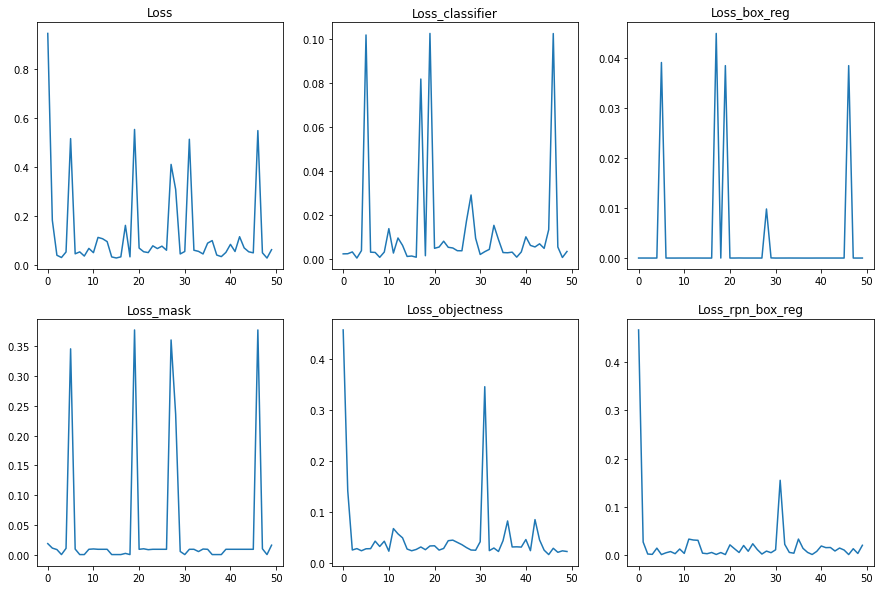

In [53]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

ax[0,0].plot(range(len(logs)),losses)
ax[0,0].set_title('Loss')
ax[0,1].plot(range(len(logs)),losses_class)
ax[0,1].set_title('Loss_classifier')
ax[0,2].plot(range(len(logs)),losses_box_reg)
ax[0,2].set_title('Loss_box_reg')
ax[1,0].plot(range(len(logs)),losses_mask)
ax[1,0].set_title('Loss_mask')
ax[1,1].plot(range(len(logs)),losses_objectness)
ax[1,1].set_title('Loss_objectness')
ax[1,2].plot(range(len(logs)),losses_rpn_box_reg)
ax[1,2].set_title('Loss_rpn_box_reg')

In [52]:
torch.max(predictions[2]['masks'])

tensor(0.0048, device='cuda:0', grad_fn=<MaxBackward1>)

In [ ]:
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             ...
#             }, PATH)

In [33]:
model = model.cpu()

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (lesion) + background
num_classes = 3  # 2 classes (lesion benign + lesion malignant) + background


# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [13]:
predictions

[{'boxes': tensor([[2.5803e+02, 2.3219e+02, 3.9800e+02, 2.9883e+02],
          [1.1064e+02, 1.4831e+02, 1.4184e+02, 1.6377e+02],
          [1.0749e+02, 1.3834e+02, 1.3233e+02, 1.7288e+02],
          [1.5622e+02, 1.9665e+02, 1.8711e+02, 2.1219e+02],
          [1.6788e+02, 1.8433e+02, 1.9201e+02, 2.2053e+02],
          [1.1911e+02, 1.3744e+02, 1.4418e+02, 1.7179e+02],
          [1.7898e+02, 1.8363e+02, 2.0447e+02, 2.1935e+02],
          [1.6970e+02, 1.9679e+02, 2.0021e+02, 2.1216e+02],
          [1.6757e+02, 1.7333e+02, 1.9111e+02, 2.0816e+02],
          [1.5799e+02, 1.8500e+02, 1.8792e+02, 2.0049e+02],
          [1.3170e+02, 1.3631e+02, 1.5699e+02, 1.7156e+02],
          [1.7809e+02, 2.9156e+02, 2.2092e+02, 3.0000e+02],
          [1.3280e+02, 1.4856e+02, 1.6463e+02, 1.6433e+02],
          [1.5361e+02, 2.9105e+02, 1.9505e+02, 3.0000e+02],
          [1.9327e+02, 1.7342e+02, 2.2308e+02, 1.8913e+02],
          [1.8191e+02, 1.9727e+02, 2.1213e+02, 2.1275e+02],
          [1.9056e+02, 1.0140e+

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [10]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [11]:
import utils as vision_utils

In [26]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
output = model(image_list, target_list)   # Returns losses and detections

# For inference
model.eval()
x = [torch.rand(3,300,400), torch.rand(3,500,400)]
predictions = model(x)           # Returns predictions

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [13]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

In [14]:
output

{'loss_classifier': tensor(0.0169, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0004, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(11.8512, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(35.1903, grad_fn=<DivBackward0>)}